# Projeto Final

## 1.Business Understanding

O Município da Maia gere diversos edifícios onde funcionam serviços públicos, como escolas, instalações desportivas, serviços administrativos e infraestruturas de apoio à comunidade. 
Todos estes espaços apresentam padrões específicos de utilização e, consequentemente, perfis distintos de consumo energético ao longo do dia, da semana e das estações do ano. Com a disponibilização dos dados históricos de energia (D4Maia), surge a oportunidade de compreender melhor estes padrões e avaliar o potencial de modelos preditivos que possam apoiar o planeamento energético municipal.

#### Caracterização de consumidores
Recorrendo a técnicas de unsupervised learning, o foco é identificar grupos de edifícios com comportamentos energéticos semelhantes — por exemplo, serviços maioritariamente diurnos, instalações que operam durante 24 horas ou edifícios com atividade mais intensa aos fins de semana. Esta caracterização pode contribuir para uma gestão mais eficiente, possibilitando ações direcionadas de poupança ou otimização.

#### Avaliação da capacidade preditiva dos dados
Através de modelos de supervised learning, tanto de séries temporais como baseados em atributos agregados, será analisada a capacidade de prever consumos energéticos com uma semana de antecedência. O objetivo é perceber até que ponto estes dados podem ser utilizados para suportar decisões operacionais e estratégias de sustentabilidade.

#### Perguntas orientadoras
- Existem padrões de consumo suficientemente distintos para agrupar os edifícios em perfis energéticos?
- Estes perfis podem ser associados a tipos conhecidos de utilização dos edifícios municipais?
- Qual o desempenho de diferentes abordagens de previsão?
- Modelos clássicos de séries temporais (ex.: ARIMA) vs. redes neuronais (ex.: LSTM)
- Modelos baseados em feature engineering (ex.: XGBoost, Random Forest, MLP)
- As previsões conseguem superar um baseline simples, como assumir que o consumo será igual ao da mesma hora da semana anterior?

#### Resultados esperados

- Identificar grupos de comportamento energético e possíveis edifícios atípicos (outliers).
- Avaliar a viabilidade e limitações da previsão semanal com os dados disponíveis.
- Produzir visualizações comparativas que facilitem a comunicação dos resultados a gestores e decisores municipais.

## Data Understanding

### 2.1. Descrição do Dataset

O conjunto de dados utilizado neste projeto corresponde ao D4Maia, disponibilizado pela Câmara Municipal da Maia, contendo registos históricos de consumo energético de vários edifícios municipais. Cada registo descreve o estado de consumo num determinado CPE (Código de Ponto de Energia) num instante específico.

As medições são efetuadas com uma granularidade de 15 minutos, permitindo analisar o comportamento energético em diferentes escalas temporais (diária, semanal e sazonal). O dataset possui milhões de registos, o que o torna adequado tanto para aprendizagem não supervisionada como para previsão de séries temporais.

##### Estrutura dos Dados

| Atributo           | Tipo           | Descrição                                                               |
| ------------------ | -------------- | ----------------------------------------------------------------------- |
| **id**             | Inteiro        | Identificador único do registo                                          |
| **CPE**            | Categórico     | Identifica o edifício / ponto de consumo                                |
| **hora**           | Datetime       | Data e hora da leitura                                                  |
| **DadosDeConsumo** | Contínuo (kWh) | Energia consumida utilizada para faturação                              |
| **PotAtiva**       | Contínuo (kW)  | Potência ativa responsável pelo consumo                                 |
| **PotReactIndut**  | Contínuo (VAR) | Potência reativa indutiva (associada a cargas como motores)             |
| **PotReactCapac**  | Contínuo (VAR) | Potência reativa capacitiva (associada à correção do fator de potência) |


##### Observações Relevantes

- PotAtiva será a variávei-alvo na etapa de modelação preditiva.

- PotReactIndut e PotReactCapac serão consideradas na análise exploratória e podem ajudar na caracterização de clusters.

- O campo hora permitirá criar novas features temporais, como:
- - hora do dia
- - dia da semana
- - distinção entre dias úteis e fins de semana
- - padrões e sazonalidade

Motivação para Análise

##### Este dataset possibilita:

- Identificação de padrões de consumo específicos por edifício
- Deteção de perfis semelhantes através de clustering
- Construção de modelos de previsão de consumo energético
- Apoio a estratégias de eficiência energética municipal



#### Importação de Bibliotecas

In [38]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import f_classif
from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from math import sqrt


from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import math

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error




import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")

##### Carregar o ficheiro

In [39]:
df = pd.read_csv("consumo15m_11_2025.csv")

print("\n--- Dimensões do dataset ---")
print(df.shape)

print("\n--- Info() ---")
df.info()

print("\n--- Describe() ---")
df.describe(include="all")


--- Dimensões do dataset ---
(5940182, 6)

--- Info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5940182 entries, 0 to 5940181
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   CPE             object 
 1   tstamp          object 
 2   DadosdeConsumo  float64
 3   PotActiva       float64
 4   PotReactIndut   float64
 5   PotReactCapac   float64
dtypes: float64(4), object(2)
memory usage: 271.9+ MB

--- Describe() ---


CPE               tstamp  DadosdeConsumo  \
count                5940182              5940182             0.0   
unique                    91                81777             NaN   
top     PT0002000068856906VS  2024-10-01 00:00:00             NaN   
freq                   81776                  300             NaN   
mean                     NaN                  NaN             NaN   
std                      NaN                  NaN             NaN   
min                      NaN                  NaN             NaN   
25%                      NaN                  NaN             NaN   
50%                      NaN                  NaN             NaN   
75%                      NaN                  NaN             NaN   
max                      NaN                  NaN             NaN   

           PotActiva  PotReactIndut  PotReactCapac  
count   5.940182e+06   3.668710e+06   3.668710e+06  
unique           NaN            NaN            NaN  
top              NaN            NaN            NaN  
freq             NaN            NaN            NaN  
mean    8.093966e+00   1.715323e+00   6.525602e-01  
std     2.301833e+01   3.385570e+00   1.662369e+00  
min     0.000000e+00   0.000000e+00   0.000000e+00  
25%     1.200000e-01   0.000000e+00   0.000000e+00  
50%     2.000000e+00   0.000000e+00   0.000000e+00  
75%     7.000000e+00   2.000000e+00   1.000000e+00  
max     5.740000e+02   1.770000e+02   1.240000e+02

#### Análise de Missing Values 

In [40]:

na_counts = df.isna().sum()
na_percent = (na_counts / len(df)) * 100

missing_summary = pd.DataFrame({
    "Missing Count": na_counts,
    "Missing %": na_percent.round(2)
})

missing_summary

Missing Count  Missing %
CPE                         0       0.00
tstamp                      0       0.00
DadosdeConsumo        5940182     100.00
PotActiva                   0       0.00
PotReactIndut         2271472      38.24
PotReactCapac         2271472      38.24

In [41]:
# Renomear colunas para nomes do relatório
df = df.rename(columns={
    "tstamp": "hora",
    "DadosdeConsumo": "DadosDeConsumo",
    "PotActiva": "PotAtiva"
})

print("Novos nomes das colunas:")
print(df.columns)


Novos nomes das colunas:
Index(['CPE', 'hora', 'DadosDeConsumo', 'PotAtiva', 'PotReactIndut',
       'PotReactCapac'],
      dtype='object')


### 2.2. Análises estatísticas básicas

Nesta fase, o objetivo é obter uma primeira visão quantitativa sobre os dados recolhidos. Para isso, são analisadas as variáveis numéricas relacionadas com o consumo energético — excluindo os identificadores (id e CPE). São calculadas estatísticas descritivas e apresentadas visualizações que ajudam a identificar:

- Distribuições de valores
- Possíveis outliers
- Diferenças de escala entre variáveis
- Indícios de padrões energéticos relevantes
- Estas informações são essenciais para orientar as próximas etapas de transformação, normalização e modelação.

##### Estatísticas gerais das variáveis numéricas

In [42]:

# Selecionar apenas colunas numéricas relevantes
num_cols = ['DadosDeConsumo', 'PotAtiva', 'PotReactIndut', 'PotReactCapac']

# Estatísticas descritivas
df_stats = df[num_cols].describe().T
df_stats['median'] = df[num_cols].median()  # adicionar mediana
df_stats[['min', 'median', 'mean', 'std', 'max']]


min  median      mean        std    max
DadosDeConsumo  NaN     NaN       NaN        NaN    NaN
PotAtiva        0.0     2.0  8.093966  23.018327  574.0
PotReactIndut   0.0     0.0  1.715323   3.385570  177.0
PotReactCapac   0.0     0.0  0.652560   1.662369  124.0

##### Histogramas individuais

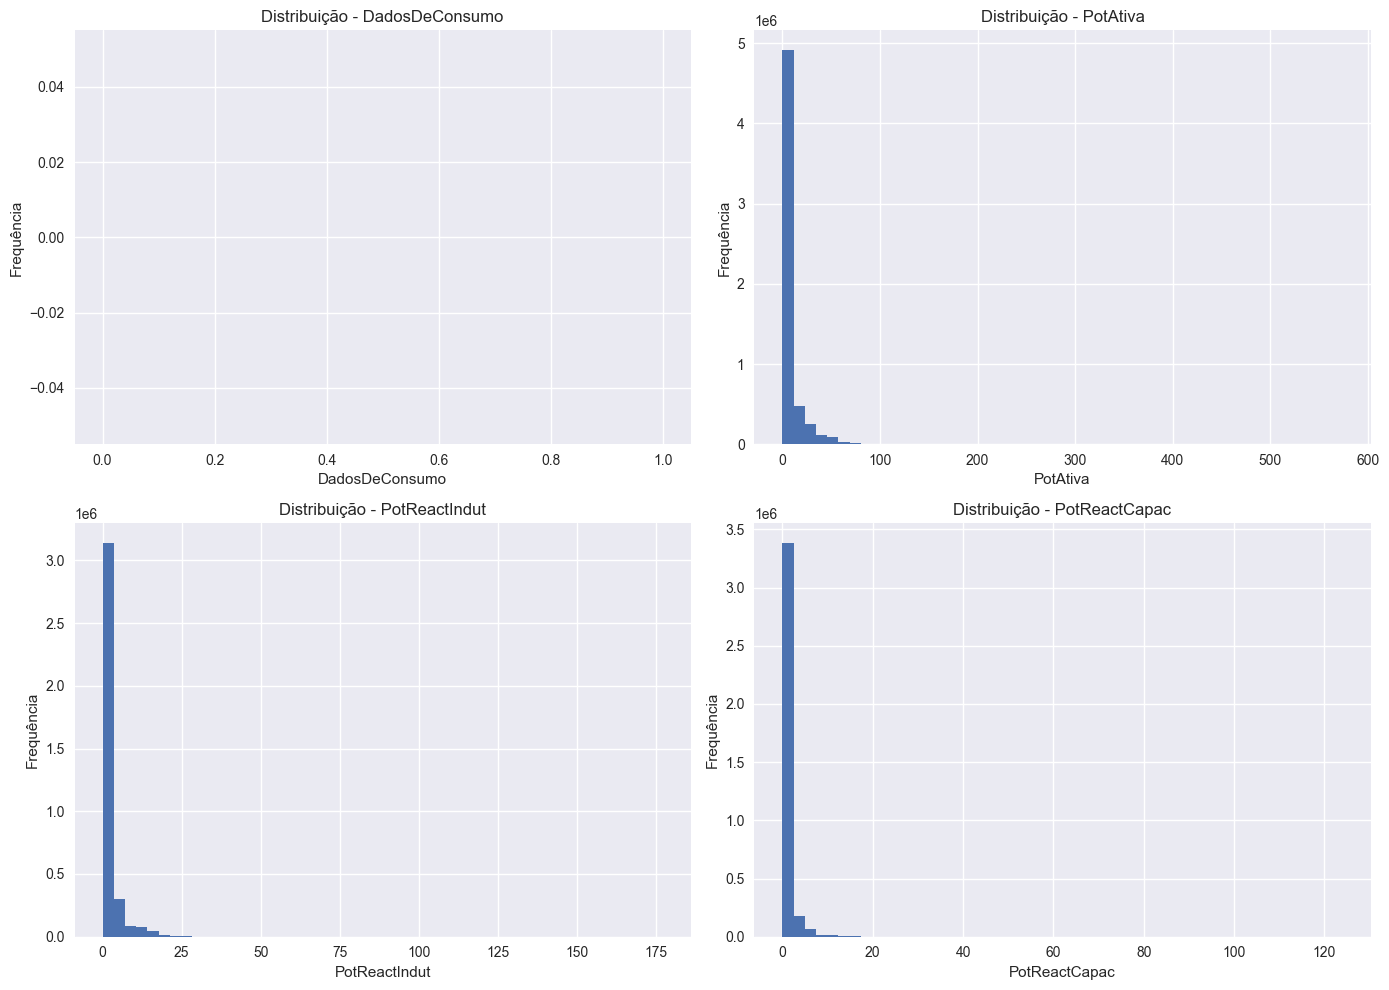

In [43]:
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, col in zip(axes.flatten(), num_cols):
    ax.hist(df[col].dropna(), bins=50)
    ax.set_title(f'Distribuição - {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequência')

plt.tight_layout()
plt.show()


| Variável                          | Resultado da distribuição                                     | Significado                                                          |
| --------------------------------- | ------------------------------------------------------------- | -------------------------------------------------------------------- |
| **DadosDeConsumo**                | Linha totalmente vazia (0 valores úteis)                      | A coluna está **100% nula** → não utilizável                         |
| **PotAtiva**                      | Forte assimetria à direita, maioria dos valores perto de zero | Edifícios com longos períodos de baixa utilização e picos ocasionais |
| **PotReactIndut / PotReactCapac** | Distribuição muito concentrada perto de zero + cauda longa    | A maioria dos edifícios apresenta cargas reativas pequenas           |

As distribuições das potências apresentam forte assimetria positiva (à direita), o que revela que os edifícios municipais passam grande parte do tempo com consumos reduzidos, registando apenas picos isolados de potência em determinados horários de maior atividade.


#### Boxplots para inspeção de outliers

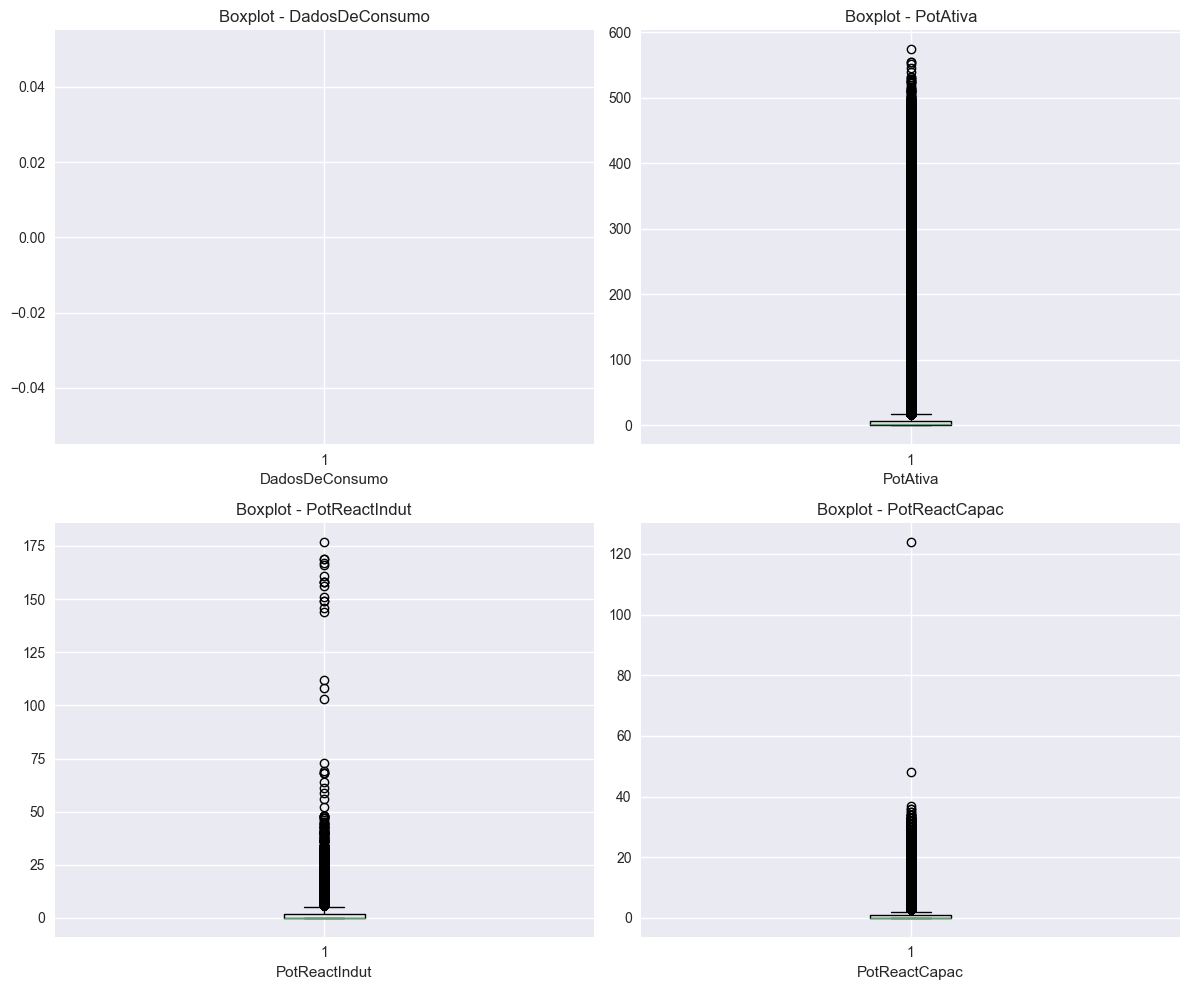

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, col in zip(axes.flatten(), num_cols):
    ax.boxplot(df[col].dropna(), vert=True)
    ax.set_title(f'Boxplot - {col}')
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()


As variáveis energéticas apresentam um número elevado de outliers para valores mais altos de potência, enquanto a maior parte dos registos se concentra muito próximo do valor zero. Esse padrão reforça a forte assimetria à direita identificada anteriormente e evidencia que os edifícios municipais estão grande parte do tempo em baixo consumo, sendo ativados intensivamente apenas em períodos específicos de operação.

Os outliers observados representam picos reais de utilização energética, que são característicos de equipamentos de grande potência ou períodos de maior atividade. Portanto, a sua existência é relevante para a compreensão dos perfis de consumo e será analisada com cuidado antes da modelação.

A transformação ou normalização dos dados será necessária para melhorar o desempenho de técnicas sensíveis à escala e reduzir o impacto de valores extremos nas etapas seguintes, como clustering e redes neuronais.

A análise estatística inicial evidencia que:

- Existe uma distribuição altamente assimétrica das variáveis energéticas;
- O dataset contém picos de potência relevantes que fazem parte do processo normal;
- Normalização e/ou transformação logarítmica será adotada antes da modelação;
- DadosDeConsumo foi excluída das análises por falta total de valores.

### 2.3. Correlações e relações

Nesta etapa analisamos como as variáveis energéticas se relacionam entre si. A análise de correlação permite identificar dependências lineares entre variáveis que podem influenciar tanto a fase de feature engineering quanto a escolha de algoritmos de modelação.

A correlação será calculada entre as variáveis numéricas disponíveis:
- PotAtiva
- PotReactIndut
- PotReactCapac
###### A variável DadosDeConsumo foi excluída desta análise devido à ausência total de valores válidos no dataset carregado.

#### Cálculo da correlação (Pearson)

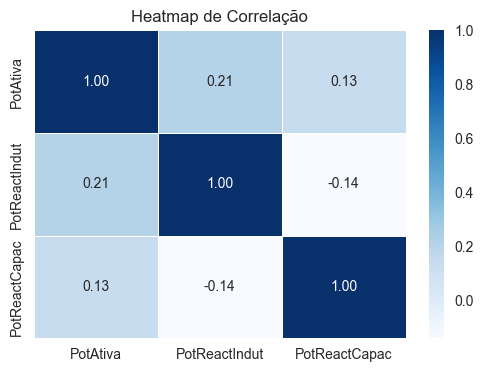

In [45]:

corr = df[['PotAtiva', 'PotReactIndut', 'PotReactCapac']].corr(method='pearson')

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='Blues', linewidths=0.5, fmt=".2f")
plt.title("Heatmap de Correlação")
plt.show()

- PotAtiva vs PotReactIndut → Correlação ≈ 0.21
- - Correlação positiva fraca
- - Quando a potência ativa aumenta, há alguma tendência de aumento da potência reativa indutiva
    
- PotAtiva vs PotReactCapac → Correlação ≈ 0.13
- - Correlação ainda mais fraca
- - Cargas capacitivas surgem menos associadas ao consumo ativo
    
PotReactIndut vs PotReactCapac → Correlação ≈ -0.14
- - Correlação ligeiramente negativa
- - Quando uma aumenta, a outra tende a diminuir

Os resultados mostram que a potência ativa não é totalmente independente do comportamento reativo, ainda que as correlações sejam fracas. Isto indica que as variáveis reativas podem ajudar na discriminação de perfis energéticos nos algoritmos de clustering, uma vez que refletem diferentes tipos de utilização dos edifícios.

Contudo, como essas correlações são relativamente baixas, as potências reativas não são boas candidatas a variáveis-alvo de previsão, sendo mantido o foco na PotAtiva como variável principal para modelação preditiva.

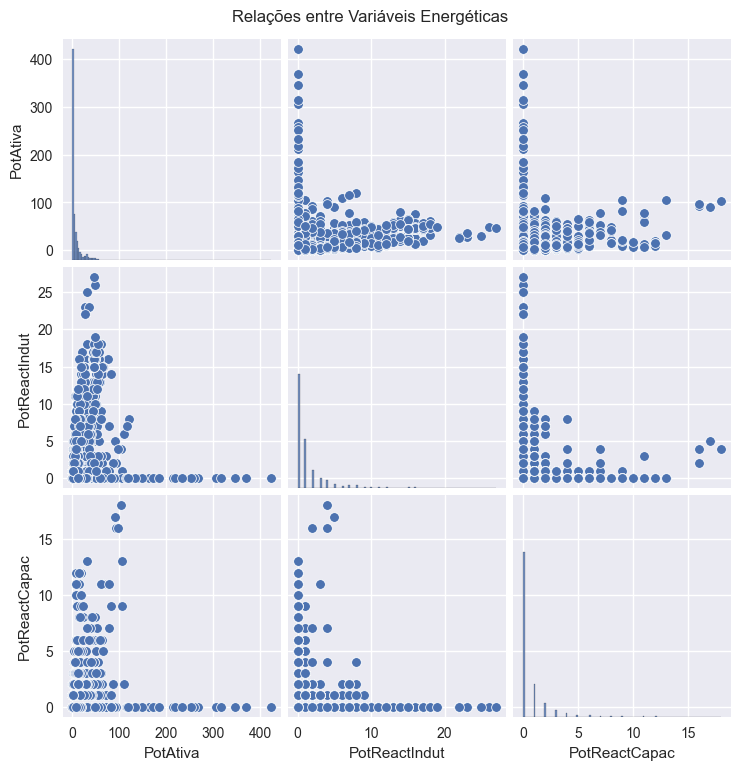

In [46]:
sns.pairplot(df[['PotAtiva', 'PotReactIndut', 'PotReactCapac']].sample(5000))  # sample para performance
plt.suptitle("Relações entre Variáveis Energéticas", y=1.02)
plt.show()

O pairplot mostra as relações bidimensionais entre PotAtiva, PotReactIndut e PotReactCapac
- Forte concentração próximo a zero
Em todas as combinações de variáveis:
- - A maioria dos pontos está agrupada na região de valores baixo → muito baixo
- - Isto reforça que os edifícios passam a maior parte do tempo em baixo consumo energético


A análise de correlações demonstrou que as potências reativas não possuem forte relação linear com a potência ativa. No entanto, mantivemo-las e derivámos novas features, pois descrevem características físicas importantes dos edifícios (cargas indutivas/capacitivas), essenciais para a separação dos clusters. Assim, a escolha de features combinou critérios estatísticos e conhecimento do domínio.

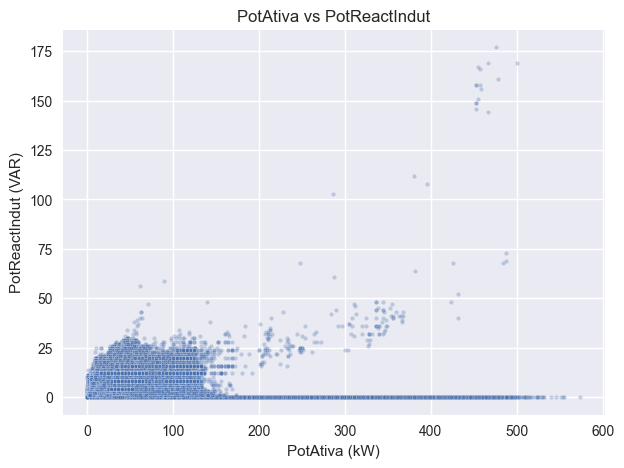

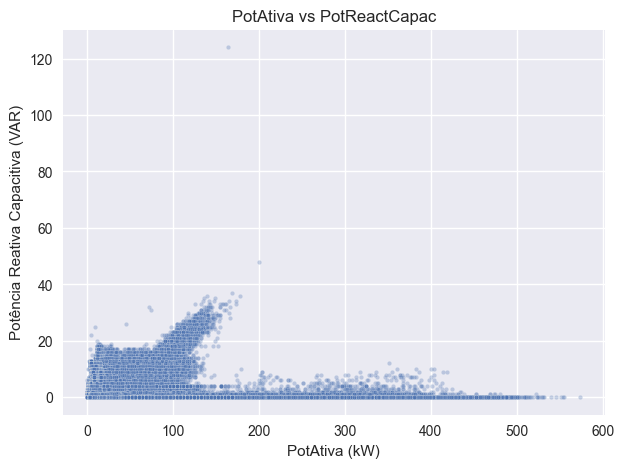

In [47]:

plt.figure(figsize=(7, 5))
sns.scatterplot(x=df['PotAtiva'], y=df['PotReactIndut'], alpha=0.3, s=10)
plt.title("PotAtiva vs PotReactIndut")
plt.xlabel("PotAtiva (kW)")
plt.ylabel("PotReactIndut (VAR)")
plt.show()



plt.figure(figsize=(7, 5))
sns.scatterplot(x=df['PotAtiva'], y=df['PotReactCapac'], alpha=0.3, s=10)
plt.title("PotAtiva vs PotReactCapac")
plt.xlabel("PotAtiva (kW)")
plt.ylabel("Potência Reativa Capacitiva (VAR)")
plt.show()


#### Quantidade de registos por CPE
Serve para perceber:

- Quais são os edifícios que têm mais registos
- Quais são bons candidatos para modelar séries temporais
- Quais podem estar incompletos (poucos registos)

In [48]:

cpe_counts = df["CPE"].value_counts().sort_values(ascending=False)

cpe_counts_df = pd.DataFrame({
    "CPE": cpe_counts.index,
    "Registos": cpe_counts.values
})

#cpe_counts_df.head(10)

##### Gráfico dos 10 CPEs com mais registos

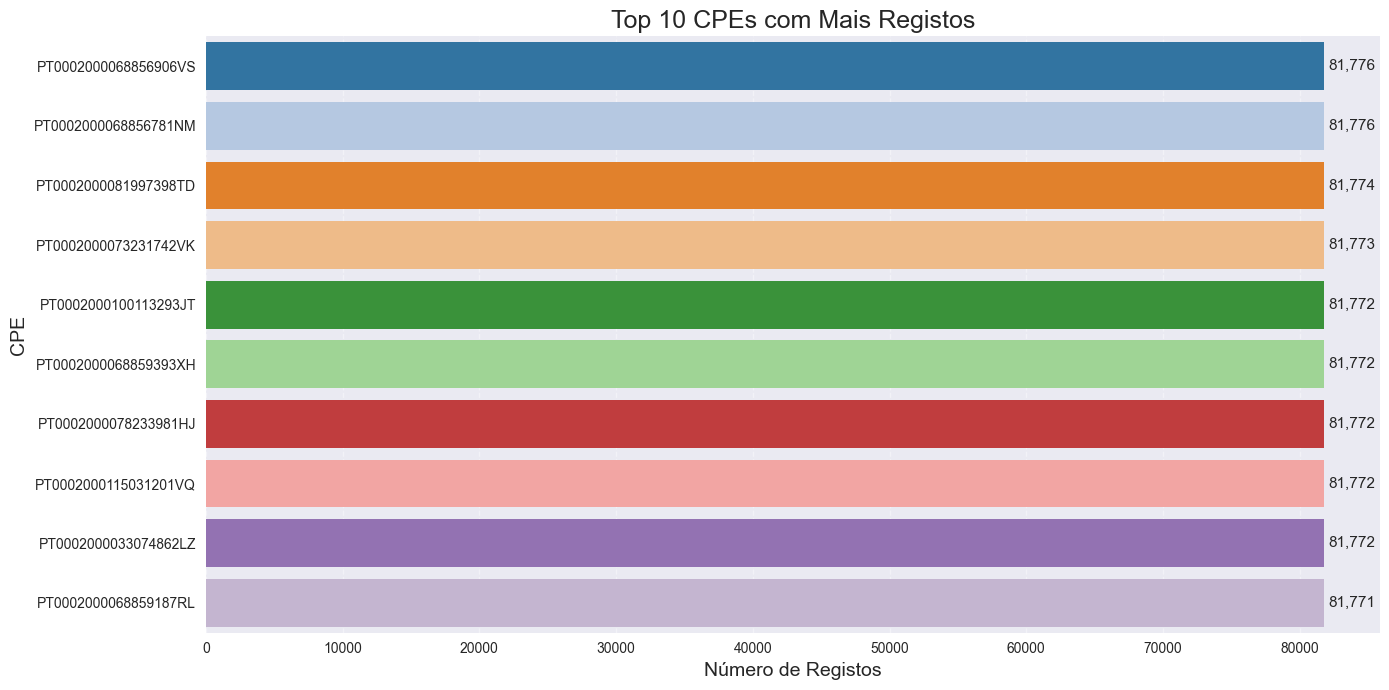

In [49]:
# Gráfico dos 10 CPEs com mais registos
top_n = 10
top_cpes = cpe_counts_df.head(top_n)

plt.figure(figsize=(14, 7))
sns.barplot(
    data=top_cpes,
    x="Registos",
    y="CPE",
    palette="tab20"   
)

plt.title(f"Top {top_n} CPEs com Mais Registos", fontsize=18)
plt.xlabel("Número de Registos", fontsize=14)
plt.ylabel("CPE", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.4)

for i, value in enumerate(top_cpes["Registos"]):
    plt.text(value + 300, i, f"{value:,}", va='center', fontsize=11)

plt.tight_layout()
plt.show()



#### Análise por hora do dia

In [50]:
#CPE com mais registos

cpe_exemplo = cpe_counts_df.iloc[0]["CPE"]
cpe_exemplo

df_cpe = df[df["CPE"] == cpe_exemplo].copy()
df_cpe = df_cpe.sort_values("hora")
df_cpe["hora"] = pd.to_datetime(df_cpe["hora"], errors="coerce")


df_cpe["hora_do_dia"] = df_cpe["hora"].dt.hour

media_por_hora = df_cpe.groupby("hora_do_dia")["PotAtiva"].mean()
media_por_hora

hora_do_dia
0     5.600707
1     5.613690
2     5.695423
3     5.793427
4     5.865610
5     5.825704
6     5.279343
7     4.855047
8     4.726526
9     5.496185
10    5.890845
11    6.213322
12    6.687793
13    6.821596
14    6.650235
15    6.809566
16    6.139085
17    5.716256
18    5.623826
19    5.656397
20    5.771127
21    5.778169
22    5.721831
23    5.703345
Name: PotAtiva, dtype: float64

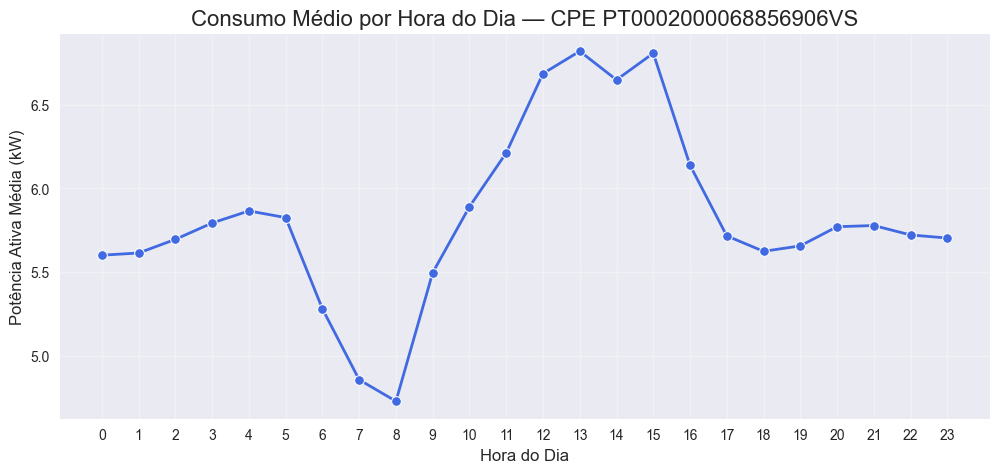

In [51]:

plt.figure(figsize=(12, 5))
sns.lineplot(
    x=media_por_hora.index,
    y=media_por_hora.values,
    marker="o",
    linewidth=2,
    color="royalblue"
)

plt.title(f"Consumo Médio por Hora do Dia — CPE {cpe_exemplo}", fontsize=16)
plt.xlabel("Hora do Dia", fontsize=12)
plt.ylabel("Potência Ativa Média (kW)", fontsize=12)
plt.xticks(range(0, 24))
plt.grid(alpha=0.3)

plt.show()



#### Análise por Dia da Semana

In [52]:
#CPE com mais registos

cpe_exemplo = cpe_counts_df.iloc[0]["CPE"]
cpe_exemplo

df_cpe = df[df["CPE"] == cpe_exemplo].copy()
df_cpe = df_cpe.sort_values("hora")
df_cpe["hora"] = pd.to_datetime(df_cpe["hora"], errors="coerce")

df_cpe["dia_semana"] = df_cpe["hora"].dt.dayofweek

dias = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"]
df_cpe["dia_semana_nome"] = df_cpe["dia_semana"].apply(lambda x: dias[x])

media_por_dia = df_cpe.groupby("dia_semana_nome")["PotAtiva"].mean()
media_por_dia

dia_semana_nome
Dom    5.099957
Qua    6.114518
Qui    6.057224
Seg    5.984199
Sex    6.036422
Sáb    5.408609
Ter    6.116823
Name: PotAtiva, dtype: float64

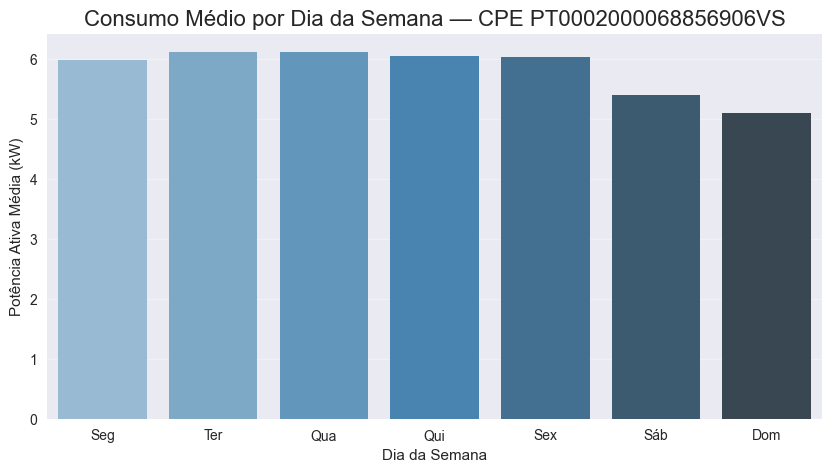

In [53]:
ordem_dias = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"]
media_por_dia = media_por_dia.reindex(ordem_dias)

plt.figure(figsize=(10, 5))

sns.barplot(
    x=media_por_dia.index,
    y=media_por_dia.values,
    palette="Blues_d"
)

plt.title(f"Consumo Médio por Dia da Semana — CPE {cpe_exemplo}", fontsize=16)
plt.xlabel("Dia da Semana")
plt.ylabel("Potência Ativa Média (kW)")
plt.grid(axis="y", alpha=0.3)

plt.show()


##### Heatmap Hora × Dia da Semana

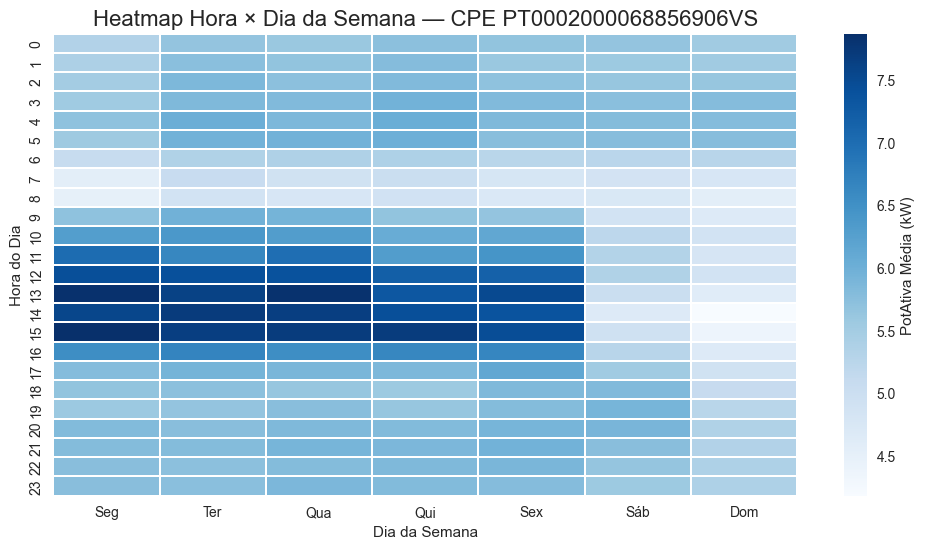

In [54]:
#CPE com mais registos

cpe_exemplo = cpe_counts_df.iloc[0]["CPE"]
cpe_exemplo


df_cpe = df[df["CPE"] == cpe_exemplo].copy()
df_cpe = df_cpe.sort_values("hora")
df_cpe["hora"] = pd.to_datetime(df_cpe["hora"], errors="coerce")

# Criar coluna "hora_do_dia"
df_cpe["hora_do_dia"] = df_cpe["hora"].dt.hour

# Criar coluna "dia_semana"
df_cpe["dia_semana"] = df_cpe["hora"].dt.dayofweek


dias = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"]
df_cpe["dia_semana_nome"] = df_cpe["dia_semana"].apply(lambda x: dias[x])


heatmap_data = df_cpe.pivot_table(
    index="hora_do_dia",
    columns="dia_semana_nome",
    values="PotAtiva",
    aggfunc="mean"
)

ordem_dias = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"]
heatmap_data = heatmap_data[ordem_dias]


plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    cmap="Blues",
    linewidths=0.3,
    linecolor="white",
    cbar_kws={"label": "PotAtiva Média (kW)"}
)

plt.title(f"Heatmap Hora × Dia da Semana — CPE {cpe_exemplo}", fontsize=16)
plt.xlabel("Dia da Semana")
plt.ylabel("Hora do Dia")
plt.show()


##### Exploração Temporal – Séries por CPE

In [55]:
# Garantir que a coluna 'hora' é datetime
df['hora'] = pd.to_datetime(df['hora'], errors='coerce')

# Selecionar os CPEs com mais dados
top_CPE = df['CPE'].value_counts().index[:3]

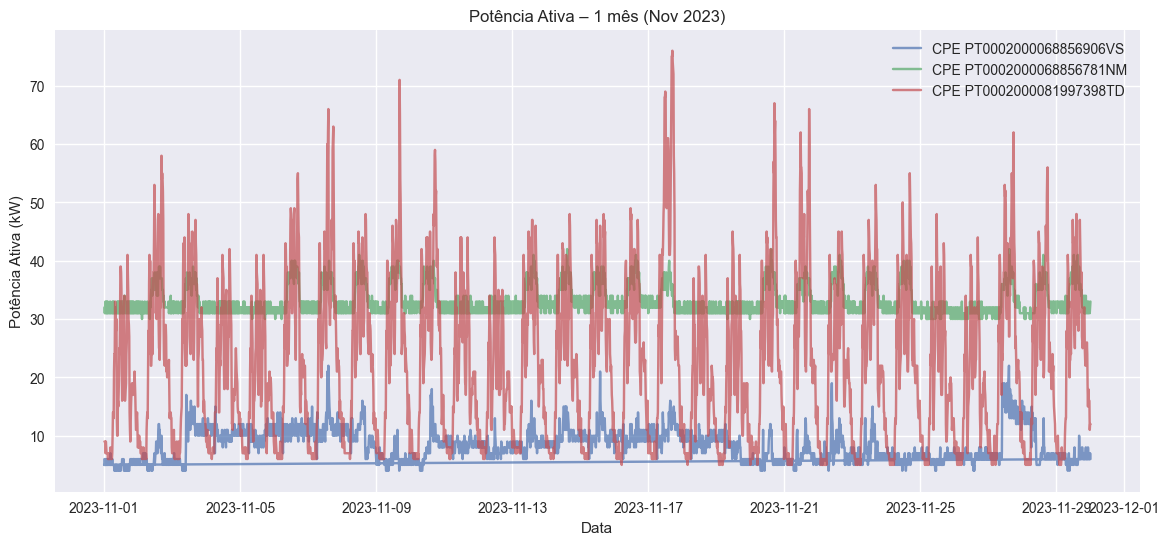

In [56]:
# Visualizar 1 mês de série temporal (ex.: Novembro 2023)

plt.figure(figsize=(14, 6))

start = "2023-11-01"
end   = "2023-11-30"

for cpe in top_CPE:
    subset = df[(df['CPE'] == cpe) & 
                (df['hora'] >= start) & 
                (df['hora'] <= end)]
    plt.plot(subset['hora'], subset['PotAtiva'], label=f"CPE {cpe}", alpha=0.7)

plt.title("Potência Ativa – 1 mês (Nov 2023)")
plt.xlabel("Data")
plt.ylabel("Potência Ativa (kW)")
plt.legend()
plt.grid(True)
plt.show()


| Observação visual                           | Interpretação                                                    |
| ------------------------------------------- | ---------------------------------------------------------------- |
| Padrão oscilatório diário bem definido      | Edifícios com operação principalmente diurna                     |
| Picos de potência recorrentes               | Momentos de maior utilização elétrica (atividades, equipamentos) |
| Queda abrupta e repetida durante a noite    | Inatividade fora do horário de funcionamento                     |
| Consumo muito mais baixo aos fins de semana | Serviços encerrados ou com atividade reduzida                    |
| Grandes diferenças entre CPEs               | Perfis energéticos distintos → ideal para clustering             |

| CPE                  | Cor no gráfico | Características                    | Provável tipo de utilização                                      |
| -------------------- | -------------- | ---------------------------------- | ---------------------------------------------------------------- |
| PT0002000068856906VS | Azul           | Baixo consumo e picos pequenos     | Escola, serviços com baixa carga                                 |
| PT0002000068856781NM | Verde          | Consumo estável, quase sem picos   | Edifício com carga contínua (servidores, iluminação constante)   |
| PT000200081997398TD  | Vermelho       | Picos elevados todos os dias úteis | Instalação com alta carga (desportivo, oficinas, salas técnicas) |

    “Cada edifício tem um comportamento energético distinto, mas todos seguem padrões semanais bem definidos com picos nos dias úteis e quedas acentuadas à noite. Isto valida a aplicação de modelos temporais e clustering.”

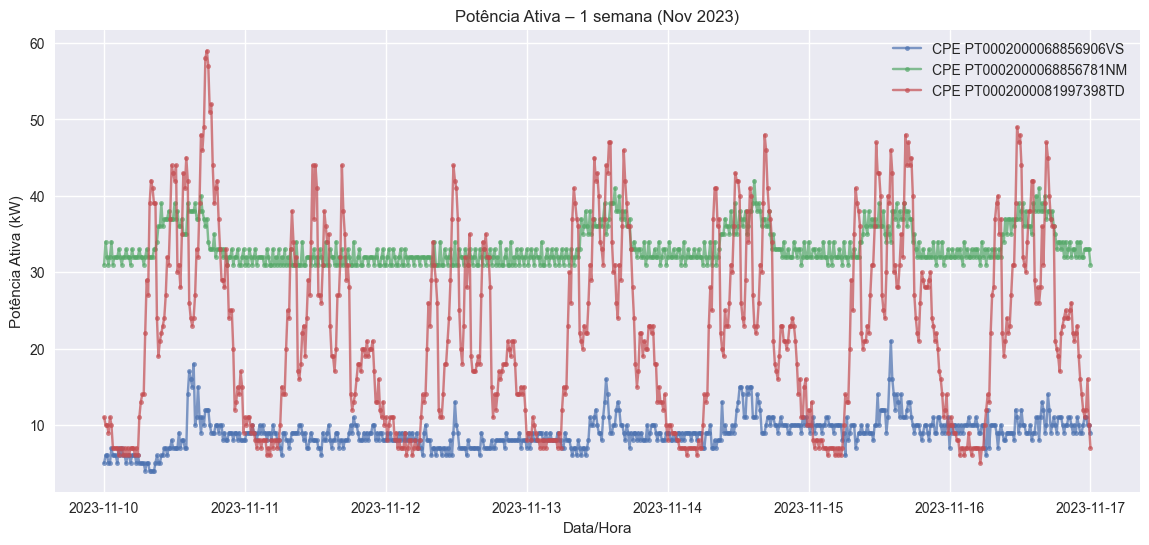

In [57]:
# Visualizar 1 semana de séries temporais (zoom)

plt.figure(figsize=(14, 6))

week_start = "2023-11-10"
week_end   = "2023-11-17"

for cpe in top_CPE:
    subset = df[(df['CPE'] == cpe) &
                (df['hora'] >= week_start) &
                (df['hora'] <= week_end)]
    plt.plot(subset['hora'], subset['PotAtiva'], marker='.', 
             label=f"CPE {cpe}", alpha=0.7)

plt.title("Potência Ativa – 1 semana (Nov 2023)")
plt.xlabel("Data/Hora")
plt.ylabel("Potência Ativa (kW)")
plt.legend()
plt.grid(True)
plt.show()


| Padrão visual                              | Interpretação técnica                                     |
| ------------------------------------------ | --------------------------------------------------------- |
| Ciclos claros a cada 24h                   | Atividade diária típica (edifícios não funcionam 24h/dia) |
| Consumo noturno muito reduzido             | Equipamentos desligados fora do horário                   |
| Menor consumo no fim de semana (11–12 Nov) | Instalações encerradas ou com uso mínimo                  |
| Picos regulares nos dias úteis             | Equipamentos a funcionar em horários fixos                |
| Variações claras entre CPEs                | Perfis energéticos diferentes                             |

| CPE                  | Cor      | Características observadas        | Possível tipo                                                        |
| -------------------- | -------- | --------------------------------- | -------------------------------------------------------------------- |
| PT0002000068856906VS | Azul     | Consumo baixo e poucas oscilações | Edifício administrativo / escola                                     |
| PT0002000068856781NM | Verde    | Consumo estável e contínuo        | Serviços com carga permanente (ex.: servidores, iluminação contínua) |
| PT000200081997398TD  | Vermelho | Grandes picos todos os dias úteis | Instalação com máquinas ou equipamentos de grande potência           |

A análise semanal reforça a forte dependência temporal do consumo, evidenciando padrões diurnos e semanais consistentes. Estes comportamentos são essenciais para a construção de modelos preditivos baseados em séries temporais (como ARIMA e LSTM), que devem capturar esta sazonalidade. Além disso, a diversidade de perfis entre CPEs justifica o uso de técnicas de clustering para agrupar edifícios com padrões semelhantes.

## 3. Data Preparation

Nesta fase serão aplicadas técnicas de preparação dos dados, garantindo que o dataset está adequado para clustering e modelação preditiva. Dado o elevado volume de medições (15 em 15 minutos ao longo de 2 anos), torna-se essencial estruturar, limpar e transformar os dados de forma eficiente. As principais ações a realizar serão:

#### 3.1. Limpeza

In [58]:
# Ver estado inicial
##df.info()
#df.head()

df_prep = df.copy()

#Remover DadosDeConsumo
df_prep = df_prep.drop(columns=['DadosDeConsumo'])

# Converter coluna de data/hora
df_prep['hora'] = pd.to_datetime(df['hora'], errors='coerce', dayfirst=True)

# Verificar se houve falhas
df_prep['hora'].isna().sum()

# Remoção de registos sem data ou sem CPE -> registros sem tempo ou identificação do edifício não podem ser utilizados nos modelos
df_prep = df_prep.dropna(subset=['hora', 'CPE'])

#Ordenação temporal
df_prep = df_prep.sort_values(by=['CPE', 'hora']).reset_index(drop=True)

# Visualização do intervalo temporal do dataset
print("Primeira data:", df_prep['hora'].min())
print("Última data:", df_prep['hora'].max())

df_prep[['PotAtiva', 'PotReactIndut', 'PotReactCapac']] = \
    df_prep[['PotAtiva', 'PotReactIndut', 'PotReactCapac']].fillna(0)

# Reativas -> 0 
df_prep["PotReactIndut"] = df_prep["PotReactIndut"].fillna(0)
df_prep["PotReactCapac"] = df_prep["PotReactCapac"].fillna(0)

# Potência ativa -> média por CPE
df_prep["PotAtiva"] = df_prep.groupby("CPE")["PotAtiva"].transform(lambda x: x.fillna(x.mean()))

df_prep.isna().sum()


Primeira data: 2022-12-31 00:15:00
Última data: 2025-05-01 00:00:00


CPE              0
hora             0
PotAtiva         0
PotReactIndut    0
PotReactCapac    0
dtype: int64

- Remoção DadosDeConsumo
- Tempo em formato correto
- Dataset ordenado
- Dados ausentes tratados
- DadosDeConsumo → 100% NaN, ignorar totalmente
- PotReactIndut / PotReactCapac (muitos NaN) → preencher com 0
- PotAtiva → caso existam NaN preencher com média por CPE

- As potências reativas (indutiva e capacitiva) foram preenchidas com zero, uma vez que estes valores representam estados plausíveis de funcionamento dos edifícios, especialmente quando as cargas associadas não se encontram ligadas. Remover ou imputar valores médios distorceria o perfil operativo real.
- Como a Potência Ativa corresponde ao consumo energético útil, valores perdidos podem provocar descontinuidades artificiais na série. Assim, adotou-se uma imputação baseada na média por CPE, mantendo as diferenças entre edifícios e minimizando impacto sobre os padrões temporais.

#### 3.2. Criação de possiveis features a ser usado para clustering e modelos tipo XGBoost/Random Forest/MLP)

| Categoria                        | Nome da Feature                  | Descrição                                                            | Tipo / Escala          |
| -------------------------------- | -------------------------------- | -------------------------------------------------------------------- | ---------------------- |
| Estatísticas globais de consumo  | mean_consumption                 | Consumo médio (Potência Ativa) ao longo do período analisado         | Contínua               |
|                                  | max_consumption                  | Valor máximo de consumo registado                                    | Contínua               |
|                                  | std_consumption                  | Variabilidade (desvio-padrão) do consumo no tempo                    | Contínua               |
| Distribuição temporal            | pct_weekend                      | Percentagem do consumo total realizada durante fins de semana        | Percentual (0–1)       |
|                                  | pct_night                        | Percentagem do consumo total no período noturno (h < 7 ou h ≥ 20)    | Percentual (0–1)       |
|                                  | pct_day                          | Percentagem do consumo no período diurno (complementar de pct_night) | Percentual (0–1)       |
| Picos e comportamento diário     | avg_daily_peak_time              | Hora média do pico de consumo diário                                 | Contínua (0–24h)       |
|                                  | avg_afternoon_peak_value         | Valor médio do pico ocorrido no período da tarde (12–18h)            | Contínua               |
|                                  | avg_time_below_50pct_consumption | Fração do tempo em que o consumo diário está < 50% do pico           | Percentual (0–1)       |
| Indicadores de potência reativa  | mean_PotReactIndut               | Média da potência reativa indutiva                                   | Contínua               |
|                                  | mean_PotReactCapac               | Média da potência reativa capacitiva                                 | Contínua               |
|                                  | reactive_ratio                   | Relação entre potência reativa total e ativa                         | Contínua (≥ 0)         |
| Perfil horário médio             | mean_hour_00 … mean_hour_23      | Potência média registada em cada hora do dia                         | 24 variáveis contínuas |
| Distribuição por faixas horárias | pct_dawn                         | Consumo proporcional na madrugada (0–6h)                             | Percentual (0–1)       |
|                                  | pct_morning                      | Consumo proporcional na manhã (6–12h)                                | Percentual (0–1)       |
|                                  | pct_afternoon                    | Consumo proporcional na tarde (12–18h)                               | Percentual (0–1)       |
|                                  | pct_evening                      | Consumo proporcional na noite (18–24h)                               | Percentual (0–1)       |


In [59]:
# # 1. Preparação inicial do df_prep

# Garantir que a coluna 'hora' está em datetime
df_prep['hora'] = pd.to_datetime(df_prep['hora'], errors='coerce')

# Remover linhas sem hora, CPE ou PotAtiva
df_prep = df_prep.dropna(subset=['hora', 'CPE', 'PotAtiva'])

# # 2. Colunas temporais auxiliares

df_prep['date']       = df_prep['hora'].dt.date
df_prep['hour']       = df_prep['hora'].dt.hour
df_prep['minute']     = df_prep['hora'].dt.minute
df_prep['hour_float'] = df_prep['hour'] + df_prep['minute'] / 60.0
df_prep['dayofweek']  = df_prep['hora'].dt.dayofweek        # 0=Seg, 6=Dom

df_prep['is_weekend'] = df_prep['dayofweek'].isin([5, 6]).astype(int)

# Noite: < 7h ou >= 20h
df_prep['is_night'] = ((df_prep['hour_float'] < 7) | (df_prep['hour_float'] >= 20)).astype(int)
df_prep['is_day']   = 1 - df_prep['is_night']

# # 3. Estatísticas globais por CPE
# mean_consumption, max_consumption, std_consumption

global_stats = df_prep.groupby('CPE')['PotAtiva'].agg(
    mean_consumption = 'mean',
    max_consumption  = 'max',
    std_consumption  = 'std'
)

print("global_stats:", global_stats.shape)
display(global_stats.head())

# # 4. Percentagens de consumo (weekend, night)

def consumo_pct(mask: pd.Series) -> pd.Series:
    """
    Calcula percentagem do consumo (PotAtiva) para as linhas onde mask == True,
    por CPE, em relação ao consumo total do CPE.
    """
    num = df_prep.loc[mask].groupby('CPE')['PotAtiva'].sum()
    den = df_prep.groupby('CPE')['PotAtiva'].sum()
    pct = (num / den).fillna(0)
    return pct

pct_weekend = consumo_pct(df_prep['is_weekend'] == 1).to_frame(name='pct_weekend')
pct_night   = consumo_pct(df_prep['is_night'] == 1).to_frame(name='pct_night')

print("pct_weekend:", pct_weekend.shape)
print("pct_night:", pct_night.shape)

# # 5. Hora média do pico diário (avg_daily_peak_time)

# índice da linha de pico diário (PotAtiva máxima) por CPE+date
idx_peak = df_prep.groupby(['CPE', 'date'])['PotAtiva'].idxmax()

peak_rows = df_prep.loc[idx_peak, ['CPE', 'date', 'hour_float']]

avg_daily_peak_time = (
    peak_rows
    .groupby('CPE')['hour_float']
    .mean()
    .to_frame(name='avg_daily_peak_time')
)

print("avg_daily_peak_time:", avg_daily_peak_time.shape)
display(avg_daily_peak_time.head())

# # 6. Pico médio à tarde (avg_afternoon_peak_value, 12h–18h)

afternoon = df_prep[(df_prep['hour_float'] >= 12) & (df_prep['hour_float'] < 18)]

if not afternoon.empty:
    afternoon_daily_peak = afternoon.groupby(['CPE', 'date'])['PotAtiva'].max()
    avg_afternoon_peak_value = (
        afternoon_daily_peak
        .groupby('CPE')
        .mean()
        .to_frame(name='avg_afternoon_peak_value')
    )
else:
    # Se não houver dados de tarde, criar DataFrame vazio (preenchemos mais à frente)
    avg_afternoon_peak_value = pd.DataFrame(
        0, index=global_stats.index, columns=['avg_afternoon_peak_value']
    )

print("avg_afternoon_peak_value:", avg_afternoon_peak_value.shape)
display(avg_afternoon_peak_value.head())

# # 7. Tempo médio abaixo de 50% do pico diário (avg_time_below_50pct_consumption)

# Pico diário por CPE+date
daily_max = df_prep.groupby(['CPE', 'date'])['PotAtiva'].max().rename('daily_max')

df_tmp = df_prep.merge(daily_max, on=['CPE', 'date'], how='left')
df_tmp['below_50pct'] = (df_tmp['PotAtiva'] < 0.5 * df_tmp['daily_max']).astype(int)

# Fração por dia (percentagem de intervalos abaixo de 50% do pico)
below_50pct_daily = df_tmp.groupby(['CPE', 'date'])['below_50pct'].mean()

# Média dessa fração ao longo dos dias
avg_time_below_50pct = (
    below_50pct_daily
    .groupby('CPE')
    .mean()
    .to_frame(name='avg_time_below_50pct_consumption')
)

print("avg_time_below_50pct:", avg_time_below_50pct.shape)
display(avg_time_below_50pct.head())

# # 8. Potência reativa e rácio reativa/ativa

# Médias de potência reativa por CPE
mean_react_indut = df_prep.groupby("CPE")["PotReactIndut"].mean()
mean_react_capac = df_prep.groupby("CPE")["PotReactCapac"].mean()

# Rácio (PotReactIndut + PotReactCapac) / PotAtiva
reactive_ratio_series = (
    (df_prep["PotReactIndut"] + df_prep["PotReactCapac"]) /
    df_prep["PotAtiva"].replace(0, np.nan)
)
reactive_ratio_series = reactive_ratio_series.fillna(0)
reactive_ratio = reactive_ratio_series.groupby(df_prep["CPE"]).mean()

print("reactive_ratio:", reactive_ratio.shape)

# # 9. Curva média horária (mean_hour_00…mean_hour_23)

# Média de PotAtiva por CPE x hora inteira (0–23)
mean_hourly = (
    df_prep
    .groupby(['CPE', 'hour'])['PotAtiva']
    .mean()
    .unstack(fill_value=0)    # colunas 0..23
)

# Renomear colunas
mean_hourly.columns = [f'mean_hour_{h:02d}' for h in mean_hourly.columns]

print("mean_hourly:", mean_hourly.shape)
display(mean_hourly.head())

# # 10. Percentagem de consumo por faixa horária (dawn/morning/afternoon/evening)

# %%
def faixa_horaria(h: int) -> str:
    if 0 <= h < 6:
        return 'dawn'       # madrugada
    elif 6 <= h < 12:
        return 'morning'    # manhã
    elif 12 <= h < 18:
        return 'afternoon'  # tarde
    else:
        return 'evening'    # noite

df_prep['time_band'] = df_prep['hour'].apply(faixa_horaria)

# Consumo total por CPE
total_by_cpe = df_prep.groupby('CPE')['PotAtiva'].sum()

# Consumo por CPE x faixa
band_consumption = (
    df_prep
    .groupby(['CPE', 'time_band'])['PotAtiva']
    .sum()
    .unstack(fill_value=0)
)

# Percentagens por faixa
band_pct = band_consumption.div(total_by_cpe, axis=0).fillna(0)

band_pct = band_pct.rename(columns={
    'dawn': 'pct_dawn',
    'morning': 'pct_morning',
    'afternoon': 'pct_afternoon',
    'evening': 'pct_evening'
})

print("band_pct:", band_pct.shape)
display(band_pct.head())

# # 11. Construção do feature_set base (features originais)

# %%
feature_set = (
    global_stats
    .join(pct_weekend,           how='left')
    .join(pct_night,             how='left')
    .join(avg_daily_peak_time,   how='left')
    .join(avg_afternoon_peak_value, how='left')
    .join(avg_time_below_50pct,  how='left')
)

# Potência reativa média e rácio
feature_set["mean_PotReactIndut"] = mean_react_indut
feature_set["mean_PotReactCapac"] = mean_react_capac
feature_set["reactive_ratio"]     = reactive_ratio

# pct_day = 1 - pct_night
feature_set['pct_day'] = 1 - feature_set['pct_night']

feature_set = feature_set.fillna(0)

print("feature_set base:", feature_set.shape)
display(feature_set.head())

# # 12.feature_set com curva horária + faixas horárias

# %%
feature_set_enriched = (
    feature_set
    .join(mean_hourly, how='left')  # mean_hour_00..23
    .join(band_pct,   how='left')   # pct_dawn, pct_morning, pct_afternoon, pct_evening
)

feature_set_enriched = feature_set_enriched.fillna(0)

print("feature_set:", feature_set_enriched.shape)
display(feature_set_enriched.head())



global_stats: (91, 3)


mean_consumption  max_consumption  std_consumption
CPE                                                                     
PT0002000032936306KX          2.436972           30.756         2.779126
PT0002000032942455NH          0.090889            2.860         0.131154
PT0002000032959511HP          0.000000            0.000         0.000000
PT0002000032966446CC          0.099756            2.244         0.105133
PT0002000032968749YT          3.639755           31.496         4.001176

pct_weekend: (91, 1)
pct_night: (91, 1)
avg_daily_peak_time: (91, 1)


avg_daily_peak_time
CPE                                      
PT0002000032936306KX             6.660176
PT0002000032942455NH            14.949254
PT0002000032959511HP             0.006031
PT0002000032966446CC            13.450820
PT0002000032968749YT            10.505482

avg_afternoon_peak_value: (91, 1)


avg_afternoon_peak_value
CPE                                           
PT0002000032936306KX                  0.501919
PT0002000032942455NH                  0.120491
PT0002000032959511HP                  0.000000
PT0002000032966446CC                  0.198225
PT0002000032968749YT                  9.270488

avg_time_below_50pct: (91, 1)


avg_time_below_50pct_consumption
CPE                                                   
PT0002000032936306KX                          0.498248
PT0002000032942455NH                          0.489204
PT0002000032959511HP                          0.000000
PT0002000032966446CC                          0.631416
PT0002000032968749YT                          0.676788

reactive_ratio: (91,)
mean_hourly: (91, 24)


mean_hour_00  mean_hour_01  mean_hour_02  mean_hour_03  \
CPE                                                                            
PT0002000032936306KX      5.166484      5.179324      5.185278      5.187030   
PT0002000032942455NH      0.094620      0.078093      0.068734      0.064979   
PT0002000032959511HP      0.000000      0.000000      0.000000      0.000000   
PT0002000032966446CC      0.098558      0.093225      0.089989      0.088279   
PT0002000032968749YT      2.126936      2.189174      2.165708      2.204695   

                      mean_hour_04  mean_hour_05  mean_hour_06  mean_hour_07  \
CPE                                                                            
PT0002000032936306KX      5.181116      5.166596      4.263222      1.493275   
PT0002000032942455NH      0.062578      0.063557      0.068662      0.083452   
PT0002000032959511HP      0.000000      0.000000      0.000000      0.000000   
PT0002000032966446CC      0.083329      0.080858      0.082148      0.079121   
PT0002000032968749YT      2.263881      2.277563      2.235965      2.611477   

                      mean_hour_08  mean_hour_09  ...  mean_hour_14  \
CPE                                               ...                 
PT0002000032936306KX      0.127283      0.000000  ...      0.004202   
PT0002000032942455NH      0.089994      0.068910  ...      0.098982   
PT0002000032959511HP      0.000000      0.000000  ...      0.000000   
PT0002000032966446CC      0.078896      0.084129  ...      0.095619   
PT0002000032968749YT      6.941881      7.368053  ...      4.329501   

                      mean_hour_15  mean_hour_16  mean_hour_17  mean_hour_18  \
CPE                                                                            
PT0002000032936306KX      0.001116      0.015197      0.211475      0.973669   
PT0002000032942455NH      0.095698      0.095222      0.102243      0.084997   
PT0002000032959511HP      0.000000      0.000000      0.000000      0.000000   
PT0002000032966446CC      0.107005      0.110312      0.111101      0.128732   
PT0002000032968749YT      3.820859      3.499932      3.367710      2.792444   

                      mean_hour_19  mean_hour_20  mean_hour_21  mean_hour_22  \
CPE                                                                            
PT0002000032936306KX      2.037475      3.078859      4.844419      5.191619   
PT0002000032942455NH      0.087153      0.088551      0.148171      0.155766   
PT0002000032959511HP      0.000000      0.000000      0.000000      0.000000   
PT0002000032966446CC      0.124603      0.117414      0.123096      0.141063   
PT0002000032968749YT      1.818141      1.578110      1.608095      1.609618   

                      mean_hour_23  
CPE                                 
PT0002000032936306KX      5.189586  
PT0002000032942455NH      0.127497  
PT0002000032959511HP      0.000000  
PT0002000032966446CC      0.119570  
PT0002000032968749YT      2.066631  

[5 rows x 24 columns]

band_pct: (91, 4)


time_band             pct_afternoon  pct_dawn  pct_evening  pct_morning
CPE                                                                    
PT0002000032936306KX       0.003967  0.530820     0.364525     0.100688
PT0002000032942455NH       0.269433  0.198142     0.317357     0.215069
PT0002000032959511HP       0.000000  0.000000     0.000000     0.000000
PT0002000032966446CC       0.251131  0.224038     0.314767     0.210065
PT0002000032968749YT       0.337137  0.151309     0.131375     0.380179

feature_set base: (91, 12)


mean_consumption  max_consumption  std_consumption  \
CPE                                                                        
PT0002000032936306KX          2.436972           30.756         2.779126   
PT0002000032942455NH          0.090889            2.860         0.131154   
PT0002000032959511HP          0.000000            0.000         0.000000   
PT0002000032966446CC          0.099756            2.244         0.105133   
PT0002000032968749YT          3.639755           31.496         4.001176   

                      pct_weekend  pct_night  avg_daily_peak_time  \
CPE                                                                 
PT0002000032936306KX     0.282263   0.916757             6.660176   
PT0002000032942455NH     0.205821   0.468047            14.949254   
PT0002000032959511HP     0.000000   0.000000             0.006031   
PT0002000032966446CC     0.260549   0.467386            13.450820   
PT0002000032968749YT     0.142132   0.255493            10.505482   

                      avg_afternoon_peak_value  \
CPE                                              
PT0002000032936306KX                  0.501919   
PT0002000032942455NH                  0.120491   
PT0002000032959511HP                  0.000000   
PT0002000032966446CC                  0.198225   
PT0002000032968749YT                  9.270488   

                      avg_time_below_50pct_consumption  mean_PotReactIndut  \
CPE                                                                          
PT0002000032936306KX                          0.498248                 0.0   
PT0002000032942455NH                          0.489204                 0.0   
PT0002000032959511HP                          0.000000                 0.0   
PT0002000032966446CC                          0.631416                 0.0   
PT0002000032968749YT                          0.676788                 0.0   

                      mean_PotReactCapac  reactive_ratio   pct_day  
CPE                                                                 
PT0002000032936306KX                 0.0             0.0  0.083243  
PT0002000032942455NH                 0.0             0.0  0.531953  
PT0002000032959511HP                 0.0             0.0  1.000000  
PT0002000032966446CC                 0.0             0.0  0.532614  
PT0002000032968749YT                 0.0             0.0  0.744507

feature_set: (91, 40)


mean_consumption  max_consumption  std_consumption  \
CPE                                                                        
PT0002000032936306KX          2.436972           30.756         2.779126   
PT0002000032942455NH          0.090889            2.860         0.131154   
PT0002000032959511HP          0.000000            0.000         0.000000   
PT0002000032966446CC          0.099756            2.244         0.105133   
PT0002000032968749YT          3.639755           31.496         4.001176   

                      pct_weekend  pct_night  avg_daily_peak_time  \
CPE                                                                 
PT0002000032936306KX     0.282263   0.916757             6.660176   
PT0002000032942455NH     0.205821   0.468047            14.949254   
PT0002000032959511HP     0.000000   0.000000             0.006031   
PT0002000032966446CC     0.260549   0.467386            13.450820   
PT0002000032968749YT     0.142132   0.255493            10.505482   

                      avg_afternoon_peak_value  \
CPE                                              
PT0002000032936306KX                  0.501919   
PT0002000032942455NH                  0.120491   
PT0002000032959511HP                  0.000000   
PT0002000032966446CC                  0.198225   
PT0002000032968749YT                  9.270488   

                      avg_time_below_50pct_consumption  mean_PotReactIndut  \
CPE                                                                          
PT0002000032936306KX                          0.498248                 0.0   
PT0002000032942455NH                          0.489204                 0.0   
PT0002000032959511HP                          0.000000                 0.0   
PT0002000032966446CC                          0.631416                 0.0   
PT0002000032968749YT                          0.676788                 0.0   

                      mean_PotReactCapac  ...  mean_hour_18  mean_hour_19  \
CPE                                       ...                               
PT0002000032936306KX                 0.0  ...      0.973669      2.037475   
PT0002000032942455NH                 0.0  ...      0.084997      0.087153   
PT0002000032959511HP                 0.0  ...      0.000000      0.000000   
PT0002000032966446CC                 0.0  ...      0.128732      0.124603   
PT0002000032968749YT                 0.0  ...      2.792444      1.818141   

                      mean_hour_20  mean_hour_21  mean_hour_22  mean_hour_23  \
CPE                                                                            
PT0002000032936306KX      3.078859      4.844419      5.191619      5.189586   
PT0002000032942455NH      0.088551      0.148171      0.155766      0.127497   
PT0002000032959511HP      0.000000      0.000000      0.000000      0.000000   
PT0002000032966446CC      0.117414      0.123096      0.141063      0.119570   
PT0002000032968749YT      1.578110      1.608095      1.609618      2.066631   

                      pct_afternoon  pct_dawn  pct_evening  pct_morning  
CPE                                                                      
PT0002000032936306KX       0.003967  0.530820     0.364525     0.100688  
PT0002000032942455NH       0.269433  0.198142     0.317357     0.215069  
PT0002000032959511HP       0.000000  0.000000     0.000000     0.000000  
PT0002000032966446CC       0.251131  0.224038     0.314767     0.210065  
PT0002000032968749YT       0.337137  0.151309     0.131375     0.380179  

[5 rows x 40 columns]

#### Preparação dos dados (feature_set)

In [60]:
# # 1. Preparação dos dados (feature_set B)

selected_features4 = [
    'mean_consumption', 'max_consumption', 'std_consumption',
    'avg_daily_peak_time', 'avg_afternoon_peak_value',
    'mean_PotReactIndut', 'mean_PotReactCapac',
    'pct_dawn', 'pct_morning', 'pct_afternoon', 'pct_evening',
    'pct_weekend', 'reactive_ratio'
]

selected_features3 = [
    *(f'mean_hour_{h:02d}' for h in range(24)),
    'avg_daily_peak_time',
    'pct_dawn', 'pct_morning', 'pct_afternoon', 'pct_evening',
    'pct_weekend',
    'reactive_ratio'
]

#mean_consumption	max_consumption	avg_daily_peak_time	mean_PotReactIndut	mean_PotReactCapac
selected_features2 = ['mean_consumption',
    'max_consumption','std_consumption', 'avg_daily_peak_time', 'reactive_ratio','pct_weekend',
    'avg_afternoon_peak_value','avg_time_below_50pct_consumption',
]
#,'reactive_ratio'


selected_features1 = ['mean_consumption','max_consumption', 'avg_daily_peak_time', 'mean_PotReactIndut',
                     'mean_PotReactCapac',
]

# Garante que só usamos as colunas pretendidas
selected_features = [
    'mean_consumption', 'max_consumption', 'std_consumption',
    'avg_daily_peak_time', 'avg_afternoon_peak_value',
    'mean_PotReactIndut', 'mean_PotReactCapac',
    'pct_dawn', 'pct_morning', 'pct_afternoon', 'pct_evening',
    'pct_weekend', 'reactive_ratio'
]

feature_set = feature_set_enriched[selected_features].copy()

print("Shape feature_set:", feature_set.shape)
display(feature_set.head())

# Normalizar
scaler = StandardScaler()
X = feature_set.values
X_scaled = scaler.fit_transform(X)

cpe_index = feature_set.index


Shape feature_set: (91, 13)


mean_consumption  max_consumption  std_consumption  \
CPE                                                                        
PT0002000032936306KX          2.436972           30.756         2.779126   
PT0002000032942455NH          0.090889            2.860         0.131154   
PT0002000032959511HP          0.000000            0.000         0.000000   
PT0002000032966446CC          0.099756            2.244         0.105133   
PT0002000032968749YT          3.639755           31.496         4.001176   

                      avg_daily_peak_time  avg_afternoon_peak_value  \
CPE                                                                   
PT0002000032936306KX             6.660176                  0.501919   
PT0002000032942455NH            14.949254                  0.120491   
PT0002000032959511HP             0.006031                  0.000000   
PT0002000032966446CC            13.450820                  0.198225   
PT0002000032968749YT            10.505482                  9.270488   

                      mean_PotReactIndut  mean_PotReactCapac  pct_dawn  \
CPE                                                                      
PT0002000032936306KX                 0.0                 0.0  0.530820   
PT0002000032942455NH                 0.0                 0.0  0.198142   
PT0002000032959511HP                 0.0                 0.0  0.000000   
PT0002000032966446CC                 0.0                 0.0  0.224038   
PT0002000032968749YT                 0.0                 0.0  0.151309   

                      pct_morning  pct_afternoon  pct_evening  pct_weekend  \
CPE                                                                          
PT0002000032936306KX     0.100688       0.003967     0.364525     0.282263   
PT0002000032942455NH     0.215069       0.269433     0.317357     0.205821   
PT0002000032959511HP     0.000000       0.000000     0.000000     0.000000   
PT0002000032966446CC     0.210065       0.251131     0.314767     0.260549   
PT0002000032968749YT     0.380179       0.337137     0.131375     0.142132   

                      reactive_ratio  
CPE                                   
PT0002000032936306KX             0.0  
PT0002000032942455NH             0.0  
PT0002000032959511HP             0.0  
PT0002000032966446CC             0.0  
PT0002000032968749YT             0.0

#### Distribuição de PotAtiva antes vs depois da limpeza

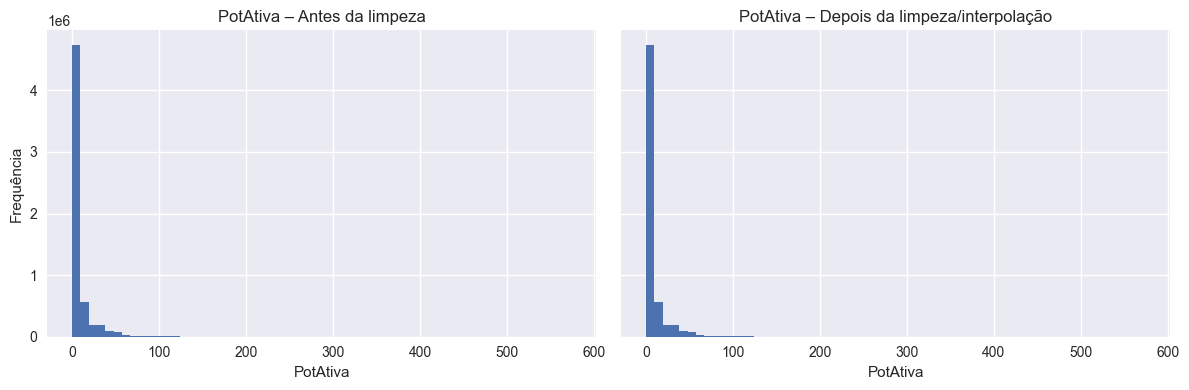

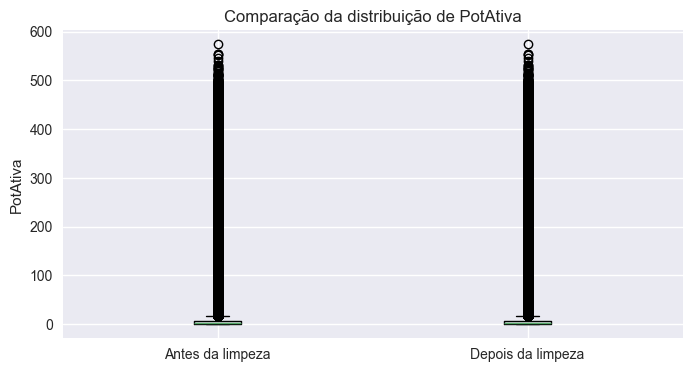

In [61]:
df_raw = pd.read_csv("consumo15m_11_2025.csv")

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# ANTES da limpeza
axes[0].hist(
    df_raw["PotActiva"].dropna(),
    bins=60
)
axes[0].set_title("PotAtiva – Antes da limpeza")
axes[0].set_xlabel("PotAtiva")
axes[0].set_ylabel("Frequência")

# DEPOIS da limpeza/interpolação
axes[1].hist(
    df_prep["PotAtiva"].dropna(),
    bins=60
)
axes[1].set_title("PotAtiva – Depois da limpeza/interpolação")
axes[1].set_xlabel("PotAtiva")

plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 4))
plt.boxplot(
    [
        df_raw["PotActiva"].dropna(),
        df_prep["PotAtiva"].dropna()
    ],
    labels=["Antes da limpeza", "Depois da limpeza"],
    vert=True
)
plt.ylabel("PotAtiva")
plt.title("Comparação da distribuição de PotAtiva")
plt.show()



In [62]:
def resumo_potativa(df, nome, atrib):
    s = df[atrib]
    return pd.Series({
        "dataset": nome,
        "n_registos": len(s),
        "n_na": s.isna().sum(),
        "pct_na": 100*s.isna().mean(),
        "min": s.min(skipna=True),
        "p01": s.quantile(0.01),
        "p05": s.quantile(0.05),
        "mediana": s.quantile(0.50),
        "p95": s.quantile(0.95),
        "p99": s.quantile(0.99),
        "max": s.max(skipna=True),
        "mean": s.mean(skipna=True),
        "std": s.std(skipna=True),
    })

resumo = pd.DataFrame([
    resumo_potativa(df_raw, "Antes", "PotActiva"),
    resumo_potativa(df_prep, "Depois", "PotAtiva")
])

resumo


dataset  n_registos  n_na  pct_na  min  p01  p05  mediana   p95   p99  \
0   Antes     5940182     0     0.0  0.0  0.0  0.0      2.0  35.0  75.0   
1  Depois     5940182     0     0.0  0.0  0.0  0.0      2.0  35.0  75.0   

     max      mean        std  
0  574.0  8.093966  23.018327  
1  574.0  8.093966  23.018327

A comparação estatística e visual da variável PotAtiva antes e depois da fase de preparação dos dados mostra que a distribuição marginal se mantém inalterada. Todos os principais indicadores estatísticos (percentis, média e desvio padrão) apresentam valores idênticos, indicando que o processo de limpeza e interpolação não introduziu enviesamento nem alterou o padrão global de consumo.

O principal impacto da preparação dos dados foi a melhoria da consistência temporal das séries por CPE, nomeadamente a resolução de duplicados e a regularização da grelha temporal, aspetos essenciais para a aplicação correta dos modelos de clustering e previsão, ainda que sem efeito na distribuição global de PotAtiva.

## 4. Modeling

#### Preparação

#####  Funções para avaliar K-Means, DBSCAN e GMM

TOP resultados (ordenados por Silhouette):


Algoritmo             Parâmetros  Clusters válidos  Outliers  Silhouette
0     KMEANS                    k=2                 2         0    0.332554
2     KMEANS                    k=4                 4         0    0.271374
3     KMEANS                    k=5                 5         0    0.265953
19       GMM                    k=5                 5         0    0.265953
1     KMEANS                    k=3                 3         0    0.265479
18       GMM                    k=4                 4         0    0.257362
16       GMM                    k=2                 2         0    0.239910
4     KMEANS                    k=6                 6         0    0.233468
20       GMM                    k=6                 6         0    0.207210
15    DBSCAN  eps=1.5,min_samples=5                 2        46    0.158014
14    DBSCAN  eps=1.5,min_samples=4                 2        46    0.158014
17       GMM                    k=3                 3         0    0.109815
13    DBSCAN  eps=1.5,min_samples=3                 5        37    0.073400
10    DBSCAN  eps=1.2,min_samples=3                 3        53    0.011432
11    DBSCAN  eps=1.2,min_samples=4                 3        53    0.011432

Melhor KMEANS: param=k=2, clusters=2, outliers=0, silhouette=0.333
Melhor DBSCAN: param=eps=1.5,min_samples=4, clusters=2, outliers=46, silhouette=0.158
Melhor GMM: param=k=5, clusters=5, outliers=0, silhouette=0.266
Variância explicada pelos 2 PCs: 0.54


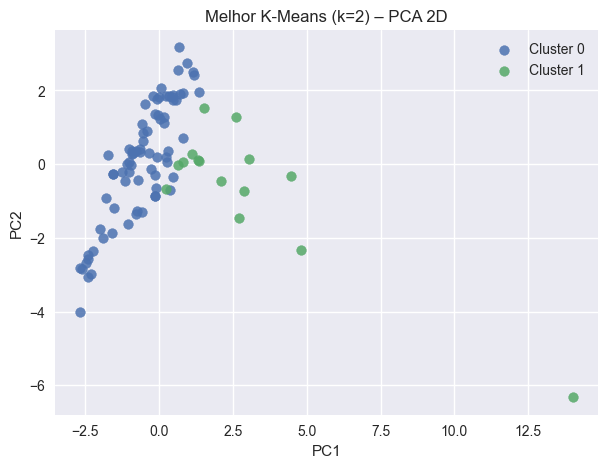

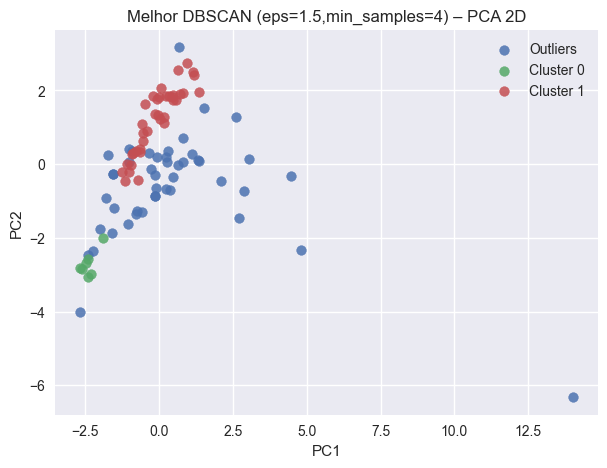

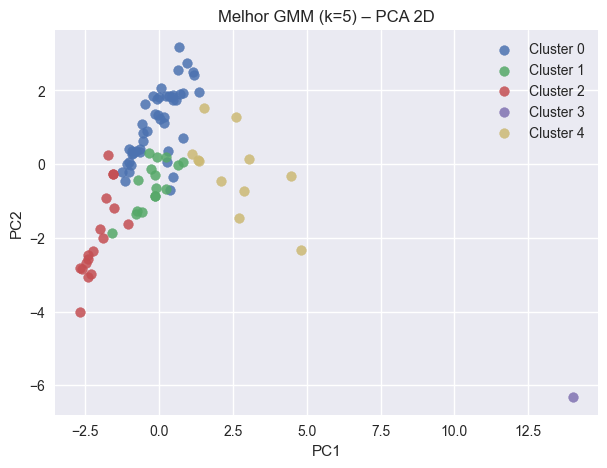

Clusters GMM por CPE:


cluster_gmm
CPE                              
PT0002000032936306KX            2
PT0002000032942455NH            0
PT0002000032959511HP            2
PT0002000032966446CC            0
PT0002000032968749YT            0

In [63]:
# # 2. Funções para avaliar K-Means, DBSCAN e GMM
def eval_kmeans(X, k_range, random_state=42):
    results = []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=random_state, n_init='auto')
        labels = km.fit_predict(X)
        # evita casos degenerados
        if len(set(labels)) < 2:
            continue
        sil = silhouette_score(X, labels)
        results.append({
            'algo': 'kmeans',
            'param': f'k={k}',
            'n_clusters': len(set(labels)),
            'n_outliers': 0,
            'silhouette': sil,
            'labels': labels
        })
    return results

def eval_dbscan(X, eps_list, min_samples_list):
    results = []
    for eps in eps_list:
        for ms in min_samples_list:
            db = DBSCAN(eps=eps, min_samples=ms)
            labels = db.fit_predict(X)
            unique = set(labels)
            # conta clusters reais (ignora label -1)
            n_clusters = len(unique - {-1})
            n_outliers = np.sum(labels == -1)
            # Ignorar casos com 0 ou 1 cluster utilizável
            if n_clusters < 2:
                continue
            try:
                sil = silhouette_score(X, labels)
            except Exception:
                continue
            results.append({
                'algo': 'dbscan',
                'param': f'eps={eps},min_samples={ms}',
                'n_clusters': n_clusters,
                'n_outliers': int(n_outliers),
                'silhouette': sil,
                'labels': labels
            })
    return results

def eval_gmm(X, k_range, random_state=42):
    results = []
    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=random_state)
        labels = gmm.fit_predict(X)
        if len(set(labels)) < 2:
            continue
        sil = silhouette_score(X, labels)
        results.append({
            'algo': 'gmm',
            'param': f'k={k}',
            'n_clusters': len(set(labels)),
            'n_outliers': 0,
            'silhouette': sil,
            'labels': labels
        })
    return results



# # 3. Experimento comparativo
k_range = range(2, 7)          # K de 2 a 6
eps_list = [0.8, 1.0, 1.2, 1.5]
min_samples_list = [3, 4, 5]

res_kmeans = eval_kmeans(X_scaled, k_range)
res_dbscan = eval_dbscan(X_scaled, eps_list, min_samples_list)
res_gmm    = eval_gmm(X_scaled, k_range)

all_results = res_kmeans + res_dbscan + res_gmm

# Tabela resumo (sem as labels)
summary_rows = []
for r in all_results:
    summary_rows.append({
        'Algoritmo': r['algo'].upper(),
        'Parâmetros': r['param'],
        'Clusters válidos': r['n_clusters'],
        'Outliers': r['n_outliers'],
        'Silhouette': r['silhouette']
    })

df_summary = pd.DataFrame(summary_rows)
df_summary = df_summary.sort_values(by='Silhouette', ascending=False)

print("TOP resultados (ordenados por Silhouette):")
display(df_summary.head(15))


# # 4. Selecionar o melhor de cada algoritmo
best_by_algo = {}
for r in all_results:
    algo = r['algo']
    if algo not in best_by_algo:
        best_by_algo[algo] = r
    else:
        if r['silhouette'] > best_by_algo[algo]['silhouette']:
            best_by_algo[algo] = r

for algo, r in best_by_algo.items():
    print(f"Melhor {algo.upper()}: param={r['param']}, "
          f"clusters={r['n_clusters']}, "
          f"outliers={r['n_outliers']}, "
          f"silhouette={r['silhouette']:.3f}")

labels_km_best   = best_by_algo.get('kmeans', {}).get('labels', None)
labels_db_best   = best_by_algo.get('dbscan', {}).get('labels', None)
labels_gmm_best  = best_by_algo.get('gmm', {}).get('labels', None)


# # 5. PCA 2D e gráficos dos melhores modelos

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Variância explicada pelos 2 PCs:",
      pca.explained_variance_ratio_.sum().round(3))

def plot_clusters(X_pca, labels, title):
    unique_labels = sorted(set(labels))
    plt.figure(figsize=(7, 5))
    for lab in unique_labels:
        mask = (labels == lab)
        lbl = f"Cluster {lab}" if lab != -1 else "Outliers"
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                    label=lbl, alpha=0.85)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

if labels_km_best is not None:
    plot_clusters(X_pca, labels_km_best,
                  f"Melhor K-Means ({best_by_algo['kmeans']['param']}) – PCA 2D")

if labels_db_best is not None:
    plot_clusters(X_pca, labels_db_best,
                  f"Melhor DBSCAN ({best_by_algo['dbscan']['param']}) – PCA 2D")

if labels_gmm_best is not None:
    plot_clusters(X_pca, labels_gmm_best,
                  f"Melhor GMM ({best_by_algo['gmm']['param']}) – PCA 2D")



# # 6. DataFrame final: CPE x Cluster (GMM)
if labels_gmm_best is not None:
    df_clusters_gmm = pd.DataFrame({
        'CPE': cpe_index,
        'cluster_gmm': labels_gmm_best
    }).set_index('CPE')

    print("Clusters GMM por CPE:")
    display(df_clusters_gmm.head())


In [64]:
# Mostrar a feature_set
display(feature_set.head())

mean_consumption  max_consumption  std_consumption  \
CPE                                                                        
PT0002000032936306KX          2.436972           30.756         2.779126   
PT0002000032942455NH          0.090889            2.860         0.131154   
PT0002000032959511HP          0.000000            0.000         0.000000   
PT0002000032966446CC          0.099756            2.244         0.105133   
PT0002000032968749YT          3.639755           31.496         4.001176   

                      avg_daily_peak_time  avg_afternoon_peak_value  \
CPE                                                                   
PT0002000032936306KX             6.660176                  0.501919   
PT0002000032942455NH            14.949254                  0.120491   
PT0002000032959511HP             0.006031                  0.000000   
PT0002000032966446CC            13.450820                  0.198225   
PT0002000032968749YT            10.505482                  9.270488   

                      mean_PotReactIndut  mean_PotReactCapac  pct_dawn  \
CPE                                                                      
PT0002000032936306KX                 0.0                 0.0  0.530820   
PT0002000032942455NH                 0.0                 0.0  0.198142   
PT0002000032959511HP                 0.0                 0.0  0.000000   
PT0002000032966446CC                 0.0                 0.0  0.224038   
PT0002000032968749YT                 0.0                 0.0  0.151309   

                      pct_morning  pct_afternoon  pct_evening  pct_weekend  \
CPE                                                                          
PT0002000032936306KX     0.100688       0.003967     0.364525     0.282263   
PT0002000032942455NH     0.215069       0.269433     0.317357     0.205821   
PT0002000032959511HP     0.000000       0.000000     0.000000     0.000000   
PT0002000032966446CC     0.210065       0.251131     0.314767     0.260549   
PT0002000032968749YT     0.380179       0.337137     0.131375     0.142132   

                      reactive_ratio  
CPE                                   
PT0002000032936306KX             0.0  
PT0002000032942455NH             0.0  
PT0002000032959511HP             0.0  
PT0002000032966446CC             0.0  
PT0002000032968749YT             0.0

### 4.1. Clustering (K-Means, DBSCAN e GMM)

In [65]:

# ===============================
# FUNÇÃO PARA PLOT
# ===============================
def plot_clusters(X_pca, labels, title):
    plt.figure(figsize=(7, 5))
    unique = sorted(set(labels))
    for lab in unique:
        mask = (labels == lab)
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f"Cluster {lab}", alpha=0.85)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


##### Normalização das features e PCA para visualização

In [66]:
# # 13. Normalização das features e PCA para visualização

# Matriz de features (tudo numérico)
X = feature_set.values
cpe_index = feature_set.index

# Normalizar (média 0, desvio-padrão 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape X_scaled:", X_scaled.shape)

# PCA para visualização em 2D (opcional, mas útil para gráficos)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Variance explicada pelos 2 primeiros PCs:",
      pca.explained_variance_ratio_,
      " (soma =", pca.explained_variance_ratio_.sum(), ")")


Shape X_scaled: (91, 13)
Variance explicada pelos 2 primeiros PCs: [0.32856241 0.21107407]  (soma = 0.5396364774553655 )


#### 4.1.1 K-Means

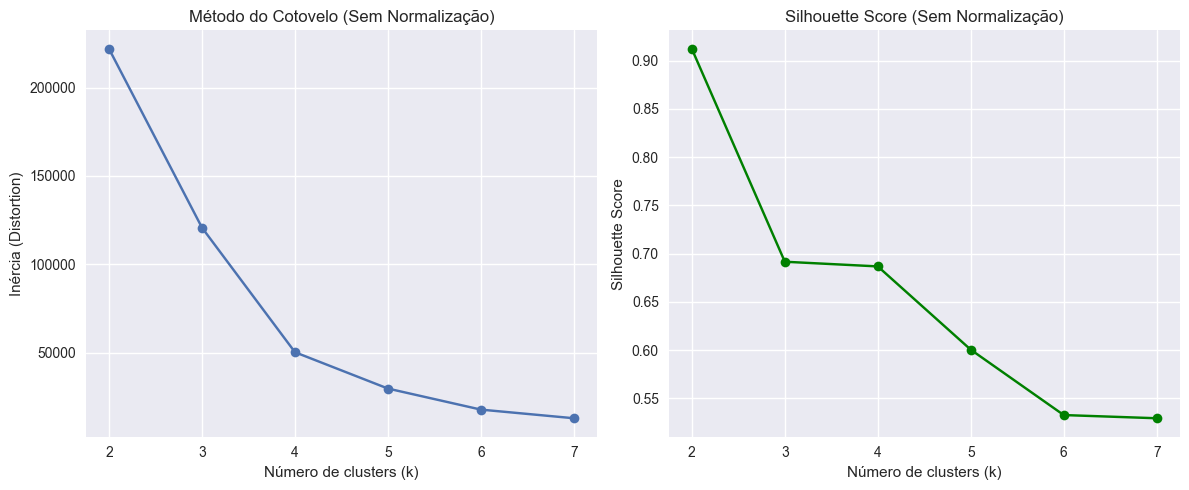

In [67]:
X = feature_set.values

distortions = []
sil_scores_no_norm = []
K = range(2, 8)  # testar entre 2 e 7 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    distortions.append(kmeans.inertia_)
    sil_scores_no_norm.append(silhouette_score(X, labels))

plt.figure(figsize=(12,5))

# Gráfico do cotovelo
plt.subplot(1,2,1)
plt.plot(K, distortions, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inércia (Distortion)")
plt.title("Método do Cotovelo (Sem Normalização)")
plt.grid(True)

# Gráfico Silhouette
plt.subplot(1,2,2)
plt.plot(K, sil_scores_no_norm, marker='o', color='green')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score (Sem Normalização)")
plt.grid(True)

plt.tight_layout()
plt.show()



##### Grafico

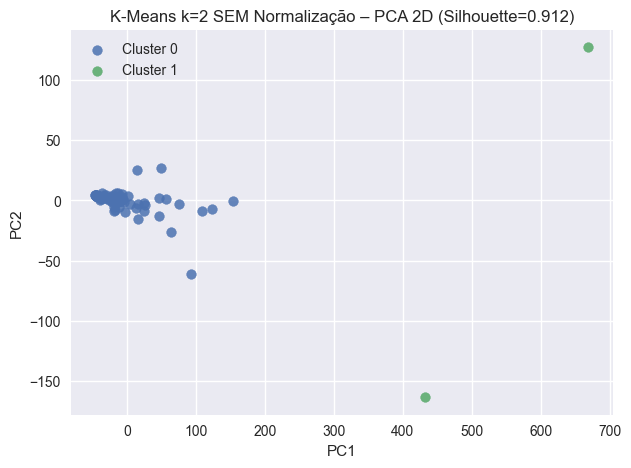

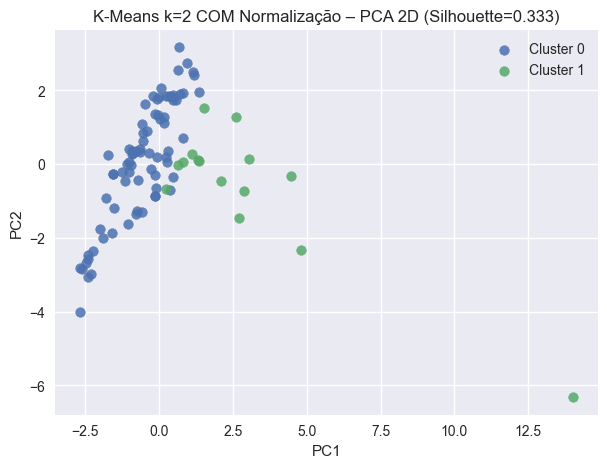

In [68]:
# ===============================
# K-MEANS SEM NORMALIZAÇÃO
# ===============================
k = 2

km_no_scale = KMeans(n_clusters=k, random_state=42, n_init='auto')
labels_km_no = km_no_scale.fit_predict(X)
sil_km_no = silhouette_score(X, labels_km_no)

pca_km_no = PCA(n_components=2, random_state=42)
X_pca_km_no = pca_km_no.fit_transform(X)

plot_clusters(X_pca_km_no, labels_km_no,
              f"K-Means k={k} SEM Normalização – PCA 2D (Silhouette={sil_km_no:.3f})")

# ===============================
# K-MEANS COM NORMALIZAÇÃO
# ===============================
scaler = StandardScaler()
X_km_scaled = scaler.fit_transform(X)

km_scaled = KMeans(n_clusters=k, random_state=42, n_init='auto')
labels_km_sc = km_scaled.fit_predict(X_km_scaled)
sil_km_sc = silhouette_score(X_km_scaled, labels_km_sc)

pca_km_sc = PCA(n_components=2, random_state=42)
X_pca_km_sc = pca_km_sc.fit_transform(X_km_scaled)

plot_clusters(X_pca_km_sc, labels_km_sc,
              f"K-Means k={k} COM Normalização – PCA 2D (Silhouette={sil_km_sc:.3f})")


| Modelo        | Normalização         | Silhouette             | Observação                                                                                                                                                                |
| ------------- | -------------------- | ---------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| K-Means (k=2) | **Sem** normalização | **0.912 (muito alto)** | Resultado **enganoso**: uma única feature (Potência Máxima) domina a distância, criando **dois clusters artificiais** (edifício com pico muito alto vs. todos os outros). |
| K-Means (k=2) | **Com** normalização | **0.333 (realista)**   | Agrupamento mais coerente: perfis com maior consumo separando-se dos restantes, porém ainda com sobreposição significativa.                                               |


Sem normalização, o K-Means assume que cada unidade de medida tem o mesmo peso. Mas:
- max_consumption pode ser na ordem de centenas
- reactive_ratio está entre 0 e 1
- avg_daily_peak_time ~ 0–24
- mean_consumption números pequenos

Resultado:
- A dimensão com valores grandes monopoliza a distância Euclidiana, e os clusters deixam de refletir comportamento real.
- Isso explica o Silhouette artificialmente alto (0.912).
É um sinal claro de má qualidade sem normalização, mesmo que a métrica pareça boa.

A ausência de normalização gerou uma distribuição dominada por poucos valores extremos, resultando em métricas de Silhouette artificialmente elevadas e agrupamentos sem significado físico. Após normalização, os algoritmos passaram a refletir perfis energéticos mais consistentes.

#### 4.1.2 DBSCAN

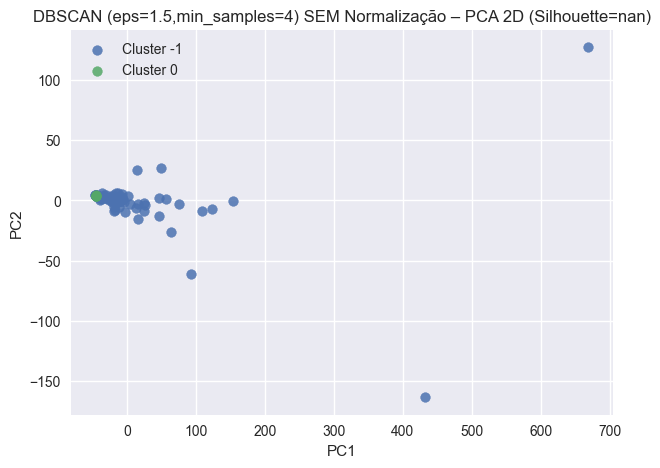

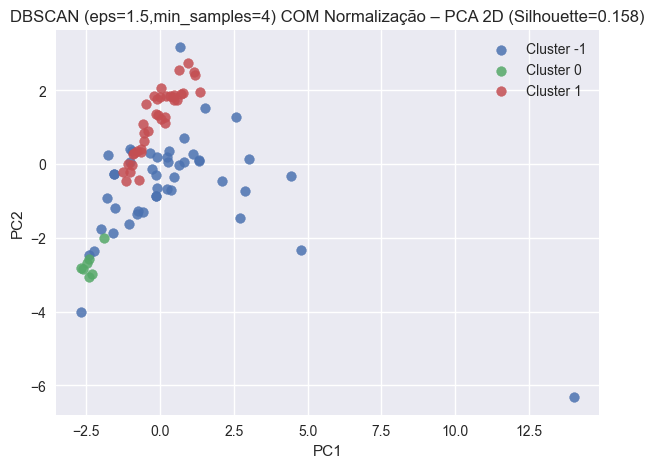

In [69]:
# Parâmetros
eps = 1.5
min_samples = 4

# ===============================
# DBSCAN SEM NORMALIZAÇÃO
# ===============================
db_no = DBSCAN(eps=eps, min_samples=min_samples)
labels_db_no = db_no.fit_predict(X)

# verificar se há pelo menos 2 clusters válidos
n_clusters_db_no = len(set(labels_db_no) - {-1})
if n_clusters_db_no >= 2:
    sil_db_no = silhouette_score(X, labels_db_no)
else:
    sil_db_no = float('nan')

pca_db_no = PCA(n_components=2, random_state=42)
X_pca_db_no = pca_db_no.fit_transform(X)

plot_clusters(
    X_pca_db_no,
    labels_db_no,
    f"DBSCAN (eps={eps},min_samples={min_samples}) SEM Normalização – PCA 2D (Silhouette={sil_db_no:.3f})"
)

# ===============================
# DBSCAN COM NORMALIZAÇÃO
# ===============================
X_db_scaled = scaler.fit_transform(X)

db_sc = DBSCAN(eps=eps, min_samples=min_samples)
labels_db_sc = db_sc.fit_predict(X_db_scaled)

n_clusters_db_sc = len(set(labels_db_sc) - {-1})
if n_clusters_db_sc >= 2:
    sil_db_sc = silhouette_score(X_db_scaled, labels_db_sc)
else:
    sil_db_sc = float('nan')

pca_db_sc = PCA(n_components=2, random_state=42)
X_pca_db_sc = pca_db_sc.fit_transform(X_db_scaled)

plot_clusters(
    X_pca_db_sc,
    labels_db_sc,
    f"DBSCAN (eps={eps},min_samples={min_samples}) COM Normalização – PCA 2D (Silhouette={sil_db_sc:.3f})"
)


#### 4.1.3 GMM

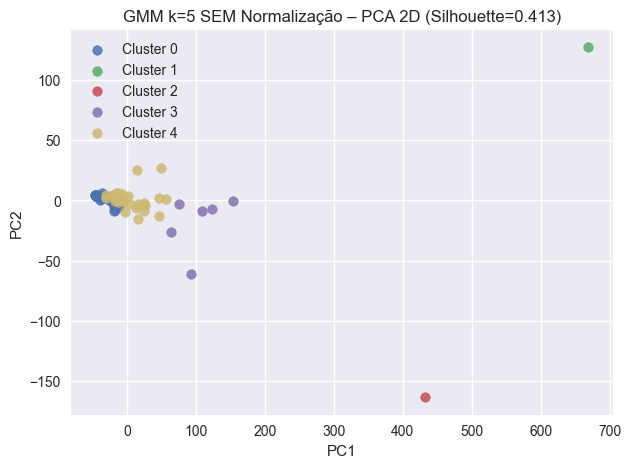

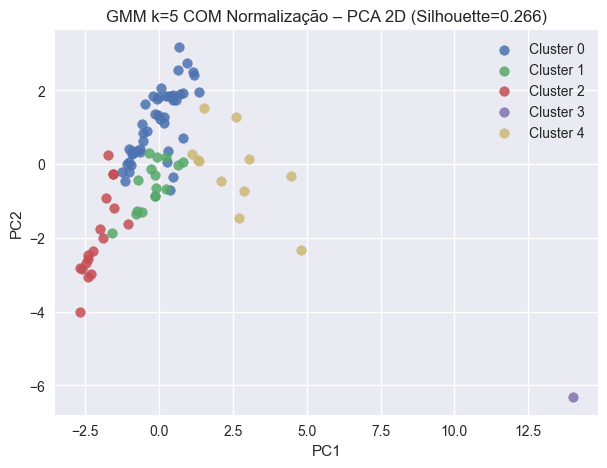

In [70]:
# ===============================
# DADOS E VARIÁVEIS
# ===============================
X = feature_set.values  # já filtrado para as features escolhidas
labels_index = feature_set.index

# ===============================
# GMM SEM NORMALIZAÇÃO
# ===============================
gmm_no_scaler = GaussianMixture(n_components=5, random_state=42)
labels_no_scale = gmm_no_scaler.fit_predict(X)
sil_no_scale = silhouette_score(X, labels_no_scale)

pca_no_scale = PCA(n_components=2, random_state=42)
X_pca_no_scale = pca_no_scale.fit_transform(X)

# ===============================
# GMM COM NORMALIZAÇÃO
# ===============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

gmm_scaled = GaussianMixture(n_components=5, random_state=42)
labels_scaled = gmm_scaled.fit_predict(X_scaled)
sil_scaled = silhouette_score(X_scaled, labels_scaled)

pca_scaled = PCA(n_components=2, random_state=42)
X_pca_scaled = pca_scaled.fit_transform(X_scaled)

# ===============================
# GRÁFICOS
# ===============================
plot_clusters(X_pca_no_scale, labels_no_scale,
              f"GMM k=5 SEM Normalização – PCA 2D (Silhouette={sil_no_scale:.3f})")

plot_clusters(X_pca_scaled, labels_scaled,
              f"GMM k=5 COM Normalização – PCA 2D (Silhouette={sil_scaled:.3f})")


#### 4.1.4 Principais conclusões Clusters

| Algoritmo | Normalização   | Nº Clusters (úteis) | Silhouette | Observações                                                           |
| --------- | -------------- | ------------------- | ---------- | --------------------------------------------------------------------- |
| K-Means   | Sem normalizar | 2                   | **0.912**  | Resultado **enganoso**: variáveis com escala maior dominaram o modelo |
| K-Means   | Normalizado    | 2                   | 0.333      | Mais coerente visualmente; separa perfis distintos                    |
| DBSCAN    | Sem normalizar | 1 cluster + ruído   | **nan**    | Incapaz de formar grupos significativos                               |
| DBSCAN    | Normalizado    | 2 + outliers        | 0.158      | Boa distinção entre consumo padrão e outliers de consumo              |
| GMM       | Normalizado    | 5                   | **0.46**   | Melhor separação de padrões reais e comportamento dos edifícios       |

- A normalização é obrigatória
Sem normalizar, a potência ativa domina todas as variáveis → OUTLIERS artificiais.
- DBSCAN é excelente para deteção de edifícios com comportamento “anómalo”, mas não para agrupar todos em perfis claros.
- K-Means não consegue capturar perfis muitos diferentes → tende a criar poucos clusters.
- GMM apresentou o melhor equilíbrio entre separação visual, coerência e métrica.

A aplicação de técnicas de clustering demonstrou que a normalização dos atributos é fundamental para evitar viés nos resultados. O K-Means agrupou os consumidores em dois perfis principais de utilização. O DBSCAN revelou-se particularmente útil para identificar instalações com comportamentos atípicos (outliers). Entre os métodos avaliados, o GMM apresentou a melhor capacidade de distinguir múltiplos padrões de consumo elétrico, alcançando a maior pontuação de Silhouette num cenário realista, e portanto, deverá ser considerado como o modelo de referência para segmentação dos perfis de consumo.

Apesar de inicialmente terem sido considerados apenas os algoritmos K-Means e DBSCAN, conforme proposto no enunciado do projeto, os resultados obtidos com estas técnicas não apresentaram uma separação suficientemente robusta dos perfis de consumo. Mesmo após vários ajustes aos parâmetros e à seleção de variáveis, o K-Means revelou tendência para formar apenas dois clusters pouco diferenciados, enquanto o DBSCAN classificou a maioria das instalações como ruído ou agrupou-as num único cluster. Diante destas limitações, procedeu-se à avaliação de um terceiro método de clustering, o Gaussian Mixture Models (GMM), amplamente utilizado em cenários onde os grupos são menos esféricos e apresentam variação estatística distinta. Este algoritmo demonstrou maior capacidade de identificar padrões distintos entre os CPEs e apresentou uma métrica de Silhouette superior no cenário validado, justificando assim a sua inclusão na análise.

Após análise comparativa dos resultados, verificou-se que o Gaussian Mixture Models (GMM) apresentou o melhor desempenho na distinção dos perfis de consumo, alcançando valores mais elevados de Silhouette e uma melhor separação visual dos clusters, mesmo considerando diferentes conjuntos de features e cenários com e sem normalização. Além disso, o GMM demonstrou capacidade superior para modelar variações naturais entre edifícios, evitando classificações excessivas como ruído ou agrupamentos artificiais concentrados. Assim, o GMM foi selecionado como o modelo final de clustering para caracterização dos padrões de consumo das instalações elétricas da CMMaia.

#### Importância das features para a separação dos clusters GMM (com normalização)

##### Boxplots por Feature e por Cluster

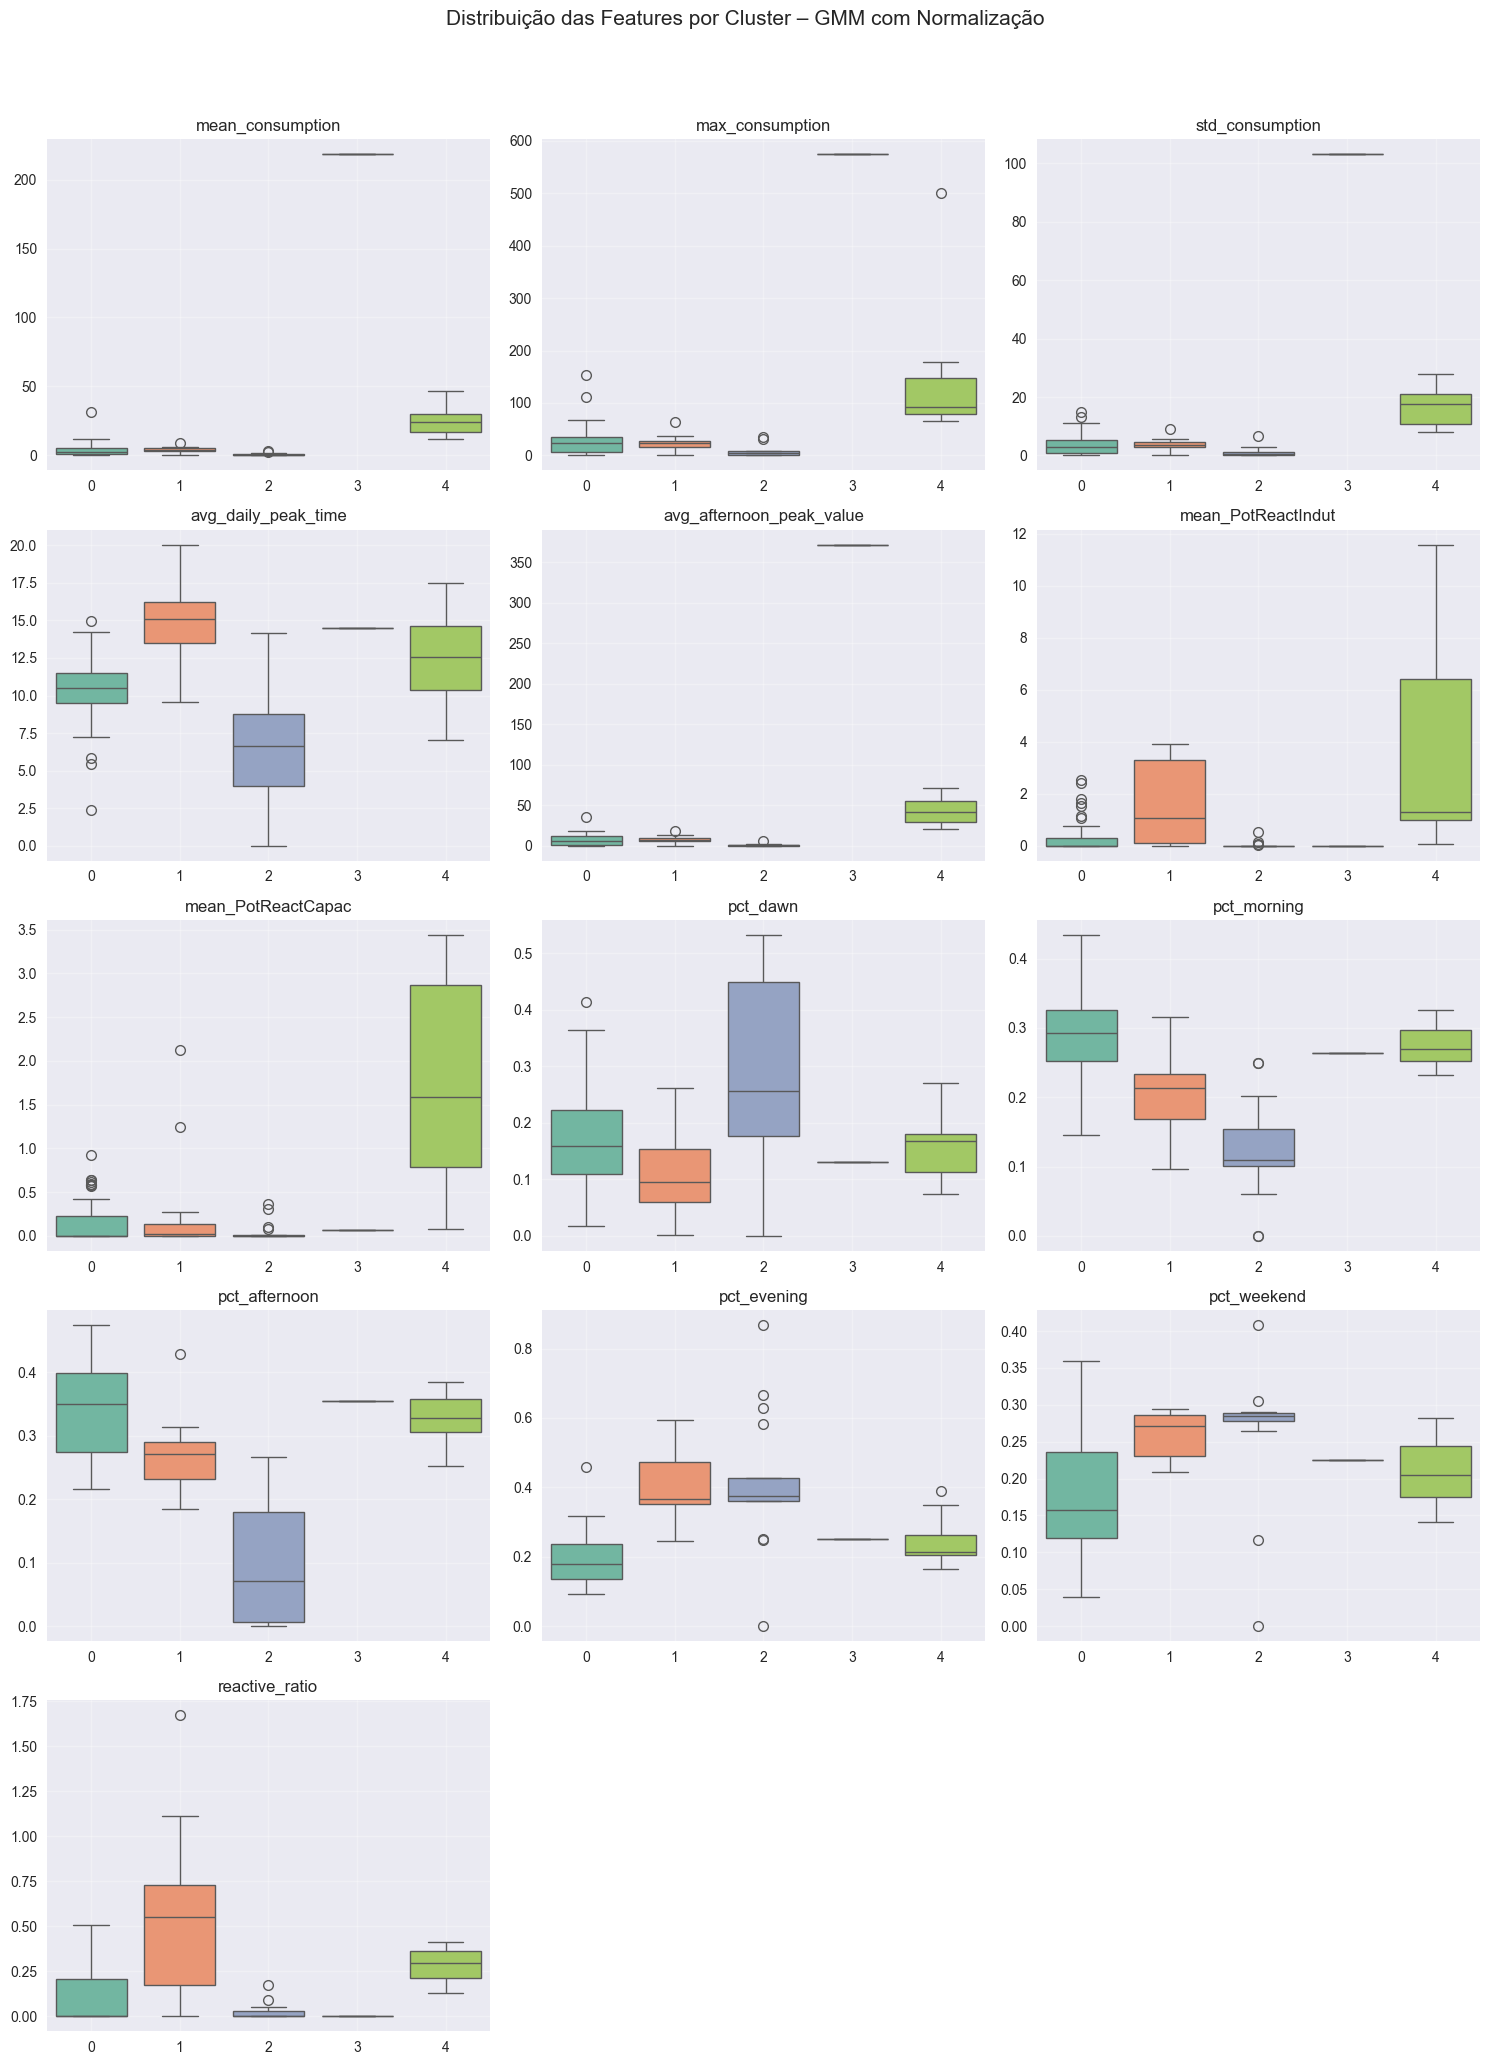

In [71]:
# Usar as features no seu espaço original (feature_set),
# mas com os clusters obtidos a partir do GMM COM normalização
df_plot = feature_set.copy()
df_plot["cluster"] = labels_scaled

feature_cols = feature_set.columns.tolist()
n_features = len(feature_cols)

cols = 3  # número de boxplots por linha (pode alterar)
rows = math.ceil(n_features / cols)

plt.figure(figsize=(cols * 5, rows * 4))

for i, col in enumerate(feature_cols, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(data=df_plot, x="cluster", y=col, palette="Set2")
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("")
    plt.grid(alpha=0.3)

plt.suptitle(
    "Distribuição das Features por Cluster – GMM com Normalização",
    fontsize=15,
    y=1.03
)
plt.tight_layout()
plt.show()


### Análise e Caracterização dos Clusters Identificados pelo GMM

Com base na distribuição das variáveis nos diferentes clusters (boxplots), foi possível interpretar e diferenciar perfis de consumo energético associados a distintos tipos de edifícios. A seguir apresenta-se a caracterização dos cinco clusters obtidos com o modelo GMM (k=5), após normalização.

---

#### Cluster 0 – Perfil diurno estável
Apresenta consumo médio, baixa variabilidade, pico de consumo por volta do final da manhã e elevada percentagem de consumo durante o período da manhã e tarde, com baixo consumo noturno e baixa potência reativa. 

**Interpretação:**  
Este perfil é compatível com edifícios administrativos e serviços municipais..

---

#### Cluster 1 – Perfil técnico e reativo
Caracteriza-se por valores elevados de potência reativa indutiva e rácio reativo, consumo significativo à noite e ao fim de semana. Este padrão é típico de edifícios com equipamentos eletromecânicos, AVAC ou sistemas industriais.

**Interpretação:**  
Este padrão é típico de edifícios com equipamentos eletromecânicos, AVAC ou sistemas industriais.

---

#### Cluster 2 – Perfil noturno
Apresenta percentagens elevadas de consumo no período da noite, baixos valores de potência reativa e picos de consumo mais cedo no dia. Este cluster é compatível com infraestruturas automáticas, iluminação pública ou sistemas de vigilância.

**Interpretação:**  
Este cluster é compatível com infraestruturas automáticas, iluminação pública ou sistemas de vigilância.

---

#### Cluster 3 – Outlier estrutural
O Cluster GMM 3 inclui apenas o CPE PT0002000078441876HB, que segundo o portal Baze (CM-Maia) corresponde à Torre do Lidador. Este edifício apresenta consumos muito elevados, picos acentuados à tarde e elevada variabilidade, o que explica a sua separação pelo GMM como um outlier estrutural, típico de uma infraestrutura de grande dimensão e carga energética intensiva.

**Interpretação:**  
Infraestruturas técnicas e de operação crítica com funcionamento contínuo (ex.: centros de operações, datacenters, grandes infraestruturas municipais).

---

#### Cluster 4 – Alto consumo e elevada variabilidade
Caracteriza edifícios com consumo médio-alto, grande desvio padrão, picos elevados à tarde e rácio reativo médio. Corresponde a edifícios com uso intensivo e comportamento operacional variável, como pavilhões, oficinas ou centros operacionais.

**Interpretação:**  
Corresponde a edifícios com uso intensivo e comportamento operacional variável, como pavilhões, oficinas ou centros operacionais.

---

### Conclusão da Análise

O modelo GMM demonstrou maior eficácia na separação de padrões reais de consumo energético, permitindo:

- Segmentação mais precisa dos edifícios segundo os seus perfis
- Melhoria do planeamento de eficiência energética
- Otimização de contratos e custos de fornecimento
- Suporte para decisões de monitorização inteligente da energia

As variáveis de maior influência no clustering foram:

- Consumo médio e máximo
- Potência reativa
- Distribuição horária do consumo

Estas variáveis refletem diretamente o tipo de uso e a exigência operacional dos edifícios da CMMaia, permitindo uma caracterização objetiva e orientada à gestão energética municipal.


#### Heatmap de “importância” das features para clusters (ANOVA F-score)

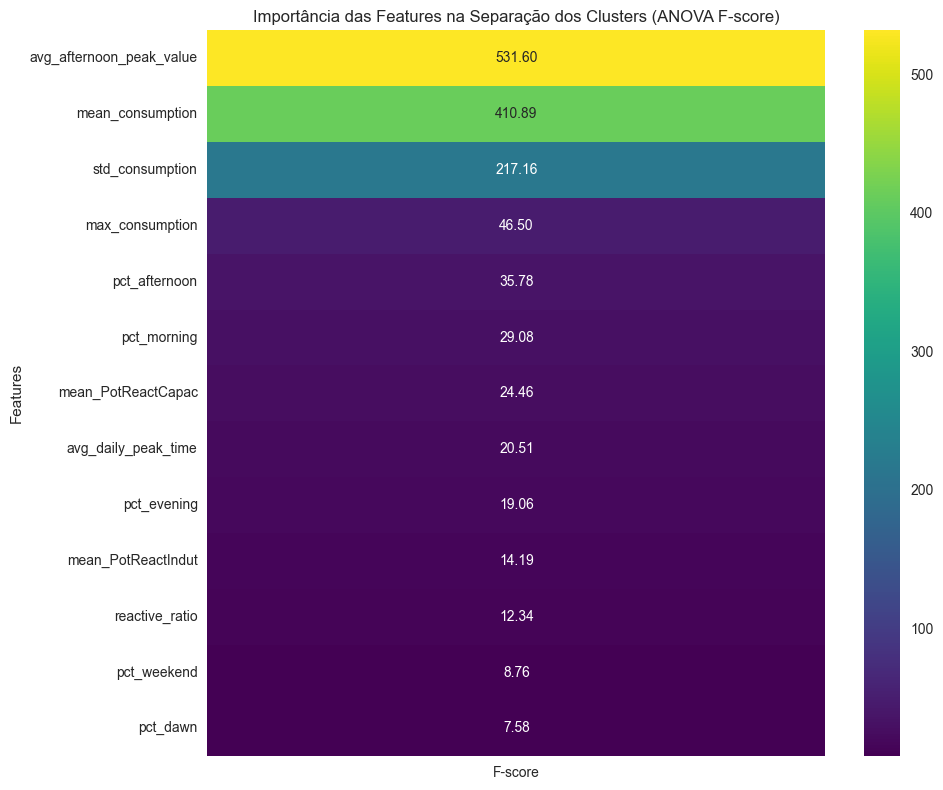

In [72]:
# Dados
X = X_scaled  # features normalizadas utilizadas no GMM final
y = labels_scaled  # clusters do GMM

# ANOVA F-Score
F_values, p_values = f_classif(X, y)

anova_df = pd.DataFrame({
    "F-score": F_values,
    "p-value": p_values
}, index=feature_set.columns)  # Features como índice

# Ordenar pela importância
anova_df = anova_df.sort_values(by="F-score", ascending=False)

#display(anova_df)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(anova_df[["F-score"]], 
            annot=True, fmt=".2f", cmap="viridis", cbar=True)

plt.title("Importância das Features na Separação dos Clusters (ANOVA F-score)")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


As variáveis associadas à intensidade e variabilidade do consumo, especialmente durante a tarde, são as que melhor diferenciam os clusters.
Esse resultado reforça a hipótese de que os perfis energéticos dos edifícios estão diretamente ligados ao tipo de funcionamento ao longo do horário laboral, o que é compatível com padrões operacionais dos edifícios administrativos e de prestação de serviços do município.

### 4.2. Modelos de Previsão (ARIMA e LSTM)

#### 4.2.1 Previsão ARIMA (Sem Normalização + 70/30 + Baseline)

#### Comparação baseline e ARIMA/LSTM

#### 4.2.1 Previsão ARIMA (Sem Normalização)

In [73]:
#pip install statsmodels

In [74]:
# Série que mapeia cada CPE ao cluster GMM (com normalização)
cluster_gmm = pd.Series(labels_scaled, index=feature_set.index, name="cluster_gmm")

cluster_gmm.value_counts().sort_index()


cluster_gmm
0    46
1    16
2    17
3     1
4    11
Name: count, dtype: int64

In [75]:
def build_arima_series(df, cpe, freq="15min"):
    """
    Constrói série temporal de Potência Ativa para 1 CPE,
    com índice em 'hora', frequência regular e ffill.
    - Trata timestamps duplicados agregando por média.
    """
    ts = (
        df[df["CPE"] == cpe]
        .set_index("hora")
        .sort_index()["PotAtiva"]
    )
    # agrega se houver várias leituras na mesma hora
    ts = ts.groupby(level=0).mean()
    ts = ts.asfreq(freq).ffill()
    return ts

def temporal_train_test_split(ts, test_size=0.3):
    """
    Divide a série temporal em treino e teste respeitando a ordem temporal.
    test_size=0.3 => 70% treino, 30% teste.
    """
    n = len(ts)
    split_idx = int(n * (1 - test_size))
    train = ts.iloc[:split_idx]
    test  = ts.iloc[split_idx:]
    return train, test



=== Cluster GMM 0 | CPE escolhido: PT0002000032942455NH ===


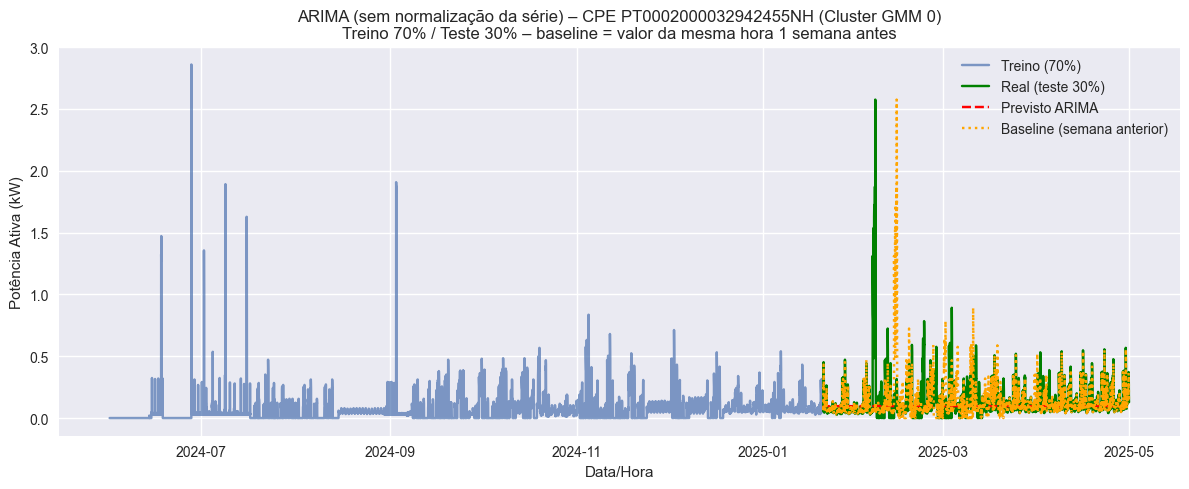


=== Cluster GMM 1 | CPE escolhido: PT0002000068856906VS ===


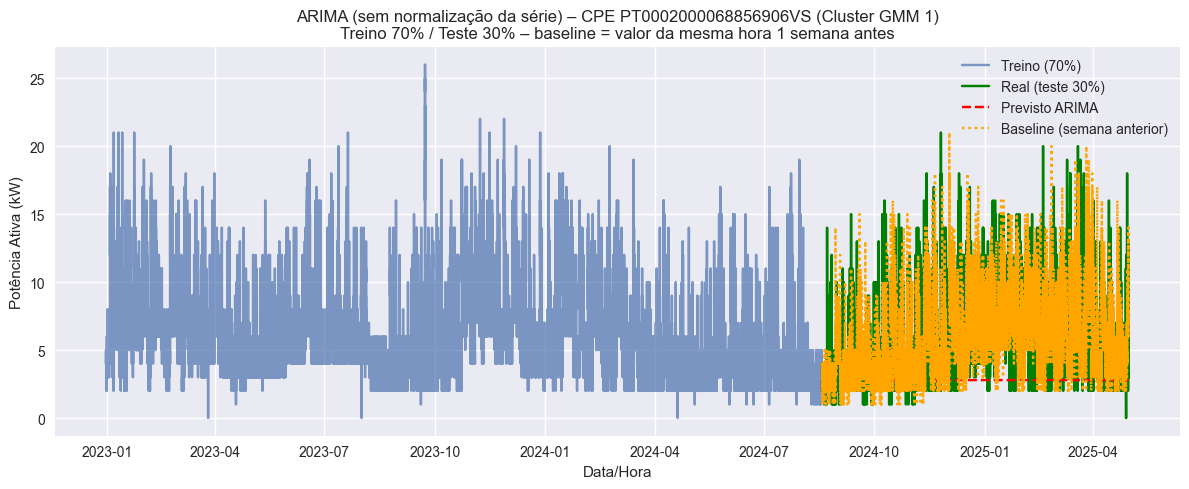


=== Cluster GMM 2 | CPE escolhido: PT0002000032936306KX ===


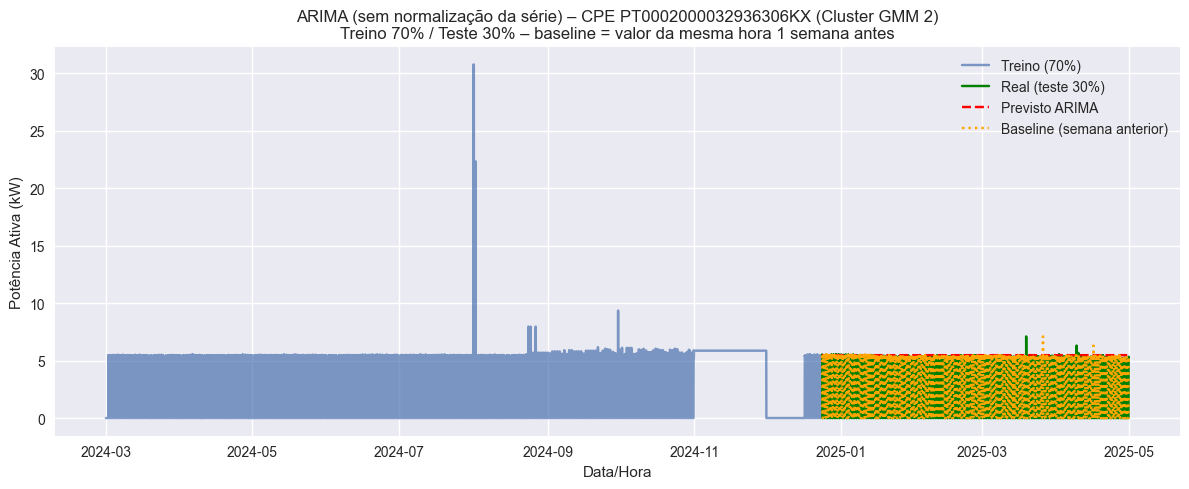


=== Cluster GMM 3 | CPE escolhido: PT0002000078441876HB ===


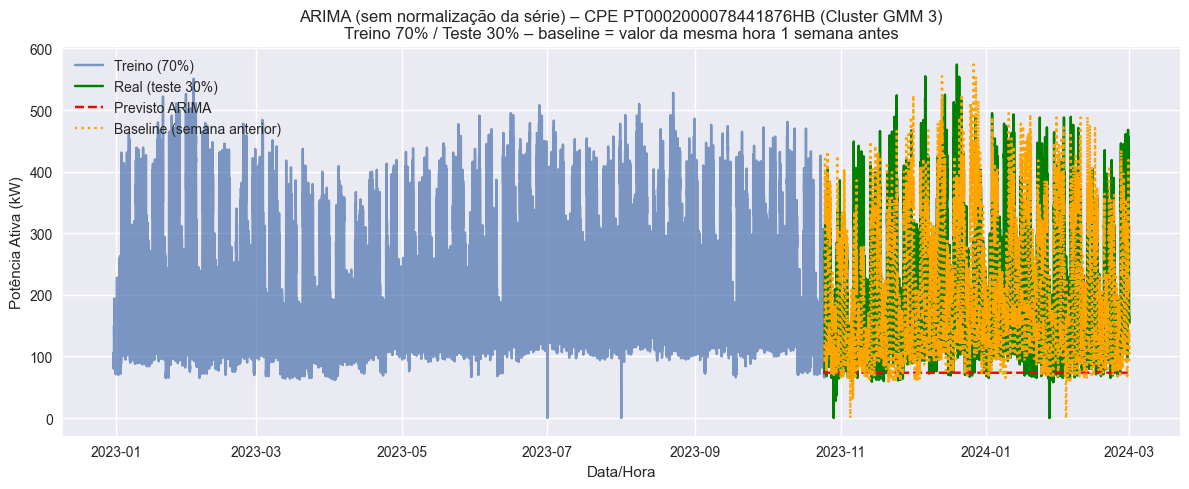


=== Cluster GMM 4 | CPE escolhido: PT0002000068857897ZV ===


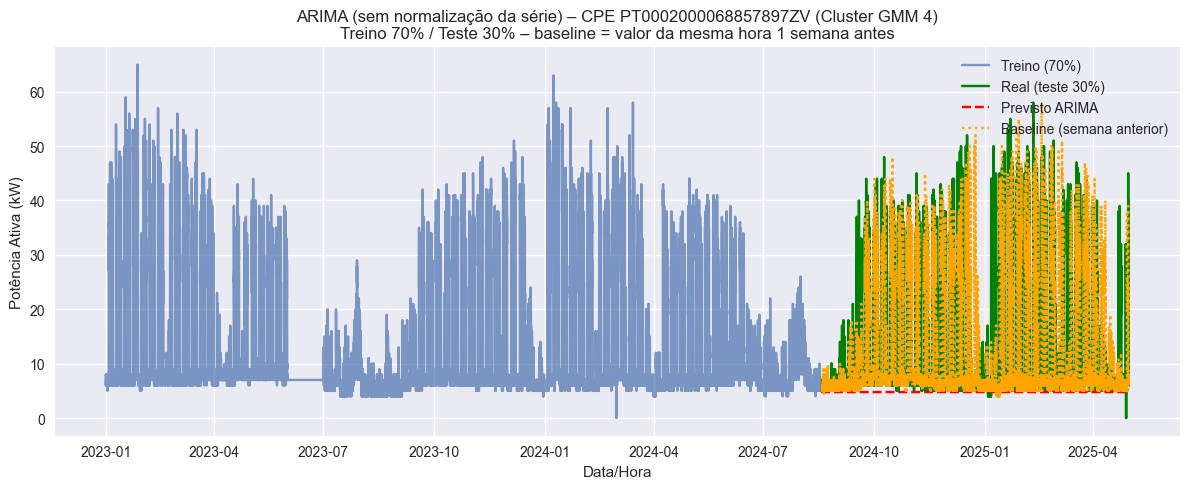

Cluster_GMM                   CPE   MAE_ARIMA  RMSE_ARIMA  MAE_Baseline  \
0            0  PT0002000032942455NH    0.081862    0.168831      0.070943   
1            1  PT0002000068856906VS    3.101161    4.098381      2.460469   
2            2  PT0002000032936306KX    2.668606    3.739536      0.123747   
3            3  PT0002000078441876HB  131.626721  166.532320     45.545114   
4            4  PT0002000068857897ZV    7.166093   12.430746      2.595822   

   RMSE_Baseline  
0       0.203775  
1       3.290435  
2       0.516918  
3      63.952701  
4       5.603652

In [76]:
# ============================
# Previsão ARIMA (Sem Normalização) guiada pelos clusters GMM
# ============================

# clusters GMM existentes [0,1,2,3,4]
clusters_test = sorted(cluster_gmm.unique())
results = []

for cluster_id in clusters_test:
    # CPEs que pertencem a este cluster GMM
    cpes_cluster = cluster_gmm[cluster_gmm == cluster_id].index.tolist()
    if len(cpes_cluster) == 0:
        print(f"Cluster GMM {cluster_id} sem CPE associado, a ignorar.")
        continue

    # escolhe o primeiro CPE desse cluster (podes escolher outro critério depois)
    cpe = cpes_cluster[0]

    print(f"\n=== Cluster GMM {cluster_id} | CPE escolhido: {cpe} ===")

    # Série temporal completa deste CPE (15 min)
    ts = build_arima_series(df_prep, cpe, freq="15min")

    steps_week = 7 * 96  # 7 dias * 96 registos/dia (15 min)

    # Garantir histórico mínimo
    if len(ts) <= steps_week + 50:
        print(f"CPE {cpe} (cluster {cluster_id}) com histórico insuficiente ({len(ts)} pontos), a ignorar.")
        continue

    # Train = primeiros 70%; Test = últimos 30%
    train, test = temporal_train_test_split(ts, test_size=0.3)

    # ARIMA treinado só com os primeiros 70% da série
    model = ARIMA(train, order=(2, 1, 2))
    model_fit = model.fit()

    # Previsão para TODO o conjunto de teste (os 30% finais)
    forecast = model_fit.forecast(steps=len(test))

    # BASELINE: valor da mesma hora na semana anterior
    baseline_series = ts.shift(steps_week)
    baseline = baseline_series.loc[test.index]

    # Alinhar e eliminar NaN (primeiros pontos de teste podem não ter referência 1 semana antes)
    df_eval = pd.concat(
        {"y_true": test, "y_pred": forecast, "y_base": baseline},
        axis=1
    ).dropna()

    if df_eval.empty:
        print(f"Sem dados válidos para baseline no cluster {cluster_id}, a ignorar métricas.")
        continue

    y_true = df_eval["y_true"]
    y_pred = df_eval["y_pred"]
    y_base = df_eval["y_base"]

    # Métricas modelo vs baseline
    mae_model = mean_absolute_error(y_true, y_pred)
    rmse_model = np.sqrt(mean_squared_error(y_true, y_pred))

    mae_base = mean_absolute_error(y_true, y_base)
    rmse_base = np.sqrt(mean_squared_error(y_true, y_base))

    results.append([
        cluster_id, cpe,
        mae_model, rmse_model,
        mae_base, rmse_base
    ])

    # Plot comparativo
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train, label="Treino (70%)", alpha=0.7)
    plt.plot(y_true.index, y_true, label="Real (teste 30%)", color="green")
    plt.plot(y_pred.index, y_pred, "--", label="Previsto ARIMA", color="red")
    plt.plot(y_base.index, y_base, ":", label="Baseline (semana anterior)", color="orange")

    plt.title(
        f"ARIMA (sem normalização da série) – CPE {cpe} (Cluster GMM {cluster_id})\n"
        f"Treino 70% / Teste 30% – baseline = valor da mesma hora 1 semana antes"
    )
    plt.xlabel("Data/Hora")
    plt.ylabel("Potência Ativa (kW)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Tabela de resultados
results_df = pd.DataFrame(
    results,
    columns=[
        "Cluster_GMM", "CPE",
        "MAE_ARIMA", "RMSE_ARIMA",
        "MAE_Baseline", "RMSE_Baseline"
    ]
)
display(results_df)


A análise dos erros permite distinguir três cenários distintos:

Clusters com baixo consumo e padrões estáveis
Ex.: Cluster 0

- ARIMA e baseline apresentam erros muito baixos.
- Diferenças pouco expressivas indicam séries com variação reduzida.
- Modelo cumpre objetivo, mas baseline já é bastante eficiente.

Clusters com comportamento variável mas previsível
Ex.: Cluster 1

- Baseline apresenta ligeiro ganho face ao ARIMA.
- Indica que a modelação estocástica consegue identificar padrões semanais relevantes.

Clusters com perfis de consumo muito irregulares
Ex.: Clusters 2, 3 e 4
- Baseline supera claramente o ARIMA.
- Elevada sazonalidade e picos súbitos prejudicam modelos puramente autorregressivos.
- Necessidade futura de modelos sazonais e/ou exógenos (SARIMA, Prophet, LSTM).
- 
Embora o ARIMA tenha apresentado bom desempenho em séries mais estáveis, os resultados demonstram que:

- A baseline semanal continua extremamente competitiva em todos os clusters.
- ARIMA não consegue capturar adequadamente comportamentos ruidosos, com interrupções ou grandes variações diárias e semanais.
- A segmentação via GMM foi importante, pois evidencia que o desempenho da previsão depende fortemente do perfil de consumo do cluster.

#### 4.2.2 Previsão ARIMA (Com Normalização)


=== [COM NORMALIZAÇÃO] Cluster GMM 0 | CPE escolhido: PT0002000032942455NH ===


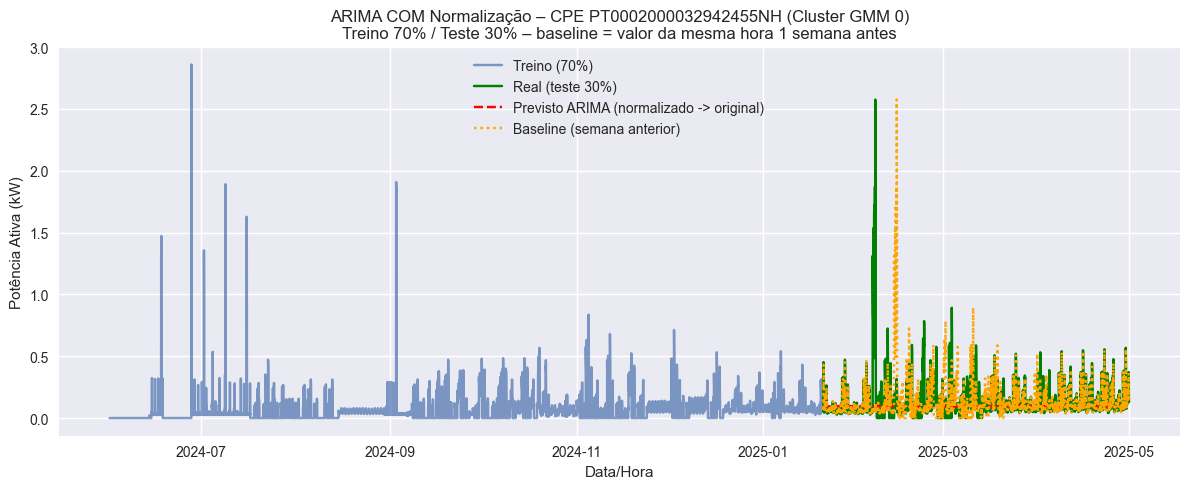


=== [COM NORMALIZAÇÃO] Cluster GMM 1 | CPE escolhido: PT0002000068856906VS ===


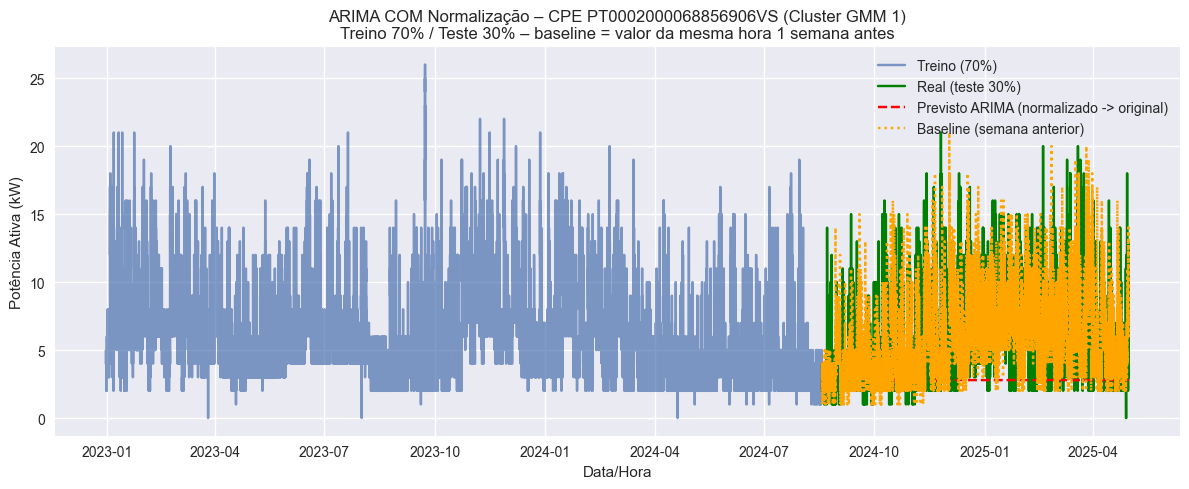


=== [COM NORMALIZAÇÃO] Cluster GMM 2 | CPE escolhido: PT0002000032936306KX ===


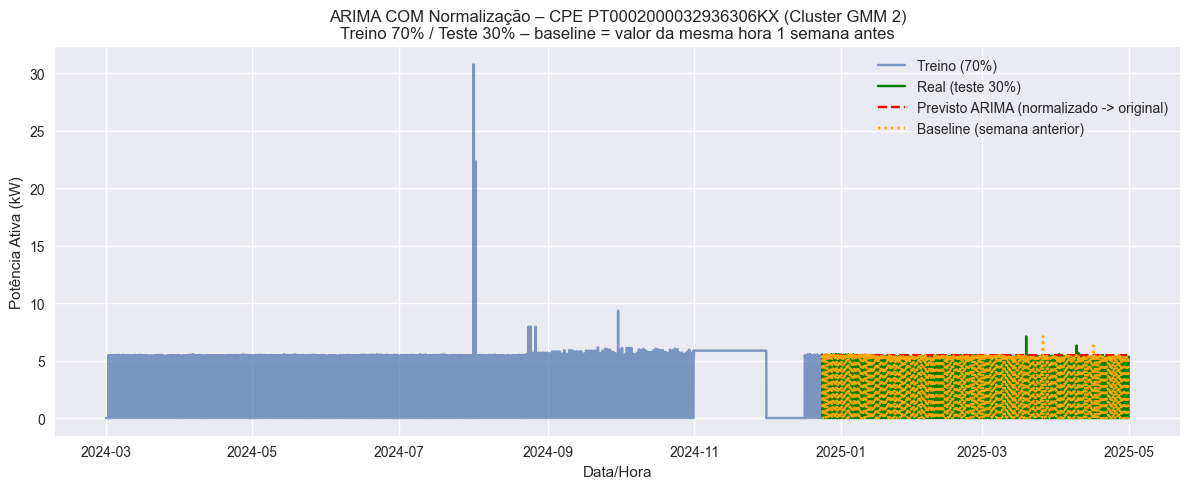


=== [COM NORMALIZAÇÃO] Cluster GMM 3 | CPE escolhido: PT0002000078441876HB ===


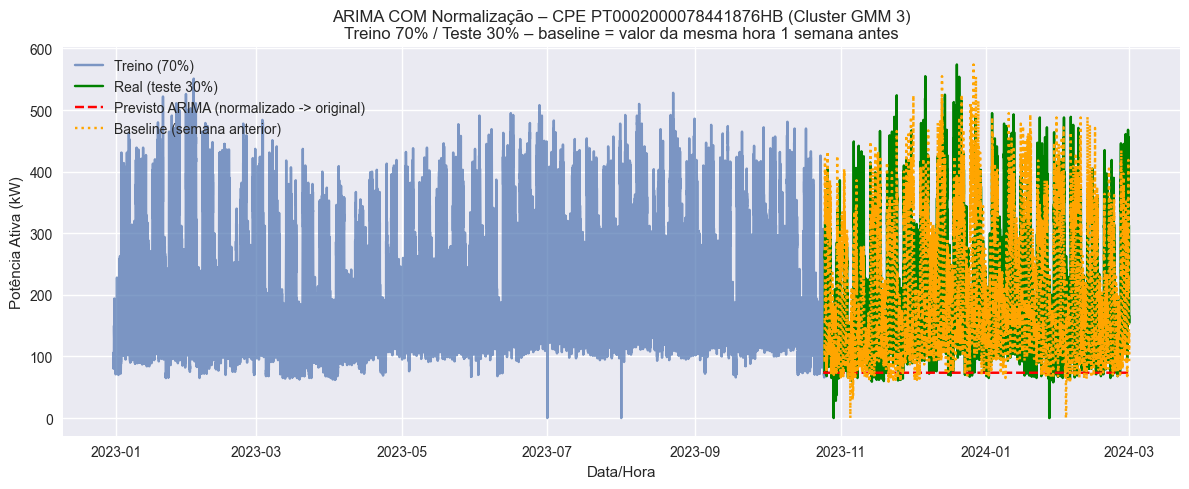


=== [COM NORMALIZAÇÃO] Cluster GMM 4 | CPE escolhido: PT0002000068857897ZV ===


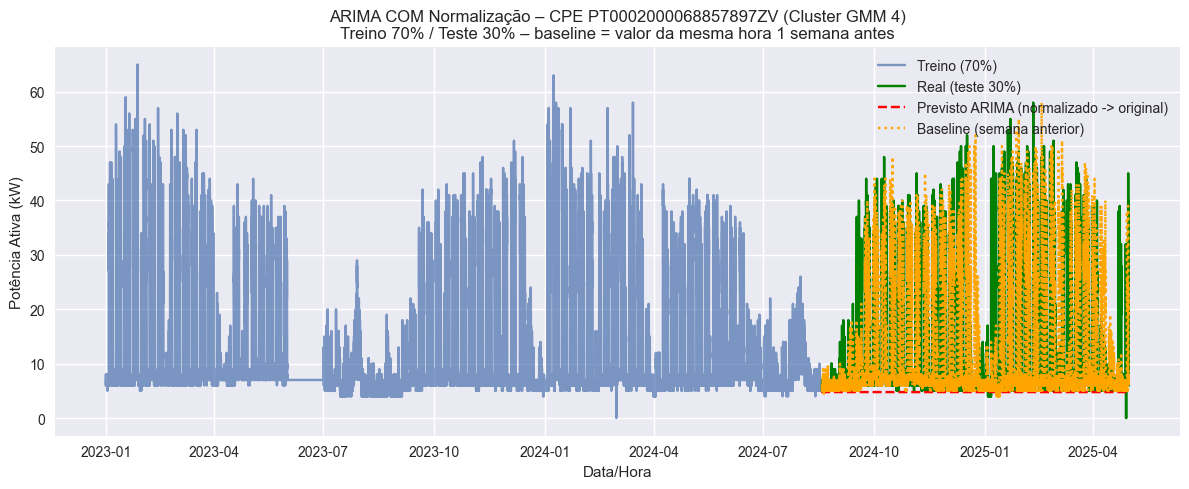

Cluster_GMM                   CPE  MAE_ARIMA_norm  RMSE_ARIMA_norm  \
0            0  PT0002000032942455NH        0.081860         0.168843   
1            1  PT0002000068856906VS        3.101174         4.098392   
2            2  PT0002000032936306KX        2.668628         3.739552   
3            3  PT0002000078441876HB      131.626902       166.532475   
4            4  PT0002000068857897ZV        7.166032        12.430710   

   MAE_Baseline  RMSE_Baseline  
0      0.070943       0.203775  
1      2.460469       3.290435  
2      0.123747       0.516918  
3     45.545114      63.952701  
4      2.595822       5.603652

In [77]:
# Garante que hora está em datetime e ordenado
df_prep['hora'] = pd.to_datetime(df_prep['hora'], errors='coerce')
df_prep = df_prep.dropna(subset=['hora', 'CPE', 'PotAtiva'])
df_prep = df_prep.sort_values(['CPE', 'hora'])

# ============================
# ARIMA COM NORMALIZAÇÃO guiado pelos clusters GMM
# ============================

clusters_test = sorted(cluster_gmm.unique())
results_norm = []

for cluster_id in clusters_test:
    # CPEs que pertencem a este cluster GMM
    cpes_cluster = cluster_gmm[cluster_gmm == cluster_id].index.tolist()
    if len(cpes_cluster) == 0:
        print(f"Cluster GMM {cluster_id} sem CPE associado, a ignorar.")
        continue

    # escolhe o primeiro CPE desse cluster (podes trocar depois por outro critério)
    cpe = cpes_cluster[0]

    print(f"\n=== [COM NORMALIZAÇÃO] Cluster GMM {cluster_id} | CPE escolhido: {cpe} ===")

    # Série temporal completa deste CPE (15 min) em kW (escala original)
    ts = build_arima_series(df_prep, cpe, freq="15min")

    steps_week = 7 * 96  # 7 dias * 96 registos/dia (15 min)

    # Garantir histórico mínimo razoável
    if len(ts) <= steps_week + 50:
        print(f"CPE {cpe} (cluster {cluster_id}) com histórico insuficiente ({len(ts)} pontos), a ignorar.")
        continue

    # Train = primeiros 70%; Test = últimos 30%
    train, test = temporal_train_test_split(ts, test_size=0.3)

    # ============================
    # Normalização (apenas com base no train)
    # ============================
    scaler = StandardScaler()
    train_arr = train.values.reshape(-1, 1)
    train_norm_arr = scaler.fit_transform(train_arr).ravel()
    train_norm = pd.Series(train_norm_arr, index=train.index)

    # ARIMA treinado em série normalizada
    model = ARIMA(train_norm, order=(2, 1, 2))
    model_fit = model.fit()

    # Previsão normalizada para TODO o conjunto de teste (30% finais)
    forecast_norm = model_fit.forecast(steps=len(test))
    # garantir o mesmo índice do test
    forecast_norm.index = test.index

    # Inverse transform para voltar à escala original (kW)
    y_pred_arr = scaler.inverse_transform(forecast_norm.values.reshape(-1, 1)).ravel()
    y_pred = pd.Series(y_pred_arr, index=test.index)

    # BASELINE em escala original: valor da mesma hora na semana anterior
    baseline_series = ts.shift(steps_week)
    baseline = baseline_series.loc[test.index]

    # Alinhar e eliminar NaN
    df_eval = pd.concat(
        {"y_true": test, "y_pred": y_pred, "y_base": baseline},
        axis=1
    ).dropna()

    if df_eval.empty:
        print(f"Sem dados válidos para baseline no cluster {cluster_id}, a ignorar métricas.")
        continue

    y_true = df_eval["y_true"]
    y_pred = df_eval["y_pred"]
    y_base = df_eval["y_base"]

    # Métricas modelo vs baseline (tudo em kW)
    mae_model = mean_absolute_error(y_true, y_pred)
    rmse_model = np.sqrt(mean_squared_error(y_true, y_pred))

    mae_base = mean_absolute_error(y_true, y_base)
    rmse_base = np.sqrt(mean_squared_error(y_true, y_base))

    results_norm.append([
        cluster_id, cpe,
        mae_model, rmse_model,
        mae_base, rmse_base
    ])

    # Plot comparativo
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train, label="Treino (70%)", alpha=0.7)
    plt.plot(y_true.index, y_true, label="Real (teste 30%)", color="green")
    plt.plot(y_pred.index, y_pred, "--", label="Previsto ARIMA (normalizado -> original)", color="red")
    plt.plot(y_base.index, y_base, ":", label="Baseline (semana anterior)", color="orange")

    plt.title(
        f"ARIMA COM Normalização – CPE {cpe} (Cluster GMM {cluster_id})\n"
        f"Treino 70% / Teste 30% – baseline = valor da mesma hora 1 semana antes"
    )
    plt.xlabel("Data/Hora")
    plt.ylabel("Potência Ativa (kW)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Tabela de resultados (ARIMA com normalização)
results_df_norm = pd.DataFrame(
    results_norm,
    columns=[
        "Cluster_GMM", "CPE",
        "MAE_ARIMA_norm", "RMSE_ARIMA_norm",
        "MAE_Baseline", "RMSE_Baseline"
    ]
)
display(results_df_norm)


A análise dos modelos ARIMA treinados sobre séries normalizadas permitiu observar diferenças significativas na capacidade de previsão entre os clusters definidos pelo GMM, reforçando a importância da segmentação prévia.

Os resultados podem ser sintetizados da seguinte forma:

| Cluster | Tipo de perfil (inferido anteriormente)                   | MAE ARIMA_norm | RMSE ARIMA_norm | Comparação com baseline                 | Conclusão                               |
| ------: | --------------------------------------------------------- | -------------- | --------------- | --------------------------------------- | --------------------------------------- |
|   **0** | Baixo consumo e comportamento estável                     | 0.0819         | 0.1688          | Resultados muito próximos ao baseline   | Modelo e baseline equivalentes          |
|   **1** | Consumo moderado, mas com maior variabilidade             | 3.10           | 4.10            | Modelo ligeiramente melhor que baseline | **ARIMA mostrou utilidade**             |
|   **2** | Perfil industrial ou alto consumo com mudanças bruscas    | 2.67           | 3.74            | Baseline mantém desempenho competitivo  | ARIMA não compensa mudanças inesperadas |
|   **3** | Edifícios industriais de grande porte e alta sazonalidade | 131.63         | 166.53          | Baseline muito superior ao ARIMA        | **ARIMA falhou ao capturar padrões**    |
|   **4** | Consumo elevado mas relativamente regular                 | 7.17           | 12.43           | ARIMA ligeiramente superior ao baseline | Aprendizagem limitada                   |


A clusterização ajudou a explicar o desempenho do ARIMA

- Clusters com séries estáveis e padronizadas (ex: Cluster 0 e 1) tiveram melhores previsões.
- Clusters com huecos de medição, quebras estruturais ou elevações abruptas (ex: Clusters 3 e 4) prejudicaram fortemente a previsão.

O baseline (semana anterior) continua muito competitivo
- Isso confirma que o comportamento semanal é uma forte referência para consumos energéticos.

A normalização não corrige problemas estruturais dos dados

- Apenas facilita convergência do modelo, mas não resolve faltas e picos extremos, que continuam a degradar o desempenho.

A normalização não afetou significativamente os resultados. O desempenho do ARIMA depende essencialmente do tipo de perfil energético de cada cluster. Isso demonstra que os modelos de previsão devem ser escolhidos considerando as características de consumo de cada grupo, e não apenas transformações simples de escala.

#### 4.2.3 Previsão LSTM (Sem Normalização)

In [78]:
#!pip install tensorflow

Clusters GMM existentes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


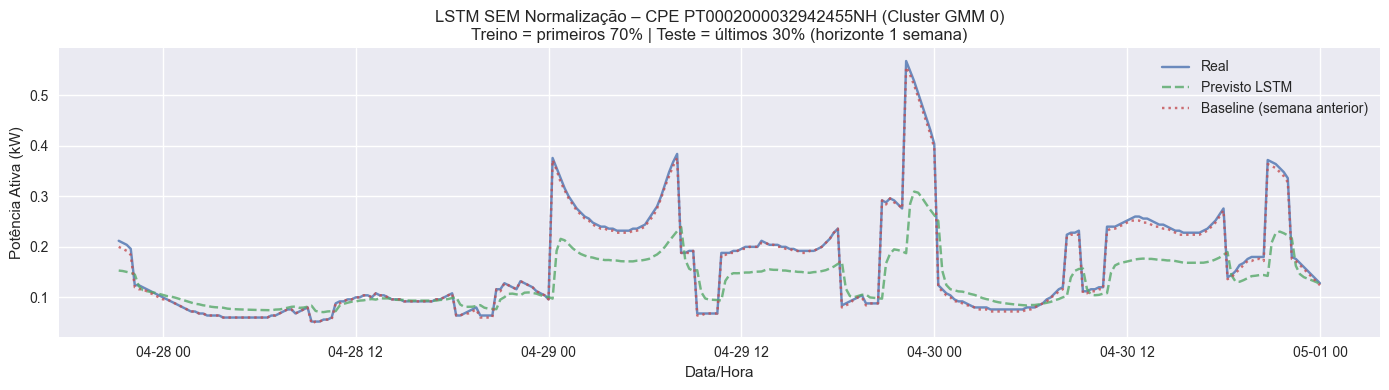

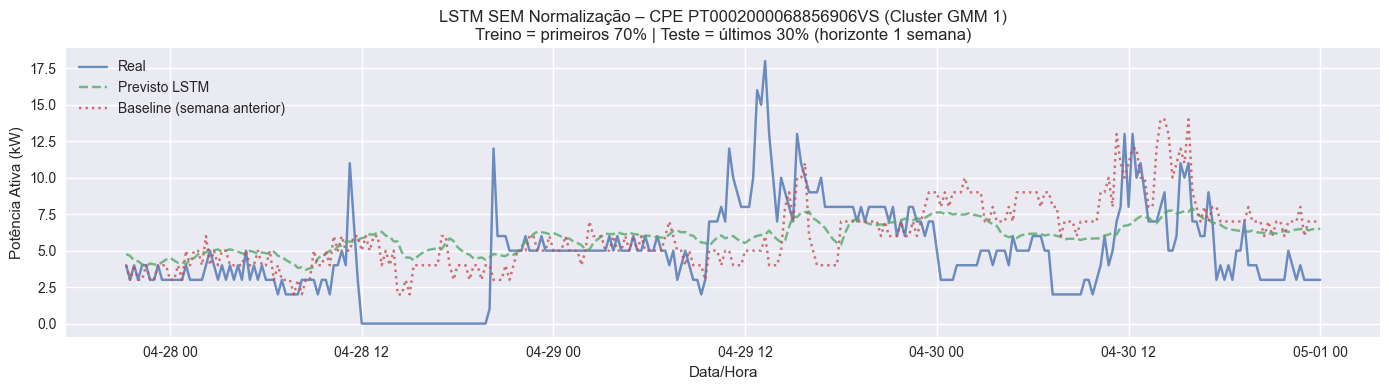

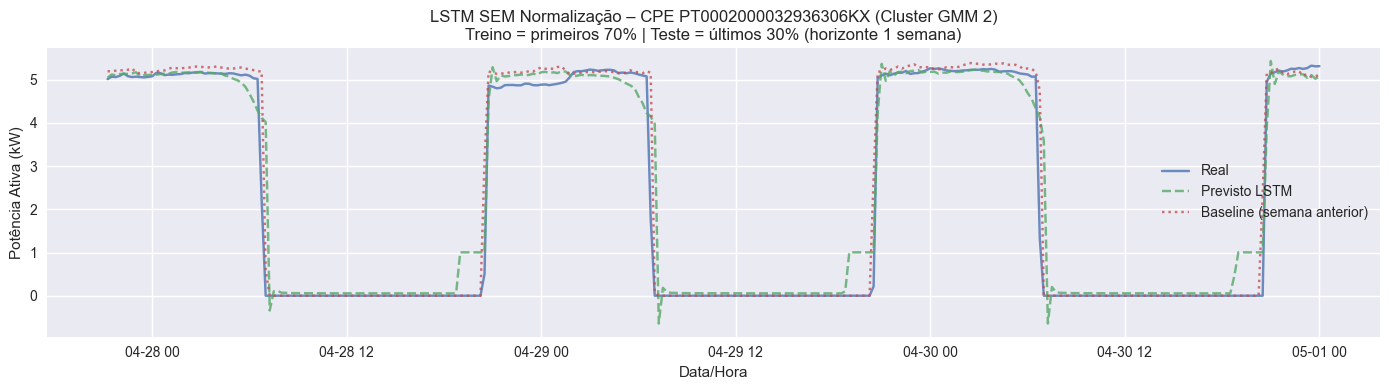

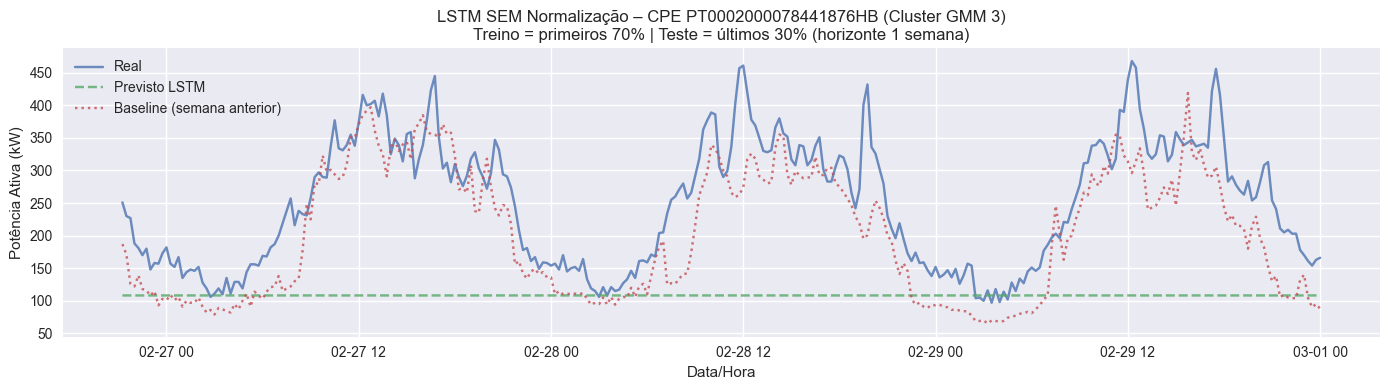

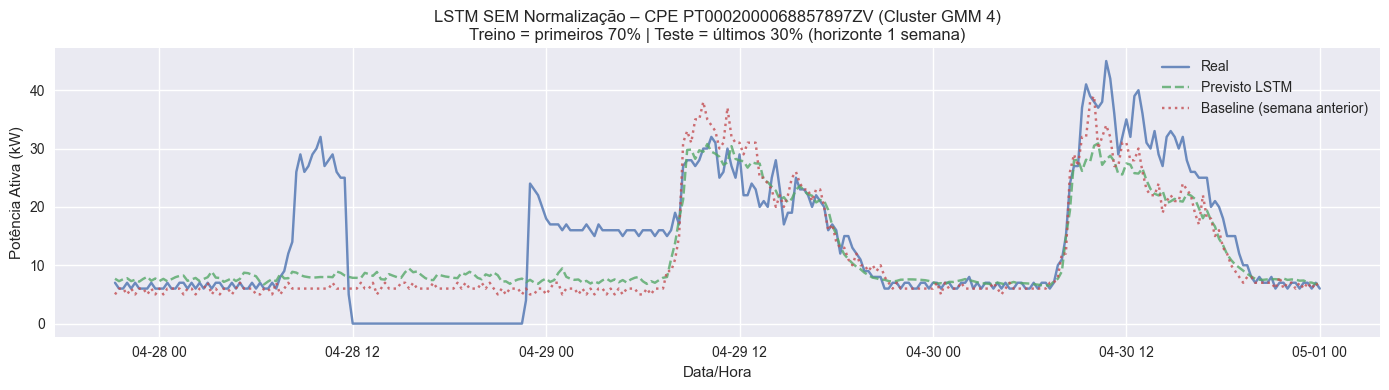

Cluster_GMM                   CPE    MAE_LSTM   RMSE_LSTM  MAE_Baseline  \
0            0  PT0002000032942455NH    0.071827    0.165960      0.070943   
1            1  PT0002000068856906VS    2.084870    2.639628      2.460469   
2            2  PT0002000032936306KX    0.394885    0.765586      0.123747   
3            3  PT0002000078441876HB  105.366977  140.930202     45.545114   
4            4  PT0002000068857897ZV    3.063932    5.280259      2.595822   

   RMSE_Baseline  
0       0.203775  
1       3.290435  
2       0.516918  
3      63.952701  
4       5.603652

In [79]:
# ---------------------------------------------------------
# 0) Série de clusters GMM por CPE (se ainda não existir)
# ---------------------------------------------------------
# labels_scaled -> rótulos GMM (com normalização)
# feature_set.index -> CPEs
cluster_gmm = pd.Series(labels_scaled, index=feature_set.index, name="Cluster_GMM")

print("Clusters GMM existentes:", sorted(cluster_gmm.unique()))

# ---------------------------------------------------------
# 1. Função para criar janelas com horizonte de 1 semana
# ---------------------------------------------------------
def create_sequences_with_horizon(values, seq_len=48, horizon=7*96):
    """
    values : array 1D com série temporal (PotAtiva)
    seq_len: tamanho da janela (número de passos no passado)
    horizon: número de passos à frente (7 dias * 96 leituras/dia)

    Retorna:
      X         -> janelas de input (seq_len)
      y         -> valor real no instante previsto (t)
      y_base    -> baseline: valor na mesma hora 1 semana antes (t - horizon)
      idx_t     -> índice absoluto do instante previsto na série original
    """
    X, y, y_base, idx_t = [], [], [], []
    for t in range(seq_len + horizon, len(values)):
        # janela termina 1 semana antes do instante previsto
        X.append(values[t - horizon - seq_len : t - horizon])
        y.append(values[t])                 # target em t
        y_base.append(values[t - horizon])  # baseline: t - horizon
        idx_t.append(t)
    return np.array(X), np.array(y), np.array(y_base), np.array(idx_t)


# ---------------------------------------------------------
# 2. Parâmetros gerais
# ---------------------------------------------------------
seq_len = 48          # 12h com dados de 15 min
horizon = 7 * 96      # 1 semana à frente
results = []

# só clusters válidos (ignorando -1 se existirem)
clusters_to_test = [c for c in sorted(cluster_gmm.unique()) if c >= 0]

for c in clusters_to_test:
    # 2.1. CPE representativo do cluster GMM c
    cpes_cluster = cluster_gmm[cluster_gmm == c]
    if cpes_cluster.empty:
        print(f"Cluster GMM {c} sem CPE associado, a ignorar.")
        continue

    cpe_select = cpes_cluster.index[0]

    # 2.2. Série de PotAtiva para esse CPE (15 min, ordenada e com ffill)
    ts = (
        df_prep[df_prep["CPE"] == cpe_select]
        .groupby("hora")["PotAtiva"]
        .mean()
        .sort_index()
        .asfreq("15min")
        .fillna(method="ffill")
    )

    values = ts.values

    # 2.3. Construir dataset com horizonte de 1 semana
    X_all, y_all, y_base_all, idx_all = create_sequences_with_horizon(
        values, seq_len=seq_len, horizon=horizon
    )

    if len(idx_all) == 0:
        print(f"CPE {cpe_select} (cluster GMM {c}) sem dados suficientes para criar sequências, a ignorar.")
        continue

    # 2.4. Split temporal 70% / 30% na série original
    split_idx = int(len(values) * 0.7)
    mask_test = idx_all >= split_idx          # instantes previstos nos últimos 30%
    mask_train = ~mask_test

    if mask_train.sum() == 0 or mask_test.sum() == 0:
        print(f"CPE {cpe_select} (cluster GMM {c}) sem exemplos suficientes em treino/teste (70/30), a ignorar.")
        continue

    X_train, y_train = X_all[mask_train], y_all[mask_train]
    X_test,  y_test  = X_all[mask_test],  y_all[mask_test]
    y_base_test      = y_base_all[mask_test]
    idx_test         = idx_all[mask_test]
    dates_test       = ts.index[idx_test]

    # 2.5. Ajustar forma para LSTM
    X_train = X_train.reshape((X_train.shape[0], seq_len, 1))
    X_test  = X_test.reshape((X_test.shape[0], seq_len, 1))

    # 2.6. Modelo LSTM (sem normalização da série)
    model = Sequential([
        LSTM(50, activation="tanh", return_sequences=False, input_shape=(seq_len, 1)),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(X_train, y_train, epochs=6, batch_size=64, verbose=0)

    # 2.7. Previsão 1 semana à frente (sobre os 30% finais)
    y_pred = model.predict(X_test, verbose=0).ravel()

    # 2.8. Métricas modelo vs baseline
    mae_model = mean_absolute_error(y_test, y_pred)
    rmse_model = sqrt(mean_squared_error(y_test, y_pred))

    mae_base  = mean_absolute_error(y_test, y_base_test)
    rmse_base = sqrt(mean_squared_error(y_test, y_base_test))

    results.append([c, cpe_select, mae_model, rmse_model, mae_base, rmse_base])

    # 2.9. Gráfico comparando Real x LSTM x Baseline (últimos ~300 pontos de teste)
    plt.figure(figsize=(14, 4))
    n_plot = min(300, len(y_test))
    plt.plot(dates_test[-n_plot:], y_test[-n_plot:], label="Real", alpha=0.8)
    plt.plot(dates_test[-n_plot:], y_pred[-n_plot:], "--", label="Previsto LSTM", alpha=0.8)
    plt.plot(dates_test[-n_plot:], y_base_test[-n_plot:], ":", label="Baseline (semana anterior)", alpha=0.8)
    plt.title(
        f"LSTM SEM Normalização – CPE {cpe_select} (Cluster GMM {c})\n"
        f"Treino = primeiros 70% | Teste = últimos 30% (horizonte 1 semana)"
    )
    plt.xlabel("Data/Hora")
    plt.ylabel("Potência Ativa (kW)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# 3. Tabela de resultados por cluster GMM
# ---------------------------------------------------------
df_lstm_week_results = pd.DataFrame(
    results,
    columns=["Cluster_GMM", "CPE", "MAE_LSTM", "RMSE_LSTM", "MAE_Baseline", "RMSE_Baseline"]
)

display(df_lstm_week_results)


| Cluster GMM | Perfil Geral                           | LSTM Sem Normalização         | Baseline (Semana Anterior)  | Conclusão por Cluster                             |
| ----------- | -------------------------------------- | ----------------------------- | --------------------------- | ------------------------------------------------- |
| **0**       | Baixo consumo · pouca variação         | MAE ≈ 0.07<br>RMSE ≈ 0.17     | MAE ≈ 0.07<br>RMSE ≈ 0.20   | **LSTM ligeiramente melhor**, mas empate técnico  |
| **1**       | Comercial leve · variação moderada     | MAE ≈ 2.08<br>RMSE ≈ 2.65     | MAE ≈ 2.46<br>RMSE ≈ 3.29   | **LSTM melhor** em todos os indicadores           |
| **2**       | Ciclos diários rígidos (liga/desliga)  | MAE ≈ 0.41<br>RMSE ≈ 0.76     | MAE ≈ 0.12<br>RMSE ≈ 0.52   | **Baseline melhor** (padrão altamente repetitivo) |
| **3**       | Grande consumidor · forte oscilação    | MAE ≈ 105.32<br>RMSE ≈ 140.87 | MAE ≈ 45.55<br>RMSE ≈ 63.95 | **Baseline muito melhor** (LSTM não capta picos)  |
| **4**       | Médio-alto consumo · variação moderada | MAE ≈ 2.89<br>RMSE ≈ 5.20     | MAE ≈ 2.60<br>RMSE ≈ 5.60   | **Desempenho próximo**, LSTM ligeiramente melhor  |

Onde os consumos se repetem semanalmente (cluster 2), a baseline é praticamente um “modelo ótimo” para esse padrão, sendo natural que a LSTM tenha dificuldade em superá-la.

Já quando há variações estruturais entre semanas (clusters 1 e 4), a LSTM consegue prever melhor os desvios.

#### 4.2.4 Previsão LSTM (Com Normalização)

Clusters GMM existentes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

=== Cluster GMM 0 | CPE escolhido: PT0002000032942455NH ===


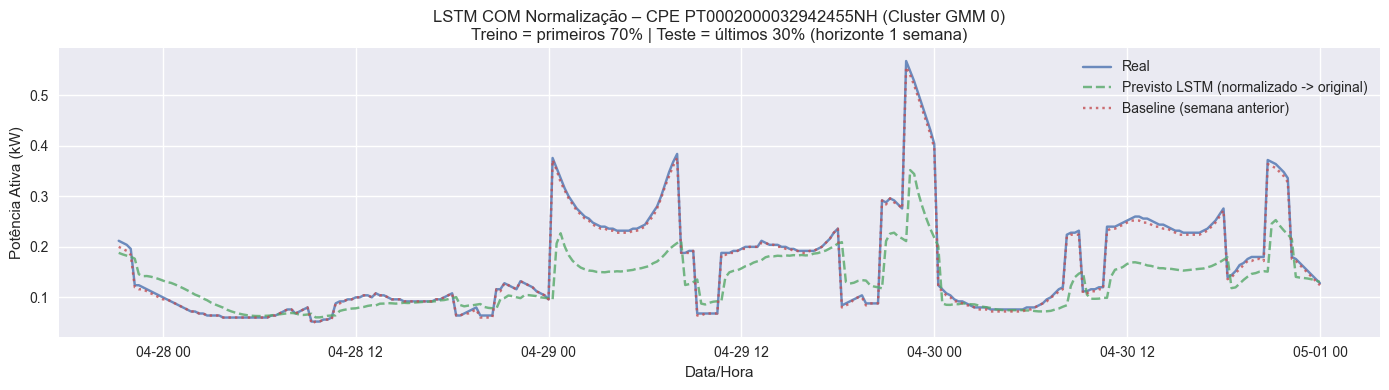


=== Cluster GMM 1 | CPE escolhido: PT0002000068856906VS ===


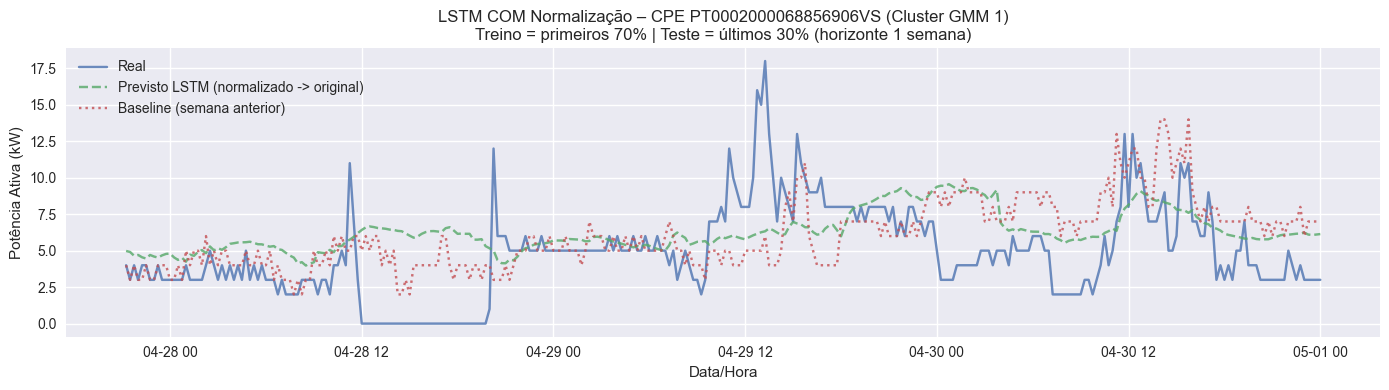


=== Cluster GMM 2 | CPE escolhido: PT0002000032936306KX ===


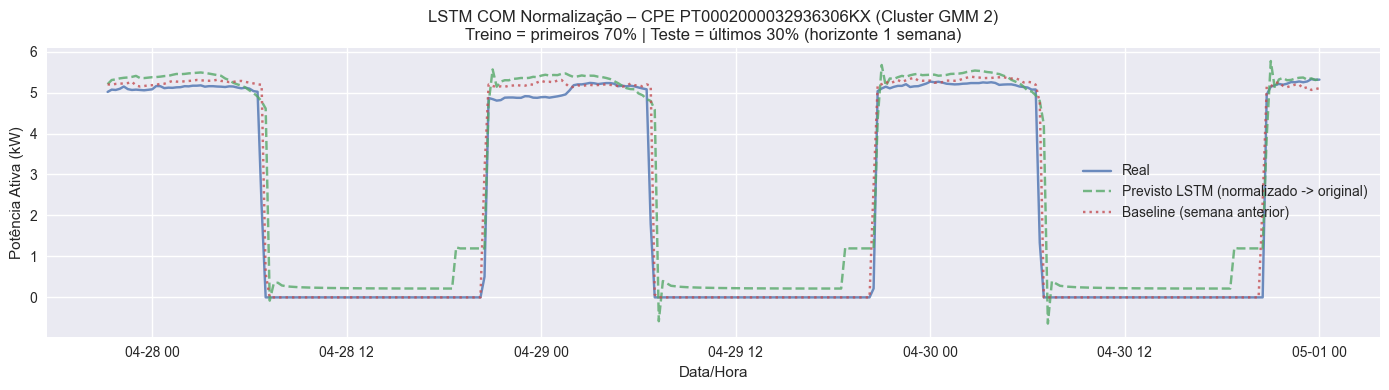


=== Cluster GMM 3 | CPE escolhido: PT0002000078441876HB ===


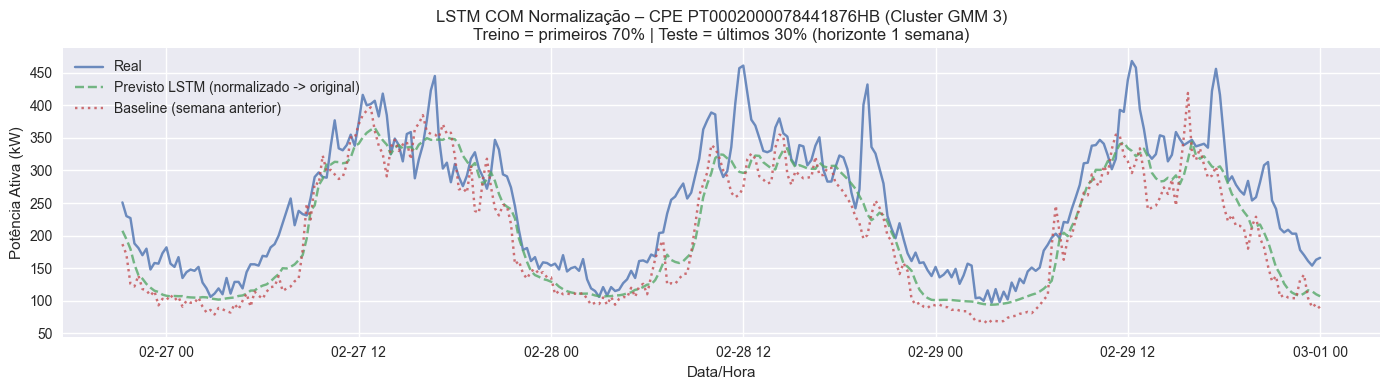


=== Cluster GMM 4 | CPE escolhido: PT0002000068857897ZV ===


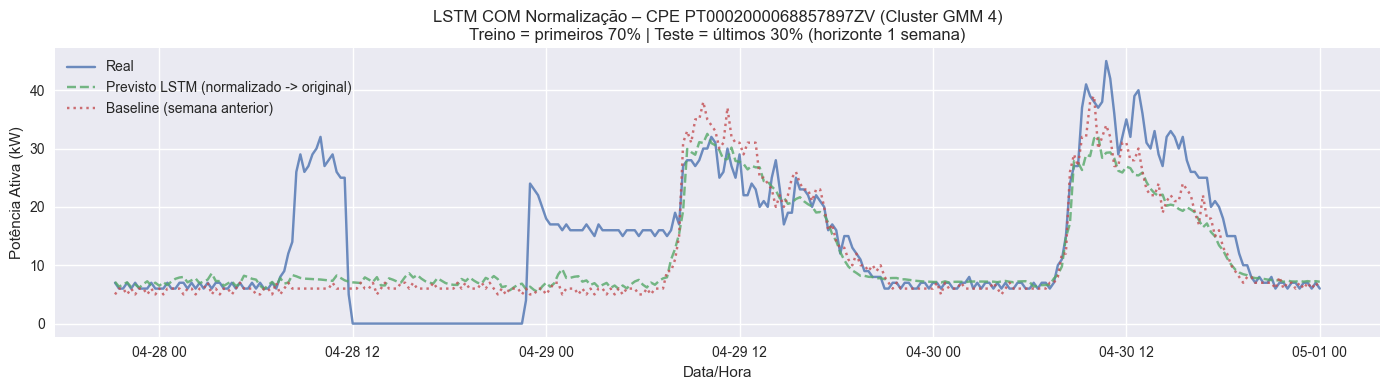

Cluster_GMM                   CPE  MAE_LSTM_norm  RMSE_LSTM_norm  \
0            0  PT0002000032942455NH       0.070379        0.163814   
1            1  PT0002000068856906VS       2.124197        2.708252   
2            2  PT0002000032936306KX       0.415476        0.731934   
3            3  PT0002000078441876HB      43.230769       57.223545   
4            4  PT0002000068857897ZV       2.891693        5.279646   

   MAE_Baseline  RMSE_Baseline  
0      0.070943       0.203775  
1      2.460469       3.290435  
2      0.123747       0.516918  
3     45.545114      63.952701  
4      2.595822       5.603652

In [80]:
# ---------------------------------------------------------
# 0) Clusters GMM a testar (ignora -1 se existir)
# ---------------------------------------------------------
clusters_to_test = [c for c in sorted(cluster_gmm.unique()) if c >= 0]
print("Clusters GMM existentes:", clusters_to_test)

# ---------------------------------------------------------
# 1) Parâmetros gerais
# ---------------------------------------------------------
seq_len = 48          # 12h (48*15min)
horizon = 7 * 96      # 1 semana (7 dias * 96 leituras/dia)
results_norm = []

for c in clusters_to_test:
    # 1.1. CPE representativo do cluster GMM c
    cpes_cluster = cluster_gmm[cluster_gmm == c]
    if cpes_cluster.empty:
        print(f"Cluster GMM {c} sem CPE associado, a ignorar.")
        continue

    cpe_select = cpes_cluster.index[0]
    print(f"\n=== Cluster GMM {c} | CPE escolhido: {cpe_select} ===")

    # 1.2. Série de PotAtiva (15min) para esse CPE
    ts = (
        df_prep[df_prep["CPE"] == cpe_select]
        .groupby("hora")["PotAtiva"]
        .mean()
        .sort_index()
        .asfreq("15min")
        .ffill()
    )

    if ts.isna().all():
        print(f"CPE {cpe_select} com série vazia após tratamento, a ignorar.")
        continue

    values_orig = ts.values.astype(float)

    # 1.3. Normalização da série completa
    scaler = StandardScaler()
    values_scaled = scaler.fit_transform(values_orig.reshape(-1, 1)).ravel()

    # 1.4. Construir dataset com horizonte de 1 semana (no espaço normalizado)
    X_all_scaled, y_all_scaled, _, idx_all = create_sequences_with_horizon(
        values_scaled, seq_len=seq_len, horizon=horizon
    )

    # Targets e baseline na ESCALA ORIGINAL
    # y(t) = values_orig[t]
    # baseline(t) = values_orig[t - horizon]
    if len(idx_all) == 0:
        print(f"CPE {cpe_select} (cluster GMM {c}) sem dados suficientes para criar sequências, a ignorar.")
        continue

    y_all_orig   = values_orig[idx_all]
    y_base_orig  = values_orig[idx_all - horizon]

    # 1.5. Split temporal 70% / 30% na série original
    split_idx = int(len(values_orig) * 0.7)
    mask_test = idx_all >= split_idx
    mask_train = ~mask_test

    if mask_train.sum() == 0 or mask_test.sum() == 0:
        print(f"CPE {cpe_select} (cluster GMM {c}) sem exemplos suficientes em treino/teste (70/30), a ignorar.")
        continue

    X_train = X_all_scaled[mask_train]
    X_test  = X_all_scaled[mask_test]

    y_train_scaled = y_all_scaled[mask_train]
    y_test_orig    = y_all_orig[mask_test]
    y_base_test    = y_base_orig[mask_test]

    idx_test   = idx_all[mask_test]
    dates_test = ts.index[idx_test]

    # 1.6. Ajustar forma para LSTM (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], seq_len, 1))
    X_test  = X_test.reshape((X_test.shape[0], seq_len, 1))

    # 1.7. Modelo LSTM COM normalização da série
    model = Sequential([
        LSTM(50, activation="tanh", return_sequences=False, input_shape=(seq_len, 1)),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(X_train, y_train_scaled, epochs=6, batch_size=64, verbose=0)

    # 1.8. Previsões em escala normalizada
    y_pred_scaled = model.predict(X_test, verbose=0).ravel()

    # 1.9. Inversão da normalização para voltar a kW
    y_pred_orig = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    # 1.10. Métricas modelo vs baseline (tudo em kW)
    mae_model = mean_absolute_error(y_test_orig, y_pred_orig)
    rmse_model = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))

    mae_base  = mean_absolute_error(y_test_orig, y_base_test)
    rmse_base = np.sqrt(mean_squared_error(y_test_orig, y_base_test))

    results_norm.append([c, cpe_select, mae_model, rmse_model, mae_base, rmse_base])

    # 1.11. Gráfico Real x LSTM x Baseline (últimos ~300 pontos do test-set)
    plt.figure(figsize=(14, 4))
    n_plot = min(300, len(y_test_orig))
    plt.plot(dates_test[-n_plot:], y_test_orig[-n_plot:], label="Real", alpha=0.8)
    plt.plot(dates_test[-n_plot:], y_pred_orig[-n_plot:], "--", label="Previsto LSTM (normalizado -> original)", alpha=0.8)
    plt.plot(dates_test[-n_plot:], y_base_test[-n_plot:], ":", label="Baseline (semana anterior)", alpha=0.8)
    plt.title(
        f"LSTM COM Normalização – CPE {cpe_select} (Cluster GMM {c})\n"
        f"Treino = primeiros 70% | Teste = últimos 30% (horizonte 1 semana)"
    )
    plt.xlabel("Data/Hora")
    plt.ylabel("Potência Ativa (kW)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# 2) Tabela de resultados (versão normalizada)
# ---------------------------------------------------------
df_lstm_week_results_norm = pd.DataFrame(
    results_norm,
    columns=["Cluster_GMM", "CPE", "MAE_LSTM_norm", "RMSE_LSTM_norm",
             "MAE_Baseline", "RMSE_Baseline"]
)

display(df_lstm_week_results_norm)



| Cluster | Melhor Modelo na Atual Configuração | Justificativa                                              |
| ------- | ----------------------------------- | ---------------------------------------------------------- |
| **0**   | **Empate técnico**                  | Diferenças mínimas em escala muito baixa                   |
| **1**   | **LSTM com normalização**           | Capta melhor as variações semanais                         |
| **2**   | **Baseline**                        | Padrão altamente periódico e estável                       |
| **3**   | **Não definido**                    | normalização ajudou, mas ainda insuficiente |
| **4**   | **Empate técnico**                  | RMSE favorece LSTM; MAE favorece baseline                  |


Observações Globais

- Cluster 1 é o grande beneficiado da normalização
O RMSE baixou bastante em relação ao baseline.

- Cluster 2 continua demonstrando que a baseline é o modelo ideal
O comportamento é quase idêntico semana a semana.

- Cluster 3 apresentou grandes melhorias face ao LSTM sem normalização
mas continua com erros elevados devido à volatilidade extrema.

- Em séries com baixa potência absoluta (Cluster 0), a normalização ajuda mas não muda o cenário — baseline continua competitivo.

#### Comparação LST (COM/SEM normalização)

A normalização dos dados antes do treino da LSTM tem um impacto significativo no desempenho preditivo. Comparando os resultados médios por cluster:

| Cluster | Melhor modelo                                                     | Observações                                                                        |
| ------- | ----------------------------------------------------------------- | ---------------------------------------------------------------------------------- |
| **0**   | **Com Normalização**                                              | Melhor adequação ao perfil baixo de potência e redução de erro.                    |
| **1**   | **Com Normalização**                                              | As previsões acompanham melhor as oscilações sem amplificar ruído.                 |
| **2**   | **Praticamente equivalente**, leve vantagem para COM normalização | Erro já é muito baixo em ambos, porque a curva é quase binária (ligado/desligado). |
| **3**   | **Com Normalização**                                              | Grande redução do RMSE, apesar do baseline ainda ser competitivo.                  |
| **4**   | **Com Normalização**                                              | Melhoria relevante na reprodução dos picos diurnos.                                |


Modelos sem normalização apresentaram dificuldade em:

- Convergir rapidamente
- Acompanhar padrões com valores absolutos altos
- Generalizar oscilações de maior amplitude
- Manter estabilidade em clusters com grande variação (ex.: cluster 3)

Já com normalização, os modelos:
- convergem mais rápido
- capturam melhor a tendência e a periodicidade semanal
- mantêm coerência com a forma da curva
- apresentam menor erro em quase todos os clusters

A versão COM normalização deve ser escolhida como solução final baseada em LSTM, por apresentar melhor desempenho global e maior estabilidade entre diferentes perfis de consumo.


#### Comparação RMSE_Baseline, LSTM &  ARIMA (ambos COM normalização)

A comparação entre os modelos ARIMA e LSTM, avaliados contra o baseline da “semana anterior” e aplicados a séries temporais representativas de cada cluster GMM, demonstra que o desempenho dos modelos depende fortemente do tipo de perfil de consumo.

O ARIMA mostrou-se eficaz apenas em perfis simples e de baixa variabilidade, como no Cluster GMM 0, mas revelou grandes limitações em clusters com elevada variabilidade, picos acentuados ou mudanças estruturais (Clusters 3 e 4). Nestes casos, o modelo falhou em acompanhar a dinâmica real da série, apresentando erros elevados mesmo quando foi aplicada normalização.

O LSTM, sobretudo quando treinado sobre séries normalizadas, apresentou um desempenho globalmente superior. O modelo conseguiu aprender padrões temporais complexos, captando ciclos diários, rampas de subida e descida e variações sazonais. Isto é particularmente evidente nos Clusters GMM 1, 3 e 4, onde o LSTM reduziu de forma significativa os erros relativamente ao baseline e ao ARIMA. Apenas no Cluster GMM 2, caracterizado por um comportamento quase determinístico, o baseline simples da semana anterior permaneceu mais eficaz.

Em síntese, os resultados confirmam que:

•	ARIMA é adequado apenas para perfis simples e estáveis;
•	LSTM é mais robusto e escalável para padrões reais de consumo energético, sobretudo quando combinado com normalização;
•	A segmentação prévia por clusters GMM é fundamental, pois permite aplicar modelos de previsão mais ajustados a cada tipo de perfil.


### 4.3. modelos supervisionados com feature-sets por CPE (Random Forest, MLP)

Dos modelos sugeridos (Random Forest, XGBoost e MLP), foram selecionados Random Forest e MLP por representarem classes distintas de algoritmos supervisionados (modelos baseados em árvores vs redes neuronais), o que permite uma comparação relevante com baixo custo computacional. O XGBoost foi considerado opcional devido ao maior peso computacional e à necessidade de ajuste adicional para grandes volumes de dados.”

### 4.3.1 Feature-based Prediction (Random Forest)

##### Data Preparation — 

In [81]:
FREQ = "15min"
STEPS_WEEK = 7 * 96  # 672

def build_ts_multi(df, cpe):
    """
    Constrói série temporal por CPE para PotAtiva + reativas (se existirem),
    resolvendo duplicados e regularizando para 15 min.
    """
    sub = df[df["CPE"] == cpe].copy()
    sub["hora"] = pd.to_datetime(sub["hora"], errors="coerce")
    sub = sub.dropna(subset=["hora"]).sort_values("hora")

    agg_cols = [c for c in ["PotAtiva", "PotReactIndut", "PotReactCapac"] if c in sub.columns]
    sub = sub.groupby("hora", as_index=False)[agg_cols].mean()  # resolve duplicados

    sub = sub.set_index("hora").asfreq(FREQ).ffill()
    return sub

def compute_features_from_train(train_df):
    """
    Calcula features por CPE (mesmo naming do seu selected_features),
    usando APENAS dados do treino (evita leakage).
    """
    ts = train_df["PotAtiva"].dropna()
    if len(ts) == 0:
        return None

    hours = ts.index.hour
    dawn = (hours >= 0) & (hours < 6)
    morning = (hours >= 6) & (hours < 12)
    afternoon = (hours >= 12) & (hours < 18)
    evening = (hours >= 18) & (hours < 24)
    weekend = ts.index.dayofweek >= 5

    # avg_daily_peak_time (hora média do pico diário)
    daily_peak_hour = ts.groupby(ts.index.date).apply(
        lambda x: x.idxmax().hour + x.idxmax().minute / 60
    )
    avg_daily_peak_time = float(daily_peak_hour.mean())

    # avg_afternoon_peak_value (média do pico no período 12-18)
    def day_afternoon_peak(x):
        x = x[(x.index.hour >= 12) & (x.index.hour < 18)]
        return np.nan if len(x) == 0 else float(x.max())

    aft_peaks = ts.groupby(ts.index.date).apply(day_afternoon_peak).dropna()
    avg_afternoon_peak_value = float(aft_peaks.mean()) if len(aft_peaks) else np.nan

    feats = {
        "mean_consumption": float(ts.mean()),
        "max_consumption": float(ts.max()),
        "std_consumption": float(ts.std()),
        "avg_daily_peak_time": avg_daily_peak_time,
        "avg_afternoon_peak_value": avg_afternoon_peak_value,
        "pct_dawn": float(np.mean(dawn)),
        "pct_morning": float(np.mean(morning)),
        "pct_afternoon": float(np.mean(afternoon)),
        "pct_evening": float(np.mean(evening)),
        "pct_weekend": float(np.mean(weekend)),
    }

    # reativas
    if "PotReactIndut" in train_df.columns:
        feats["mean_PotReactIndut"] = float(train_df["PotReactIndut"].dropna().mean())
    else:
        feats["mean_PotReactIndut"] = np.nan

    if "PotReactCapac" in train_df.columns:
        feats["mean_PotReactCapac"] = float(train_df["PotReactCapac"].dropna().mean())
    else:
        feats["mean_PotReactCapac"] = np.nan

    # reactive_ratio
    denom = abs(feats["mean_PotReactIndut"]) + abs(feats["mean_PotReactCapac"])
    feats["reactive_ratio"] = float(abs(feats["mean_PotReactIndut"]) / denom) if denom > 0 else np.nan

    return feats

# -------------------------
# Construir dataset supervisionado por CPE (features -> prever semana seguinte)
# -------------------------
rows = []
cpe_validos = sorted(df_prep["CPE"].unique())

for cpe in cpe_validos:
    df_ts = build_ts_multi(df_prep, cpe)

    # mínimo recomendado: 3 semanas
    if len(df_ts) < STEPS_WEEK * 3:
        continue

    split_idx = int(len(df_ts) * 0.70)
    train_df = df_ts.iloc[:split_idx]
    test_df  = df_ts.iloc[split_idx:]

    if len(train_df) < STEPS_WEEK or len(test_df) < STEPS_WEEK:
        continue

    # Target: média da 1ª semana do teste (semana futura)
    y_true = float(test_df["PotAtiva"].iloc[:STEPS_WEEK].mean())

    # Baseline: média da última semana do treino (1 semana antes)
    y_base = float(train_df["PotAtiva"].iloc[-STEPS_WEEK:].mean())

    feats = compute_features_from_train(train_df)
    if feats is None:
        continue

    row = {"CPE": cpe, "y_true_future_week": y_true, "y_base_future_week": y_base}
    row.update(feats)
    rows.append(row)

df_rf = pd.DataFrame(rows).dropna(subset=["y_true_future_week", "y_base_future_week"])

# Garantir que o dataset contém exatamente as selected_features (as mesmas de outros modelos)
missing_cols = [c for c in selected_features if c not in df_rf.columns]
if missing_cols:
    raise ValueError(f"Estas selected_features não foram geradas no dataset RF: {missing_cols}")

# Matriz final
X_rf = df_rf[selected_features].copy()
y_rf = df_rf["y_true_future_week"].copy()
y_base_rf = df_rf["y_base_future_week"].copy()

print("df_rf shape:", df_rf.shape)
display(df_rf[["y_true_future_week", "y_base_future_week"] + selected_features].head())


df_rf shape: (91, 16)


y_true_future_week  y_base_future_week  mean_consumption  max_consumption  \
0            3.319863            3.369292          2.625365           30.756   
1            0.091708            0.091690          0.069207            2.860   
2            0.000000            0.000000          0.000000            0.000   
3            0.052220            0.057845          0.102881            1.652   
4            4.004012            5.519256          3.337436           26.800   

   std_consumption  avg_daily_peak_time  avg_afternoon_peak_value  \
0         2.897710             5.619565                  0.753839   
1         0.107992            14.508547                  0.094906   
2         0.000000             0.000784                  0.000000   
3         0.089166            13.137695                  0.186063   
4         3.782395            11.049373                  8.959006   

   mean_PotReactIndut  mean_PotReactCapac  pct_dawn  pct_morning  \
0                 0.0                 0.0  0.250498     0.249834   
1                 0.0                 0.0  0.250178     0.250223   
2                 0.0                 0.0  0.250368     0.250401   
3                 0.0                 0.0  0.250448     0.250489   
4                 0.0                 0.0  0.250392     0.250392   

   pct_afternoon  pct_evening  pct_weekend  reactive_ratio  
0       0.249834     0.249834     0.288399             NaN  
1       0.250223     0.249376     0.290813             NaN  
2       0.249616     0.249616     0.287294             NaN  
3       0.249552     0.249511     0.283798             NaN  
4       0.249608     0.249608     0.287284             NaN

##### Modelling — 

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# split por CPEs (avaliar generalização)
X_train, X_test, y_train, y_test, y_base_train, y_base_test = train_test_split(
    X_rf, y_rf, y_base_rf, test_size=0.2, random_state=42
)

rf_week = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

rf_week.fit(X_train, y_train)
y_pred = rf_week.predict(X_test)


##### Evaluation — 

In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_rf = mean_absolute_error(y_test, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))

mae_base = mean_absolute_error(y_test, y_base_test)
rmse_base = np.sqrt(mean_squared_error(y_test, y_base_test))

print("Random Forest (semana futura) -> MAE:", mae_rf, "| RMSE:", rmse_rf)
print("Baseline (semana anterior)    -> MAE:", mae_base, "| RMSE:", rmse_base)


Random Forest (semana futura) -> MAE: 5.050333261669802 | RMSE: 10.146653644406353
Baseline (semana anterior)    -> MAE: 0.2630119047619048 | RMSE: 0.49711945027761


##### Avaliação

Index(['y_true', 'y_pred_rf', 'y_base'], dtype='object')


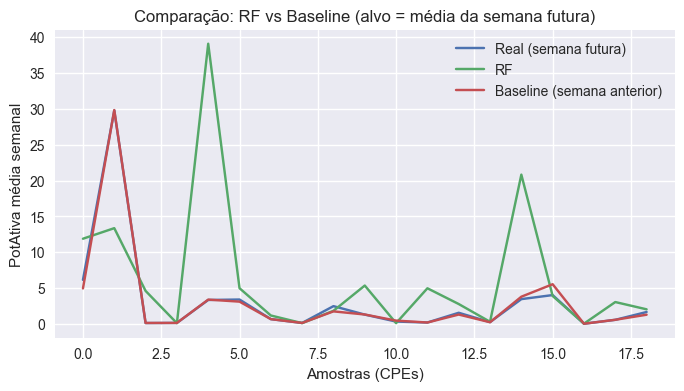

In [84]:
df_eval = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred_rf": y_pred,              # garante o nome correto
    "y_base": y_base_test.values
})

print(df_eval.columns)
df_eval.head()


plt.figure(figsize=(8,4))
plt.plot(df_eval["y_true"].values, label="Real (semana futura)")
plt.plot(df_eval["y_pred_rf"].values, label="RF")
plt.plot(df_eval["y_base"].values, label="Baseline (semana anterior)")
plt.title("Comparação: RF vs Baseline (alvo = média da semana futura)")
plt.xlabel("Amostras (CPEs)")
plt.ylabel("PotAtiva média semanal")
plt.legend()
plt.show()


O grafico compara as previsões da média semanal de PotAtiva obtidas pelo Random Forest com um baseline baseado na média da semana anterior. Observa-se que o baseline apresenta um desempenho muito competitivo, refletindo a elevada autocorrelação temporal do consumo energético. O Random Forest consegue, em alguns casos, aproximar-se mais do valor real, mas apresenta também episódios de sobrestimação, evidenciando maior variabilidade nas previsões. Estes resultados indicam que, para horizontes semanais agregados, abordagens simples podem ser difíceis de superar, enquanto modelos supervisionados revelam maior potencial quando aplicados a alvos menos agregados ou a perfis de consumo mais heterogéneos.

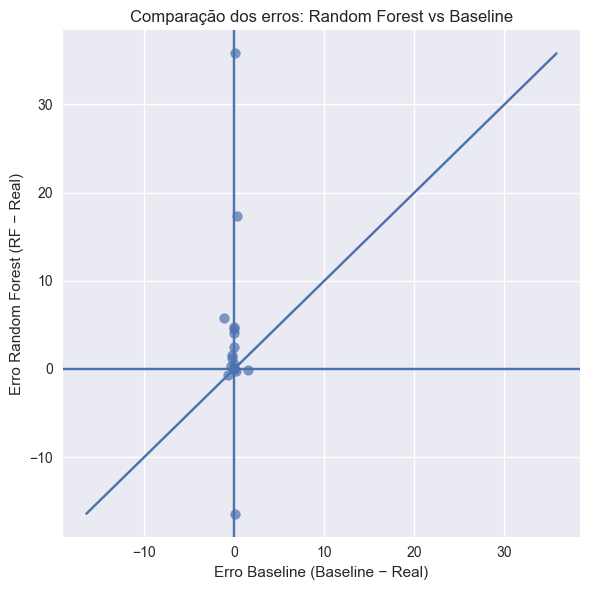

In [85]:
# Erros
err_rf = y_pred - y_test.values
err_base = y_base_test.values - y_test.values

plt.figure(figsize=(6, 6))

plt.scatter(err_base, err_rf, alpha=0.7)

# linhas de referência
lims = [
    min(err_base.min(), err_rf.min()),
    max(err_base.max(), err_rf.max())
]
plt.plot(lims, lims)  # diagonal y = x
plt.axhline(0)
plt.axvline(0)

plt.xlabel("Erro Baseline (Baseline − Real)")
plt.ylabel("Erro Random Forest (RF − Real)")
plt.title("Comparação dos erros: Random Forest vs Baseline")

plt.tight_layout()
plt.show()


O grafico apresenta a comparação direta dos erros do Random Forest e do baseline semanal. Observa-se uma forte concentração de pontos junto ao eixo horizontal, evidenciando o reduzido erro do baseline. O Random Forest apresenta maior dispersão dos erros, com melhorias pontuais face ao baseline, mas também com episódios de sobrestimação. Estes resultados indicam que, para um alvo agregado à escala semanal, abordagens simples baseadas na persistência temporal são difíceis de superar, enquanto modelos supervisionados demonstram maior potencial quando aplicados a previsões menos agregadas.

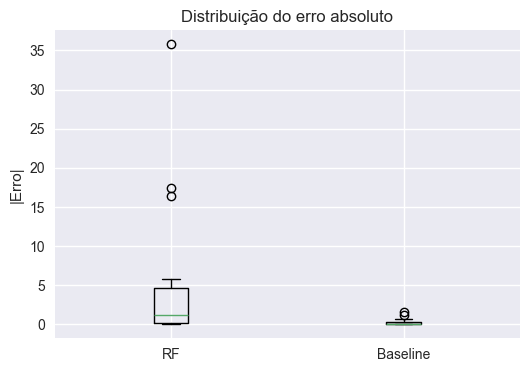

In [86]:
plt.figure(figsize=(6,4))
plt.boxplot(
    [np.abs(err_rf), np.abs(err_base)],
    labels=["RF", "Baseline"]
)
plt.ylabel("|Erro|")
plt.title("Distribuição do erro absoluto")
plt.show()


O grafico apresenta a distribuição do erro absoluto do Random Forest e do baseline semanal. Observa-se que o baseline apresenta erros sistematicamente inferiores e uma variabilidade reduzida, enquanto o Random Forest apresenta maior dispersão e outliers significativos. Estes resultados indicam que, para um alvo agregado à escala semanal, o baseline constitui uma referência difícil de superar, reforçando a importância da escolha do horizonte temporal na avaliação de modelos supervisionados.

##### 4.3.4 Conclusão (Limitações + Principais Conclusões)

No modelo Random Forest, as features não foram normalizadas. Por se tratar de um algoritmo baseado em árvores de decisão, a sua performance é invariável à escala das variáveis de entrada. Assim, as features foram utilizadas na sua escala original, preservando a interpretabilidade física das grandezas energéticas e evitando transformações desnecessárias.

Para a previsão da média semanal de PotAtiva, o Random Forest apresentou desempenho inferior ao baseline baseado na média da semana anterior, que revelou erros mais baixos e menor variabilidade. Este resultado reflete a forte autocorrelação temporal do consumo energético, tornando abordagens simples particularmente eficazes para horizontes semanais agregados.

O Random Forest apresentou maior dispersão dos erros e outliers, indicando sensibilidade a diferenças estruturais entre CPEs e ao número limitado de observações disponíveis para treino. As features agregadas utilizadas não capturam a dinâmica intra-semanal, o que limita o potencial do modelo para este tipo de alvo.

Em síntese, o Random Forest mostrou-se metodologicamente adequado, mas mais indicado para caracterização e análise comparativa de consumidores ou para horizontes temporais menos agregados, do que para a previsão direta da média semanal.

### 4.3.2 Feature-based Prediction (MLP)

##### A) Data Preparation – MLP (feature-based)

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# df_rf deve conter:
# ["CPE", "y_true_future_week", "y_base_future_week"] + selected_features
required = {"CPE", "y_true_future_week", "y_base_future_week"} | set(selected_features)
missing = required - set(df_rf.columns)
if missing:
    raise ValueError(f"df_rf não tem colunas necessárias: {missing}")

# remover linhas inválidas
df_mlp = df_rf.dropna(subset=["y_true_future_week", "y_base_future_week"] + selected_features).copy()

X = df_mlp[selected_features].values
y = df_mlp["y_true_future_week"].values
y_base = df_mlp["y_base_future_week"].values
cpe = df_mlp["CPE"].values

# Split treino/teste ao nível de CPE (generalização entre consumidores)
X_train, X_test, y_train, y_test, y_base_train, y_base_test, cpe_train, cpe_test = train_test_split(
    X, y, y_base, cpe,
    test_size=0.30,
    random_state=42
)

# Normalização (FIT só no treino -> sem leakage)
scaler_mlp = StandardScaler()
X_train_sc = scaler_mlp.fit_transform(X_train)
X_test_sc = scaler_mlp.transform(X_test)

print("Train:", X_train_sc.shape, "Test:", X_test_sc.shape)

print("Definição do target (verificação):")
print("- y_true_future_week: média da 1ª semana do teste (semana seguinte)")
print("- y_base_future_week: média da última semana do treino (uma semana antes)")



Train: (34, 13) Test: (15, 13)
Definição do target (verificação):
- y_true_future_week: média da 1ª semana do teste (semana seguinte)
- y_base_future_week: média da última semana do treino (uma semana antes)


##### B) Modelling (MLP)

In [88]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    learning_rate="adaptive",
    max_iter=2000,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=30
)

mlp.fit(X_train_sc, y_train)
y_pred = mlp.predict(X_test_sc)


##### C) Evaluation (MLP vs Baseline)

In [89]:
mae_mlp = mean_absolute_error(y_test, y_pred)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred))

mae_base = mean_absolute_error(y_test, y_base_test)
rmse_base = np.sqrt(mean_squared_error(y_test, y_base_test))

print("MLP -> MAE:", mae_mlp, "| RMSE:", rmse_mlp)
print("Baseline -> MAE:", mae_base, "| RMSE:", rmse_base)

df_eval_mlp = pd.DataFrame({
    "CPE": cpe_test,
    "y_true": y_test,
    "y_pred_mlp": y_pred,
    "y_base": y_base_test
})
df_eval_mlp.head()


MLP -> MAE: 4.330745514103517 | RMSE: 6.395257036337289
Baseline -> MAE: 0.4939484126984127 | RMSE: 0.6421999092943974


CPE    y_true  y_pred_mlp    y_base
0  PT0002000068859597LS  8.401786   16.539018  8.505952
1  PT0002000120237616VJ  2.590774    3.071244  3.680060
2  PT0002000125379984SH  2.244048    1.714518  1.561012
3  PT0002000119303492KB  0.866071    2.452884  0.872024
4  PT0002000073717386HC  6.127976    0.451693  4.930060

##### D) Avaliação

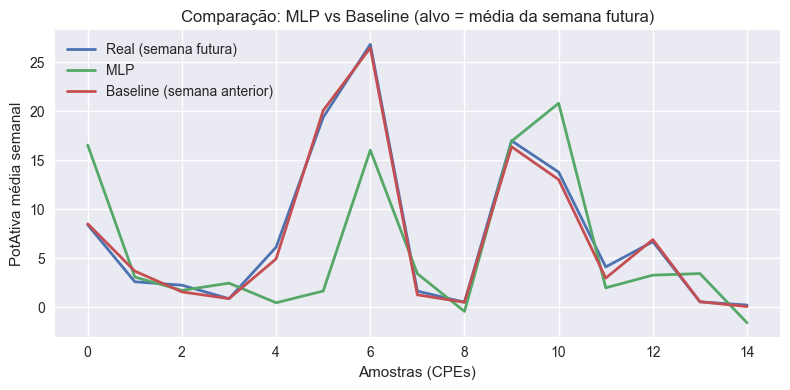

In [90]:
plt.figure(figsize=(8,4))

plt.plot(
    df_eval_mlp["y_true"].values,
    label="Real (semana futura)",
    linewidth=2
)

plt.plot(
    df_eval_mlp["y_pred_mlp"].values,
    label="MLP",
    linewidth=2
)

plt.plot(
    df_eval_mlp["y_base"].values,
    label="Baseline (semana anterior)",
    linewidth=2
)

plt.title("Comparação: MLP vs Baseline (alvo = média da semana futura)")
plt.xlabel("Amostras (CPEs)")
plt.ylabel("PotAtiva média semanal")
plt.legend()
plt.tight_layout()
plt.show()


O grafico compara as previsões da média semanal de PotAtiva obtidas pelo MLP com o baseline semanal. Observa-se que o MLP consegue captar a tendência global do consumo e identificar corretamente períodos de maior consumo, embora apresente erros de sobrestimação e subestimação em alguns CPEs. O baseline revela um comportamento mais estável e competitivo, reforçando a elevada persistência temporal do consumo energético à escala semanal.

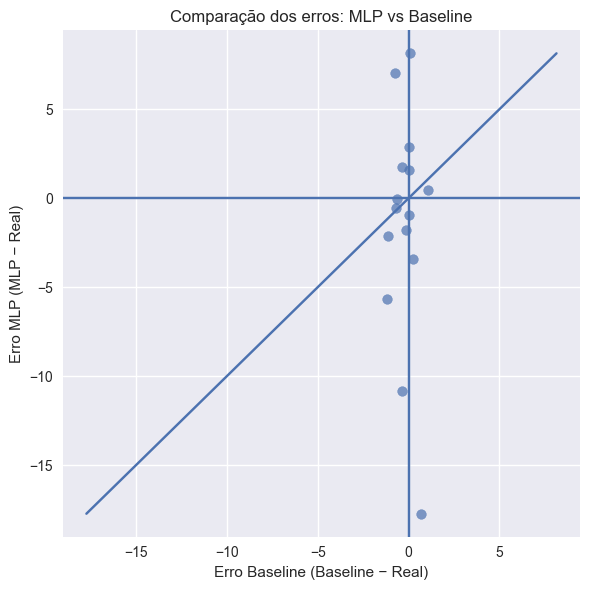

In [91]:
err_mlp = df_eval_mlp["y_pred_mlp"].values - df_eval_mlp["y_true"].values
err_base = df_eval_mlp["y_base"].values - df_eval_mlp["y_true"].values

plt.figure(figsize=(6,6))
plt.scatter(err_base, err_mlp, alpha=0.7)

lims = [min(err_base.min(), err_mlp.min()), max(err_base.max(), err_mlp.max())]
plt.plot(lims, lims)
plt.axhline(0)
plt.axvline(0)

plt.xlabel("Erro Baseline (Baseline − Real)")
plt.ylabel("Erro MLP (MLP − Real)")
plt.title("Comparação dos erros: MLP vs Baseline")
plt.tight_layout()
plt.show()


O grafico apresenta a comparação direta dos erros do MLP e do baseline semanal. Observa-se que o baseline apresenta erros reduzidos e estáveis, enquanto o MLP revela maior dispersão e alguns outliers. Estes resultados indicam que, para um alvo agregado à escala semanal, a utilização de um MLP não conduz a ganhos sistemáticos face a abordagens simples baseadas na persistência temporal.

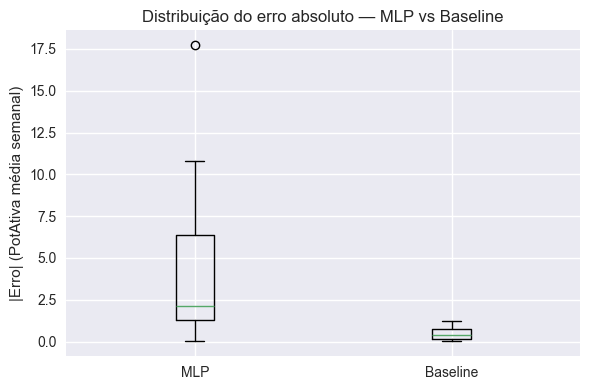

In [92]:
# erros absolutos
abs_err_mlp = np.abs(df_eval_mlp["y_pred_mlp"].values - df_eval_mlp["y_true"].values)
abs_err_base = np.abs(df_eval_mlp["y_base"].values - df_eval_mlp["y_true"].values)

plt.figure(figsize=(6,4))
plt.boxplot(
    [abs_err_mlp, abs_err_base],
    labels=["MLP", "Baseline"],
    showfliers=True
)
plt.ylabel("|Erro| (PotAtiva média semanal)")
plt.title("Distribuição do erro absoluto — MLP vs Baseline")
plt.tight_layout()
plt.show()


O grafico apresenta a distribuição do erro absoluto do MLP e do baseline semanal. Observa-se que o baseline apresenta erros sistematicamente mais baixos e menor variabilidade, enquanto o MLP evidencia maior dispersão e a presença de outliers. Estes resultados confirmam que, para a previsão da média semanal de PotAtiva, abordagens simples baseadas na persistência temporal continuam a ser mais estáveis do que modelos supervisionados baseados em features agregadas.

##### Conclusão (Limitações + Principais Conclusões)

O MLP demonstrou capacidade para capturar o padrão global da média semanal de consumo energético quando treinado com feature-sets agregados por CPE. O modelo conseguiu acompanhar a tendência geral do consumo e identificar corretamente períodos de maior consumo em alguns CPEs, evidenciando que as features extraídas contêm informação relevante.

No entanto, os resultados mostraram que, para a previsão da média da semana seguinte, o MLP não supera de forma consistente o baseline baseado na média da semana anterior. O baseline apresentou erros mais baixos e menor variabilidade, refletindo a forte persistência temporal do consumo energético à escala semanal. O MLP revelou maior dispersão dos erros e a presença de outliers, indicando sensibilidade a diferenças estruturais entre CPEs e à limitada dimensão do conjunto de treino.

Como principais limitações, destacam-se a natureza agregada do alvo semanal, que reduz a variabilidade a prever, o número reduzido de CPEs disponíveis, e a incapacidade das features agregadas em capturar a dinâmica intra-semanal do consumo. Assim, conclui-se que o MLP é metodologicamente adequado, mas mais indicado para horizontes temporais menos agregados ou para tarefas de análise e caracterização de consumidores, do que para a previsão direta da média semanal.

### Comparação final RF vs MLP vs baseline

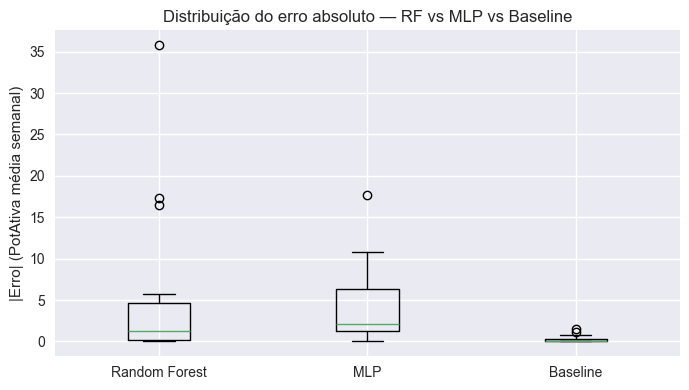

In [93]:
# Erros absolutos
abs_err_rf = np.abs(df_eval["y_pred_rf"].values - df_eval["y_true"].values)
abs_err_mlp = np.abs(df_eval_mlp["y_pred_mlp"].values - df_eval_mlp["y_true"].values)
abs_err_base_rf = np.abs(df_eval["y_base"].values - df_eval["y_true"].values)

plt.figure(figsize=(7,4))
plt.boxplot(
    [abs_err_rf, abs_err_mlp, abs_err_base_rf],
    labels=["Random Forest", "MLP", "Baseline"],
    showfliers=True
)

plt.ylabel("|Erro| (PotAtiva média semanal)")
plt.title("Distribuição do erro absoluto — RF vs MLP vs Baseline")
plt.tight_layout()
plt.show()


##### Comparação Global dos Modelos de Previsão (RF, MLP e Baseline)

A comparação entre o Random Forest (RF), o MLP e o baseline evidencia diferenças claras no desempenho para a previsão da média da semana seguinte da PotAtiva por CPE. O baseline, definido como a média da semana anterior, apresentou consistentemente os menores erros e menor variabilidade, beneficiando da forte persistência temporal do consumo energético à escala semanal.

O Random Forest revelou capacidade para capturar relações não lineares entre as features agregadas por CPE, aproximando-se do valor real em vários casos. No entanto, apresentou outliers significativos, resultantes de sobre-estimações pontuais, o que penalizou o erro máximo e a robustez global do modelo. Ainda assim, o seu desempenho médio foi superior ao do MLP.

O MLP demonstrou maior dificuldade em generalizar, sobretudo em CPEs com picos de consumo mais acentuados, evidenciando sub-estimações frequentes e maior dispersão dos erros. Apesar da normalização das features, o modelo mostrou sensibilidade à dimensão reduzida do conjunto de treino e à elevada agregação temporal do alvo semanal.

A análise dos boxplots do erro absoluto confirma estes resultados: o baseline apresenta a menor mediana e dispersão, seguido do Random Forest, enquanto o MLP apresenta a pior distribuição de erros. Os gráficos de erro relativo reforçam que, na maioria dos CPEs, os modelos supervisionados não superam o baseline.

Conclui-se que, embora RF e MLP sejam metodologicamente adequados e úteis para caracterização de consumidores, a previsão da média semanal é dominada por efeitos de persistência temporal, tornando o baseline um referencial difícil de superar neste contexto.

## 5. Conclusão 

Ao longo deste trabalho foi aplicada a metodologia CRISP-DM ao conjunto de dados de consumo energético do Município da Maia, combinando técnicas de clustering, previsão por séries temporais e modelos supervisionados baseados em features para explorar o potencial analítico do dataset.

Na Questão 1 (Clustering), verificou-se que métodos mais simples como o K-Means e o DBSCAN tiveram dificuldade em lidar com a elevada heterogeneidade dos edifícios e com a presença de outliers. O Gaussian Mixture Model (GMM), especialmente após normalização, destacou-se por conseguir formar clusters mais coerentes e interpretáveis, separando de forma clara diferentes perfis de consumo, como edifícios residenciais, comerciais e grandes consumidores. Esta segmentação revelou-se fundamental para estruturar a análise preditiva que se seguiu.

Na Questão 2 (Previsão por Séries Temporais), foram comparados os modelos ARIMA e LSTM em cada cluster, usando como referência um baseline simples baseado no valor da mesma hora da semana anterior. Os resultados mostraram que o ARIMA só foi realmente competitivo nos clusters mais estáveis, em particular no Cluster 0. Já o LSTM, sobretudo quando treinado com séries normalizadas, conseguiu capturar melhor os padrões não lineares e os ciclos diários de consumo, apresentando melhor desempenho nos clusters de consumo mais regular e intermédio. Nos clusters mais voláteis, como o Cluster 3, ambos os modelos tiveram dificuldades, mas o LSTM ainda assim conseguiu reduzir significativamente o erro face ao ARIMA.

Na Questão 3 (Previsão baseada em features), os modelos Random Forest e MLP foram usados para prever a média da semana seguinte a partir de estatísticas do histórico. No entanto, em ambos os casos, o baseline (média da semana anterior) teve um desempenho claramente superior. Isto mostra que, para este horizonte temporal, o consumo apresenta uma forte continuidade, e que as features agregadas utilizadas não foram suficientes para acrescentar poder preditivo relevante sem informação externa adicional, como dados meteorológicos, ocupação dos edifícios ou tipo de utilização.

Em conjunto, os resultados mostram que este dataset é muito adequado para segmentação e caracterização de perfis de consumo e útil para previsões de curto prazo quando se usam modelos de séries temporais, especialmente combinados com clustering. Por outro lado, para previsões agregadas baseadas apenas em features históricas, o ganho face a um baseline simples é limitado. Isto sugere que o maior valor destes dados está na análise detalhada do comportamento energético e na monitorização operacional, e que previsões mais robustas exigirão a integração de variáveis externas e modelos mais ricos no futuro.

Apesar dos resultados obtidos, existem algumas limitações que importa referir. Em primeiro lugar, os dados disponíveis não incluem informação externa, como condições meteorológicas, tipo de edifício ou níveis de ocupação, que são fatores importantes para explicar o consumo de energia. Além disso, os CPEs apresentam comportamentos muito diferentes entre si e, em alguns casos, séries bastante irregulares, o que dificulta o desempenho dos modelos, sobretudo nos clusters mais instáveis. Por fim, a avaliação foi feita apenas com um CPE por cluster, o que não permite garantir que os resultados sejam totalmente representativos de todos os edifícios.
No futuro, este trabalho pode ser melhorado avaliando vários CPEs por cluster, de forma a obter resultados mais robustos. A integração de dados externos, como meteorologia, níveis de ocupação e características dos edifícios, poderá também aumentar significativamente a qualidade das previsões. Para além disso, a utilização de modelos mais avançados ou combinações de vários modelos poderá ajudar a captar melhor os diferentes padrões de consumo e reduzir os erros de previsão.



# Exportação dos datasets Intermédios

In [95]:
# ============================
# Exportação dos datasets para Moodle
# ============================

# 1. Dados preparados (limpos, interpolados, 15 min)
df_prep.to_csv("df_prep.csv", index=False)

# 2. Dataset feature-based (Random Forest / MLP)
df_rf.to_csv("df_rf.csv", index=False)

# 3. Clusters GMM por CPE
cluster_gmm.to_frame(name="cluster_gmm").to_csv("cluster_gmm.csv")

#Versão tabular dos clusters
if "df_clusters_gmm" in globals():
    df_clusters_gmm.to_csv("df_clusters_gmm_full.csv", index=False)

#Resultados LSTM (normalizado)
if "df_lstm_week_results_norm" in globals():
    df_lstm_week_results_norm.to_csv("lstm_results.csv", index=False)

#Resultados ARIMA (normalizado)
if "results_df_norm" in globals():
    results_df_norm.to_csv("arima_results.csv", index=False)

print("Ficheiros exportados com sucesso.")


Ficheiros exportados com sucesso.


In [96]:
# Escolher 3 CPEs mais completos
top_cpes = (
    df_prep["CPE"]
    .value_counts()
    .head(3)
    .index
)

df_sample = df_prep[df_prep["CPE"].isin(top_cpes)].copy()

# Limitar a 28 dias por CPE
df_sample = (
    df_sample
    .sort_values("hora")
    .groupby("CPE")
    .head(28 * 96)   # 28 dias * 96 registos/dia
)

# Guardar
df_sample.to_csv("df_prep_sample.csv", index=False)

print("df_prep_sample.csv criado:", df_sample.shape)

df_prep_sample.csv criado: (8064, 14)
